In [39]:
import pandas as pd 
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
#plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
import numpy as np
from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

In [40]:
#path = '~/workplace/datas/energy/'
path = '~/Desktop/workplace/datas/energy/'

train_df = pd.read_csv(path + 'final_data.csv',index_col=0)
y_test = pd.read_csv(path + 'y_test.csv', index_col=0)
encoded_train_df = pd.read_csv(path + 'encoded_train_df.csv', index_col=0)
encoded_test_df = pd.read_csv(path + 'encoded_test_df.csv', index_col=0)

In [41]:
train_df.shape, y_test.shape, encoded_train_df.shape, encoded_test_df.shape

((547521, 11), (2016, 2), (545505, 96), (2016, 96))

### previous_data

In [10]:
train = train_df.loc[:'2023-03-16']
test = train_df.loc['2023-03-16':'2023-03-20']

### Encoded_data

In [42]:
X = encoded_train_df.drop(columns=['현재수요(MW)']).to_numpy()
y = encoded_train_df['현재수요(MW)'].to_numpy().reshape(-1, 1)

X_test = encoded_test_df.drop(columns=['현재수요(MW)']).to_numpy()
y_test = encoded_test_df['현재수요(MW)'].to_numpy().reshape(-1, 1)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state=20, shuffle=False)

In [44]:
X.shape, y.shape, X_test.shape, y_test.shape

((545505, 95), (545505, 1), (2016, 95), (2016, 1))

# DATA_Preprocessing

In [13]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1].to_numpy().reshape(-1, 1)


X_test = test.iloc[: ,:-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy().reshape(-1,1)

In [14]:
X.shape, y.shape, X_test.shape, y_test.shape

((546369, 10), (546369, 1), (1152, 10), (1152, 1))

In [15]:
#scailing

from sklearn.preprocessing import MinMaxScaler, StandardScaler
min_max_scaler = MinMaxScaler()


X_scaled = min_max_scaler.fit_transform(X.to_numpy())
X_test_scaled = min_max_scaler.fit_transform(X_test)

# DATA_preprocessing without scailing

In [48]:
X = train.iloc[:,:-1].to_numpy()
y = train.iloc[:,-1].to_numpy().reshape(-1, 1)


X_test = test.iloc[: ,:-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy().reshape(-1,1)

X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=False)

# Encoded_data_preprocessing

# LGBM

In [45]:
import lightgbm as lgb


# Create a lgb.Dataset for both training and testing
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)



def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mape',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,  # Set feature_pre_filter to False
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 32, 64),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }


    gbm = lgb.train(params, lgb_train, 
                    valid_sets=lgb_eval,
                    num_boost_round=1000,
                   early_stopping_rounds=10)
    preds = gbm.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, preds)
    return mape


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2023-07-10 13:30:03,725] A new study created in memory with name: no-name-8edaa304-d766-4a38-b720-539f4f4a6786
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This fe

[1]	valid_0's mape: 0.112291
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.111559
[3]	valid_0's mape: 0.111497
[4]	valid_0's mape: 0.110815
[5]	valid_0's mape: 0.110056
[6]	valid_0's mape: 0.109479
[7]	valid_0's mape: 0.109689
[8]	valid_0's mape: 0.109144
[9]	valid_0's mape: 0.108487
[10]	valid_0's mape: 0.108845
[11]	valid_0's mape: 0.108403
[12]	valid_0's mape: 0.107952
[13]	valid_0's mape: 0.107416
[14]	valid_0's mape: 0.10702
[15]	valid_0's mape: 0.106651
[16]	valid_0's mape: 0.106328
[17]	valid_0's mape: 0.106055
[18]	valid_0's mape: 0.106516
[19]	valid_0's mape: 0.106263
[20]	valid_0's mape: 0.105966
[21]	valid_0's mape: 0.105678
[22]	valid_0's mape: 0.105234
[23]	valid_0's mape: 0.104825
[24]	valid_0's mape: 0.104568
[25]	valid_0's mape: 0.104371
[26]	valid_0's mape: 0.104807
[27]	valid_0's mape: 0.104568
[28]	valid_0's mape: 0.10439
[29]	valid_0's mape: 0.104033
[30]	valid_0's mape: 0.10371
[31]	valid_0's mape: 0.103523
[32]	valid_0's mape: 

[I 2023-07-10 13:30:04,346] Trial 0 finished with value: 0.08537972938071486 and parameters: {'lambda_l1': 3.3808823562816233e-06, 'lambda_l2': 9.461740168428932e-07, 'max_depth': 55, 'num_leaves': 2, 'feature_fraction': 0.6744935132266678, 'bagging_fraction': 0.9233123889924162, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 0 with value: 0.08537972938071486.


[146]	valid_0's mape: 0.0907753
Early stopping, best iteration is:
[136]	valid_0's mape: 0.090557
[1]	valid_0's mape: 0.112063
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10941
[3]	valid_0's mape: 0.107583
[4]	valid_0's mape: 0.104652
[5]	valid_0's mape: 0.101886


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0995976
[7]	valid_0's mape: 0.0992186
[8]	valid_0's mape: 0.0970458
[9]	valid_0's mape: 0.0954315
[10]	valid_0's mape: 0.0947607
[11]	valid_0's mape: 0.0945798
[12]	valid_0's mape: 0.0938407
[13]	valid_0's mape: 0.0926699
[14]	valid_0's mape: 0.092095
[15]	valid_0's mape: 0.0924008
[16]	valid_0's mape: 0.0936619
[17]	valid_0's mape: 0.0931091
[18]	valid_0's mape: 0.0928065
[19]	valid_0's mape: 0.0924287
[20]	valid_0's mape: 0.0917473
[21]	valid_0's mape: 0.0912271
[22]	valid_0's mape: 0.091487
[23]	valid_0's mape: 0.0909776
[24]	valid_0's mape: 0.0906991
[25]	valid_0's mape: 0.0901992
[26]	valid_0's mape: 0.0900664
[27]	valid_0's mape: 0.0896502
[28]	valid_0's mape: 0.0894026
[29]	valid_0's mape: 0.088915
[30]	valid_0's mape: 0.0886572
[31]	valid_0's mape: 0.0886819
[32]	valid_0's mape: 0.0888064
[33]	valid_0's mape: 0.089144
[34]	valid_0's mape: 0.0888285
[35]	valid_0's mape: 0.0889982
[36]	valid_0's mape: 0.0887961
[37]	valid_0's mape: 0.0885074
[38]	valid_0's m

[I 2023-07-10 13:30:06,807] Trial 1 finished with value: 0.07964078129038674 and parameters: {'lambda_l1': 0.1983493726596203, 'lambda_l2': 0.00968969110698438, 'max_depth': 60, 'num_leaves': 172, 'feature_fraction': 0.4262777851937707, 'bagging_fraction': 0.9215385969766617, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial 1 with value: 0.07964078129038674.


[68]	valid_0's mape: 0.0861847
[69]	valid_0's mape: 0.0861466
[70]	valid_0's mape: 0.0861384
Early stopping, best iteration is:
[60]	valid_0's mape: 0.0860687
[1]	valid_0's mape: 0.108185
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104748


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.102908
[4]	valid_0's mape: 0.0994086
[5]	valid_0's mape: 0.0980666
[6]	valid_0's mape: 0.0958757
[7]	valid_0's mape: 0.0964844
[8]	valid_0's mape: 0.0956573
[9]	valid_0's mape: 0.0937299
[10]	valid_0's mape: 0.0932889
[11]	valid_0's mape: 0.0929595
[12]	valid_0's mape: 0.092577
[13]	valid_0's mape: 0.09237
[14]	valid_0's mape: 0.0915717
[15]	valid_0's mape: 0.0910404
[16]	valid_0's mape: 0.0906323
[17]	valid_0's mape: 0.0899301
[18]	valid_0's mape: 0.0897507
[19]	valid_0's mape: 0.0902173
[20]	valid_0's mape: 0.0895804
[21]	valid_0's mape: 0.0891277
[22]	valid_0's mape: 0.0886184
[23]	valid_0's mape: 0.0880295
[24]	valid_0's mape: 0.0878153
[25]	valid_0's mape: 0.0874936
[26]	valid_0's mape: 0.0875133
[27]	valid_0's mape: 0.0871836
[28]	valid_0's mape: 0.0870188
[29]	valid_0's mape: 0.0868596
[30]	valid_0's mape: 0.0867127
[31]	valid_0's mape: 0.0871292
[32]	valid_0's mape: 0.0868754
[33]	valid_0's mape: 0.0867484
[34]	valid_0's mape: 0.086759
[35]	valid_0's mape:

[I 2023-07-10 13:30:09,019] Trial 2 finished with value: 0.07837533866753525 and parameters: {'lambda_l1': 5.138276669683454e-08, 'lambda_l2': 1.2157987361740925e-06, 'max_depth': 48, 'num_leaves': 209, 'feature_fraction': 0.7107405764426169, 'bagging_fraction': 0.5783257203333619, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 2 with value: 0.07837533866753525.


[47]	valid_0's mape: 0.087096
[48]	valid_0's mape: 0.0870297
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0862101
[1]	valid_0's mape: 0.111374
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.108883
[3]	valid_0's mape: 0.106745


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.103832
[5]	valid_0's mape: 0.101024
[6]	valid_0's mape: 0.0987459
[7]	valid_0's mape: 0.0983869
[8]	valid_0's mape: 0.0962127
[9]	valid_0's mape: 0.0945465
[10]	valid_0's mape: 0.0933071
[11]	valid_0's mape: 0.0930955
[12]	valid_0's mape: 0.0925308
[13]	valid_0's mape: 0.0913945
[14]	valid_0's mape: 0.0910356
[15]	valid_0's mape: 0.0908673
[16]	valid_0's mape: 0.0919069
[17]	valid_0's mape: 0.0912797
[18]	valid_0's mape: 0.0909742
[19]	valid_0's mape: 0.0909042
[20]	valid_0's mape: 0.0905082
[21]	valid_0's mape: 0.0900198
[22]	valid_0's mape: 0.0902544
[23]	valid_0's mape: 0.0897576
[24]	valid_0's mape: 0.0897375
[25]	valid_0's mape: 0.0893241
[26]	valid_0's mape: 0.0891628
[27]	valid_0's mape: 0.0887857
[28]	valid_0's mape: 0.0884663
[29]	valid_0's mape: 0.0881455
[30]	valid_0's mape: 0.0878845
[31]	valid_0's mape: 0.0880061
[32]	valid_0's mape: 0.0879742
[33]	valid_0's mape: 0.0883378
[34]	valid_0's mape: 0.0880336
[35]	valid_0's mape: 0.0883953
[36]	valid_0's m

[I 2023-07-10 13:30:12,143] Trial 3 finished with value: 0.0821505772641155 and parameters: {'lambda_l1': 0.0015383698062492997, 'lambda_l2': 2.38318881997225, 'max_depth': 44, 'num_leaves': 157, 'feature_fraction': 0.43334007479568726, 'bagging_fraction': 0.49929635980353004, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 2 with value: 0.07837533866753525.


[82]	valid_0's mape: 0.0854481
[83]	valid_0's mape: 0.0854695
[84]	valid_0's mape: 0.0854765
[85]	valid_0's mape: 0.0854877
[86]	valid_0's mape: 0.0856292
[87]	valid_0's mape: 0.085627
Early stopping, best iteration is:
[77]	valid_0's mape: 0.0854337


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108119
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104248
[3]	valid_0's mape: 0.102395
[4]	valid_0's mape: 0.100693
[5]	valid_0's mape: 0.0994427
[6]	valid_0's mape: 0.0984028
[7]	valid_0's mape: 0.0959735
[8]	valid_0's mape: 0.0949828
[9]	valid_0's mape: 0.094659
[10]	valid_0's mape: 0.0940522
[11]	valid_0's mape: 0.0925762
[12]	valid_0's mape: 0.0926011
[13]	valid_0's mape: 0.0915743
[14]	valid_0's mape: 0.0903666
[15]	valid_0's mape: 0.0896411
[16]	valid_0's mape: 0.0887085
[17]	valid_0's mape: 0.0881643
[18]	valid_0's mape: 0.0889747
[19]	valid_0's mape: 0.08971
[20]	valid_0's mape: 0.0895047
[21]	valid_0's mape: 0.0890175
[22]	valid_0's mape: 0.0899971
[23]	valid_0's mape: 0.0894224
[24]	valid_0's mape: 0.0887915
[25]	valid_0's mape: 0.088419
[26]	valid_0's mape: 0.0883457
[27]	valid_0's mape: 0.0879747
[28]	valid_0's mape: 0.0876683
[29]	valid_0's mape: 0.087656
[30]	valid_0's mape: 0.0875332
[31]	valid_0's mape: 0.0877

[I 2023-07-10 13:30:13,934] Trial 4 finished with value: 0.07770292854380506 and parameters: {'lambda_l1': 0.3611276323362303, 'lambda_l2': 0.014079061567111611, 'max_depth': 55, 'num_leaves': 86, 'feature_fraction': 0.9810342997246362, 'bagging_fraction': 0.6246904402570771, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 4 with value: 0.07770292854380506.


[74]	valid_0's mape: 0.0867461
Early stopping, best iteration is:
[64]	valid_0's mape: 0.0866613
[1]	valid_0's mape: 0.110033
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.108705
[3]	valid_0's mape: 0.107952
[4]	valid_0's mape: 0.105705
[5]	valid_0's mape: 0.10336
[6]	valid_0's mape: 0.10167
[7]	valid_0's mape: 0.101739
[8]	valid_0's mape: 0.0997708
[9]	valid_0's mape: 0.0985575
[10]	valid_0's mape: 0.0973624
[11]	valid_0's mape: 0.0972128
[12]	valid_0's mape: 0.0964571
[13]	valid_0's mape: 0.0954731
[14]	valid_0's mape: 0.0953903
[15]	valid_0's mape: 0.0953194
[16]	valid_0's mape: 0.09461
[17]	valid_0's mape: 0.0933354
[18]	valid_0's mape: 0.0931701
[19]	valid_0's mape: 0.0923277


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[20]	valid_0's mape: 0.0931034
[21]	valid_0's mape: 0.0924676
[22]	valid_0's mape: 0.0919554
[23]	valid_0's mape: 0.0912143
[24]	valid_0's mape: 0.0905465
[25]	valid_0's mape: 0.0900315
[26]	valid_0's mape: 0.0894514
[27]	valid_0's mape: 0.0886847
[28]	valid_0's mape: 0.0881881
[29]	valid_0's mape: 0.0876518
[30]	valid_0's mape: 0.0882327
[31]	valid_0's mape: 0.0877795
[32]	valid_0's mape: 0.0880142
[33]	valid_0's mape: 0.0874732
[34]	valid_0's mape: 0.0871163
[35]	valid_0's mape: 0.0869947
[36]	valid_0's mape: 0.0867283
[37]	valid_0's mape: 0.0863644
[38]	valid_0's mape: 0.0864471
[39]	valid_0's mape: 0.085922
[40]	valid_0's mape: 0.0856754
[41]	valid_0's mape: 0.0855872
[42]	valid_0's mape: 0.0853343
[43]	valid_0's mape: 0.0850981
[44]	valid_0's mape: 0.084721
[45]	valid_0's mape: 0.0851644
[46]	valid_0's mape: 0.0850433
[47]	valid_0's mape: 0.0857602
[48]	valid_0's mape: 0.0855135
[49]	valid_0's mape: 0.0852055
[50]	valid_0's mape: 0.0848193
[51]	valid_0's mape: 0.084702
[52]	valid_

[I 2023-07-10 13:30:14,599] Trial 5 finished with value: 0.07847824306411612 and parameters: {'lambda_l1': 2.220947429806517, 'lambda_l2': 5.426312711558941, 'max_depth': 35, 'num_leaves': 12, 'feature_fraction': 0.4670339595629984, 'bagging_fraction': 0.9015572609351078, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 4 with value: 0.07770292854380506.


[61]	valid_0's mape: 0.0841296
[62]	valid_0's mape: 0.0847932
[63]	valid_0's mape: 0.084771
[64]	valid_0's mape: 0.0847932
[65]	valid_0's mape: 0.0847089
[66]	valid_0's mape: 0.0845937
[67]	valid_0's mape: 0.0844358
Early stopping, best iteration is:
[57]	valid_0's mape: 0.0837101
[1]	valid_0's mape: 0.10831
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104937
[3]	valid_0's mape: 0.102911


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.0995691
[5]	valid_0's mape: 0.0980512
[6]	valid_0's mape: 0.098008
[7]	valid_0's mape: 0.0974815
[8]	valid_0's mape: 0.096593
[9]	valid_0's mape: 0.0948627
[10]	valid_0's mape: 0.094909
[11]	valid_0's mape: 0.0939984
[12]	valid_0's mape: 0.0937076
[13]	valid_0's mape: 0.0929349
[14]	valid_0's mape: 0.0927477
[15]	valid_0's mape: 0.0917259
[16]	valid_0's mape: 0.0909217
[17]	valid_0's mape: 0.0903035
[18]	valid_0's mape: 0.0910205
[19]	valid_0's mape: 0.0906664
[20]	valid_0's mape: 0.0901309
[21]	valid_0's mape: 0.0897935
[22]	valid_0's mape: 0.0894054
[23]	valid_0's mape: 0.0889706
[24]	valid_0's mape: 0.0891163
[25]	valid_0's mape: 0.0886715
[26]	valid_0's mape: 0.0891352
[27]	valid_0's mape: 0.0890543
[28]	valid_0's mape: 0.0886976
[29]	valid_0's mape: 0.0887613
[30]	valid_0's mape: 0.0887849
[31]	valid_0's mape: 0.0887412
[32]	valid_0's mape: 0.088552
[33]	valid_0's mape: 0.0883547
[34]	valid_0's mape: 0.0884526
[35]	valid_0's mape: 0.0884412
[36]	valid_0's map

[I 2023-07-10 13:30:16,520] Trial 6 finished with value: 0.07631860798392377 and parameters: {'lambda_l1': 3.791663561891696e-08, 'lambda_l2': 0.013063304540035995, 'max_depth': 42, 'num_leaves': 174, 'feature_fraction': 0.7209493498327736, 'bagging_fraction': 0.4351792296034067, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 6 with value: 0.07631860798392377.


[46]	valid_0's mape: 0.0887654
[47]	valid_0's mape: 0.090052
[48]	valid_0's mape: 0.0900174
[49]	valid_0's mape: 0.089984
[50]	valid_0's mape: 0.0900909
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0880175
[1]	valid_0's mape: 0.113136
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.109927


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.109272
[4]	valid_0's mape: 0.107124
[5]	valid_0's mape: 0.104787
[6]	valid_0's mape: 0.103029
[7]	valid_0's mape: 0.103137
[8]	valid_0's mape: 0.101086
[9]	valid_0's mape: 0.0998746
[10]	valid_0's mape: 0.0998146
[11]	valid_0's mape: 0.0996741
[12]	valid_0's mape: 0.0987536
[13]	valid_0's mape: 0.0974124
[14]	valid_0's mape: 0.0968058
[15]	valid_0's mape: 0.0952219
[16]	valid_0's mape: 0.0944162
[17]	valid_0's mape: 0.0933843
[18]	valid_0's mape: 0.0929375
[19]	valid_0's mape: 0.0920804
[20]	valid_0's mape: 0.0926214
[21]	valid_0's mape: 0.0920527
[22]	valid_0's mape: 0.0914718
[23]	valid_0's mape: 0.0904851
[24]	valid_0's mape: 0.0900838
[25]	valid_0's mape: 0.0895838
[26]	valid_0's mape: 0.089217
[27]	valid_0's mape: 0.0884792
[28]	valid_0's mape: 0.0891791
[29]	valid_0's mape: 0.0888192
[30]	valid_0's mape: 0.0885656
[31]	valid_0's mape: 0.0880729
[32]	valid_0's mape: 0.0879009
[33]	valid_0's mape: 0.0874686
[34]	valid_0's mape: 0.0870499
[35]	valid_0's mape: 0

[I 2023-07-10 13:30:17,225] Trial 7 finished with value: 0.07659502197501346 and parameters: {'lambda_l1': 1.1932439450395008e-07, 'lambda_l2': 0.28178460524522625, 'max_depth': 37, 'num_leaves': 12, 'feature_fraction': 0.5210623196967599, 'bagging_fraction': 0.908571250028779, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 6 with value: 0.07631860798392377.


[67]	valid_0's mape: 0.0841743
[68]	valid_0's mape: 0.0841034
[69]	valid_0's mape: 0.0841001
[70]	valid_0's mape: 0.0840779
[71]	valid_0's mape: 0.0841121
Early stopping, best iteration is:
[61]	valid_0's mape: 0.0829547
[1]	valid_0's mape: 0.108446
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106153
[3]	valid_0's mape: 0.104674
[4]	valid_0's mape: 0.101264
[5]	valid_0's mape: 0.0984925


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.097307
[7]	valid_0's mape: 0.0962556
[8]	valid_0's mape: 0.0954501
[9]	valid_0's mape: 0.0944156
[10]	valid_0's mape: 0.094101
[11]	valid_0's mape: 0.0923663
[12]	valid_0's mape: 0.0910419
[13]	valid_0's mape: 0.0908992
[14]	valid_0's mape: 0.0918457
[15]	valid_0's mape: 0.0910859
[16]	valid_0's mape: 0.0915113
[17]	valid_0's mape: 0.0908979
[18]	valid_0's mape: 0.0917246
[19]	valid_0's mape: 0.0909373
[20]	valid_0's mape: 0.0905504
[21]	valid_0's mape: 0.0901946
[22]	valid_0's mape: 0.0899745
[23]	valid_0's mape: 0.0896549
[24]	valid_0's mape: 0.089686
[25]	valid_0's mape: 0.0890018
[26]	valid_0's mape: 0.0889206
[27]	valid_0's mape: 0.0882742
[28]	valid_0's mape: 0.0881961
[29]	valid_0's mape: 0.0879449
[30]	valid_0's mape: 0.0878034
[31]	valid_0's mape: 0.0874471
[32]	valid_0's mape: 0.0872366
[33]	valid_0's mape: 0.0867696
[34]	valid_0's mape: 0.0864363
[35]	valid_0's mape: 0.0862447
[36]	valid_0's mape: 0.0864385
[37]	valid_0's mape: 0.0862409
[38]	valid_0's 

[I 2023-07-10 13:30:18,745] Trial 8 finished with value: 0.0782843167492042 and parameters: {'lambda_l1': 2.2029586155725555e-08, 'lambda_l2': 3.1483116776806583e-07, 'max_depth': 34, 'num_leaves': 106, 'feature_fraction': 0.898023163861918, 'bagging_fraction': 0.9970029734021536, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 6 with value: 0.07631860798392377.


[59]	valid_0's mape: 0.0864921
[60]	valid_0's mape: 0.0864953
Early stopping, best iteration is:
[50]	valid_0's mape: 0.0858365
[1]	valid_0's mape: 0.107991
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104353
[3]	valid_0's mape: 0.101887


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.0984668
[5]	valid_0's mape: 0.0969889
[6]	valid_0's mape: 0.0946468
[7]	valid_0's mape: 0.0938398
[8]	valid_0's mape: 0.0927978
[9]	valid_0's mape: 0.0922997
[10]	valid_0's mape: 0.0918382
[11]	valid_0's mape: 0.0904147
[12]	valid_0's mape: 0.0901795
[13]	valid_0's mape: 0.0889632
[14]	valid_0's mape: 0.0893647
[15]	valid_0's mape: 0.0885391
[16]	valid_0's mape: 0.0884022
[17]	valid_0's mape: 0.0889596
[18]	valid_0's mape: 0.0887152
[19]	valid_0's mape: 0.0882651
[20]	valid_0's mape: 0.0877979
[21]	valid_0's mape: 0.0877579
[22]	valid_0's mape: 0.0875092
[23]	valid_0's mape: 0.0876486
[24]	valid_0's mape: 0.0871451
[25]	valid_0's mape: 0.0870007
[26]	valid_0's mape: 0.0868311
[27]	valid_0's mape: 0.086691
[28]	valid_0's mape: 0.0866166
[29]	valid_0's mape: 0.0864373
[30]	valid_0's mape: 0.0866923
[31]	valid_0's mape: 0.0864335
[32]	valid_0's mape: 0.0862172
[33]	valid_0's mape: 0.0862427
[34]	valid_0's mape: 0.0860314
[35]	valid_0's mape: 0.0859214
[36]	valid_0's 

[I 2023-07-10 13:30:21,663] Trial 9 finished with value: 0.08270808939625969 and parameters: {'lambda_l1': 0.06529625689918267, 'lambda_l2': 1.8458130861347649e-06, 'max_depth': 40, 'num_leaves': 236, 'feature_fraction': 0.9381469606711375, 'bagging_fraction': 0.662003539934563, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 6 with value: 0.07631860798392377.


[58]	valid_0's mape: 0.0857319
Early stopping, best iteration is:
[48]	valid_0's mape: 0.0850506
[1]	valid_0's mape: 0.10869
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105232
[3]	valid_0's mape: 0.103853
[4]	valid_0's mape: 0.100528
[5]	valid_0's mape: 0.0992045
[6]	valid_0's mape: 0.0983476
[7]	valid_0's mape: 0.0978587


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[8]	valid_0's mape: 0.0961215
[9]	valid_0's mape: 0.0942151
[10]	valid_0's mape: 0.094445
[11]	valid_0's mape: 0.0941718
[12]	valid_0's mape: 0.0943163
[13]	valid_0's mape: 0.0934377
[14]	valid_0's mape: 0.0942262
[15]	valid_0's mape: 0.0933298
[16]	valid_0's mape: 0.0939233
[17]	valid_0's mape: 0.0931122
[18]	valid_0's mape: 0.0934311
[19]	valid_0's mape: 0.0926146
[20]	valid_0's mape: 0.0919876
[21]	valid_0's mape: 0.0915978
[22]	valid_0's mape: 0.0914987
[23]	valid_0's mape: 0.0910752
[24]	valid_0's mape: 0.0906677
[25]	valid_0's mape: 0.0901902
[26]	valid_0's mape: 0.0898625
[27]	valid_0's mape: 0.0896061
[28]	valid_0's mape: 0.0892721
[29]	valid_0's mape: 0.0894914
[30]	valid_0's mape: 0.0892607
[31]	valid_0's mape: 0.0892691
[32]	valid_0's mape: 0.0884263
[33]	valid_0's mape: 0.0886848
[34]	valid_0's mape: 0.0885401
[35]	valid_0's mape: 0.0888081
[36]	valid_0's mape: 0.0886323
[37]	valid_0's mape: 0.0884521
[38]	valid_0's mape: 0.088182
[39]	valid_0's mape: 0.0877409
[40]	valid_0

[I 2023-07-10 13:30:22,846] Trial 10 finished with value: 0.07569308415121993 and parameters: {'lambda_l1': 6.850021462871898e-05, 'lambda_l2': 0.00015752502183057063, 'max_depth': 45, 'num_leaves': 70, 'feature_fraction': 0.819578662422916, 'bagging_fraction': 0.40262789525431386, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 10 with value: 0.07569308415121993.


[47]	valid_0's mape: 0.0879166
[48]	valid_0's mape: 0.0878917
[49]	valid_0's mape: 0.0877322
[50]	valid_0's mape: 0.0879925
[51]	valid_0's mape: 0.0888221
[52]	valid_0's mape: 0.0891736
[53]	valid_0's mape: 0.0893016
[54]	valid_0's mape: 0.0889414
[55]	valid_0's mape: 0.088926
Early stopping, best iteration is:
[45]	valid_0's mape: 0.0876201
[1]	valid_0's mape: 0.108611
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.104599
[3]	valid_0's mape: 0.103093
[4]	valid_0's mape: 0.0997415
[5]	valid_0's mape: 0.0985639
[6]	valid_0's mape: 0.0974488
[7]	valid_0's mape: 0.0970017
[8]	valid_0's mape: 0.0946901
[9]	valid_0's mape: 0.0928262
[10]	valid_0's mape: 0.0930035
[11]	valid_0's mape: 0.0922554
[12]	valid_0's mape: 0.0921663
[13]	valid_0's mape: 0.0912955
[14]	valid_0's mape: 0.0907073
[15]	valid_0's mape: 0.089637
[16]	valid_0's mape: 0.0899836
[17]	valid_0's mape: 0.0895585
[18]	valid_0's mape: 0.0887969
[19]	valid_0's mape: 0.0880834
[20]	valid_0's mape: 0.0876022
[21]	valid_0's mape: 0.087284
[22]	valid_0's mape: 0.0872491
[23]	valid_0's mape: 0.0868068
[24]	valid_0's mape: 0.0872706
[25]	valid_0's mape: 0.0864252
[26]	valid_0's mape: 0.0865146
[27]	valid_0's mape: 0.0862514
[28]	valid_0's mape: 0.0858302
[29]	valid_0's mape: 0.0858146
[30]	valid_0's mape: 0.0854058
[31]	valid_0's mape: 0.0852431
[32]	valid_0's mape: 0.0856479
[33]	valid_0's mape: 0.0854827
[34]	valid_0's mape:

[I 2023-07-10 13:30:23,952] Trial 11 finished with value: 0.08096945750295613 and parameters: {'lambda_l1': 1.3015471954141636e-05, 'lambda_l2': 0.00027684397140094203, 'max_depth': 45, 'num_leaves': 75, 'feature_fraction': 0.8029988112978769, 'bagging_fraction': 0.41343948991316054, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 10 with value: 0.07569308415121993.


[41]	valid_0's mape: 0.0861458
[42]	valid_0's mape: 0.0864306
[43]	valid_0's mape: 0.086286
[44]	valid_0's mape: 0.0860838
[45]	valid_0's mape: 0.0858871
[46]	valid_0's mape: 0.0858995
[47]	valid_0's mape: 0.0860006
[48]	valid_0's mape: 0.0858572
[49]	valid_0's mape: 0.0859227
Early stopping, best iteration is:
[39]	valid_0's mape: 0.085146


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108254
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104153
[3]	valid_0's mape: 0.10253
[4]	valid_0's mape: 0.0992798
[5]	valid_0's mape: 0.0979586
[6]	valid_0's mape: 0.0968489
[7]	valid_0's mape: 0.0959181
[8]	valid_0's mape: 0.0943258
[9]	valid_0's mape: 0.0923595
[10]	valid_0's mape: 0.0920646
[11]	valid_0's mape: 0.091642
[12]	valid_0's mape: 0.0913097
[13]	valid_0's mape: 0.0904302
[14]	valid_0's mape: 0.089384
[15]	valid_0's mape: 0.0883588
[16]	valid_0's mape: 0.0887744
[17]	valid_0's mape: 0.0885314
[18]	valid_0's mape: 0.0890194
[19]	valid_0's mape: 0.0883055
[20]	valid_0's mape: 0.0879091
[21]	valid_0's mape: 0.087679
[22]	valid_0's mape: 0.087429
[23]	valid_0's mape: 0.0870911
[24]	valid_0's mape: 0.087919
[25]	valid_0's mape: 0.0876106
[26]	valid_0's mape: 0.0880809
[27]	valid_0's mape: 0.0878866
[28]	valid_0's mape: 0.0876947
[29]	valid_0's mape: 0.0873634
[30]	valid_0's mape: 0.0872399
[31]	valid_0's mape: 0.0874

[I 2023-07-10 13:30:25,741] Trial 12 finished with value: 0.08012587979513457 and parameters: {'lambda_l1': 0.00019173059752200676, 'lambda_l2': 0.0001457769510610888, 'max_depth': 42, 'num_leaves': 143, 'feature_fraction': 0.8198090799630207, 'bagging_fraction': 0.40912470376036136, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 10 with value: 0.07569308415121993.


[47]	valid_0's mape: 0.085584
[48]	valid_0's mape: 0.0856551
[49]	valid_0's mape: 0.0857013
[50]	valid_0's mape: 0.0856264
[51]	valid_0's mape: 0.0856113
[52]	valid_0's mape: 0.0860069
[53]	valid_0's mape: 0.0859619
Early stopping, best iteration is:
[43]	valid_0's mape: 0.0855553


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108716
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105816
[3]	valid_0's mape: 0.104711
[4]	valid_0's mape: 0.101427
[5]	valid_0's mape: 0.100162
[6]	valid_0's mape: 0.0980421
[7]	valid_0's mape: 0.0978473
[8]	valid_0's mape: 0.0967879
[9]	valid_0's mape: 0.0951253
[10]	valid_0's mape: 0.0958499
[11]	valid_0's mape: 0.0962993
[12]	valid_0's mape: 0.0960331
[13]	valid_0's mape: 0.0959668
[14]	valid_0's mape: 0.0951057
[15]	valid_0's mape: 0.09367
[16]	valid_0's mape: 0.0926536
[17]	valid_0's mape: 0.092352
[18]	valid_0's mape: 0.0916528
[19]	valid_0's mape: 0.0910329
[20]	valid_0's mape: 0.0903052
[21]	valid_0's mape: 0.0896883
[22]	valid_0's mape: 0.0890963
[23]	valid_0's mape: 0.088294
[24]	valid_0's mape: 0.0878153
[25]	valid_0's mape: 0.0875027
[26]	valid_0's mape: 0.0874439
[27]	valid_0's mape: 0.0869886
[28]	valid_0's mape: 0.0866886
[29]	valid_0's mape: 0.086431
[30]	valid_0's mape: 0.0862275
[31]	valid_0's mape: 0.08578

[I 2023-07-10 13:30:26,561] Trial 13 finished with value: 0.07952417032943174 and parameters: {'lambda_l1': 7.82623114988656e-07, 'lambda_l2': 1.176819463056436e-08, 'max_depth': 51, 'num_leaves': 46, 'feature_fraction': 0.670934187001034, 'bagging_fraction': 0.5083272615636183, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 10 with value: 0.07569308415121993.


[37]	valid_0's mape: 0.0848915
[38]	valid_0's mape: 0.085332
[39]	valid_0's mape: 0.0850041
[40]	valid_0's mape: 0.0849573
[41]	valid_0's mape: 0.0859107
[42]	valid_0's mape: 0.0860201
[43]	valid_0's mape: 0.0862028
[44]	valid_0's mape: 0.0860514
[45]	valid_0's mape: 0.0856838
[46]	valid_0's mape: 0.0856679
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0847966


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108186
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104598
[3]	valid_0's mape: 0.102688
[4]	valid_0's mape: 0.0994098
[5]	valid_0's mape: 0.0979482
[6]	valid_0's mape: 0.0968371
[7]	valid_0's mape: 0.0961978
[8]	valid_0's mape: 0.0951556
[9]	valid_0's mape: 0.0931803
[10]	valid_0's mape: 0.0944643
[11]	valid_0's mape: 0.0929104
[12]	valid_0's mape: 0.0921858
[13]	valid_0's mape: 0.0923068
[14]	valid_0's mape: 0.0923142
[15]	valid_0's mape: 0.0913329
[16]	valid_0's mape: 0.0905794
[17]	valid_0's mape: 0.0906537
[18]	valid_0's mape: 0.0910154
[19]	valid_0's mape: 0.0900634
[20]	valid_0's mape: 0.0895773
[21]	valid_0's mape: 0.0891594
[22]	valid_0's mape: 0.089068
[23]	valid_0's mape: 0.0887329
[24]	valid_0's mape: 0.088359
[25]	valid_0's mape: 0.0879854
[26]	valid_0's mape: 0.0884972
[27]	valid_0's mape: 0.0885313
[28]	valid_0's mape: 0.0884293
[29]	valid_0's mape: 0.0883483
[30]	valid_0's mape: 0.0881792
[31]	valid_0's mape: 0.

[I 2023-07-10 13:30:29,082] Trial 14 finished with value: 0.07726141428108727 and parameters: {'lambda_l1': 3.955441874515567e-05, 'lambda_l2': 0.0035052346045684056, 'max_depth': 48, 'num_leaves': 192, 'feature_fraction': 0.7767789622845305, 'bagging_fraction': 0.7431084631004633, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 10 with value: 0.07569308415121993.


[56]	valid_0's mape: 0.0867313
[57]	valid_0's mape: 0.0867205
[58]	valid_0's mape: 0.0867982
[59]	valid_0's mape: 0.0867651
Early stopping, best iteration is:
[49]	valid_0's mape: 0.0861091
[1]	valid_0's mape: 0.108328
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.104418
[3]	valid_0's mape: 0.10268
[4]	valid_0's mape: 0.099852
[5]	valid_0's mape: 0.0985853
[6]	valid_0's mape: 0.0962524
[7]	valid_0's mape: 0.0955116
[8]	valid_0's mape: 0.0934659
[9]	valid_0's mape: 0.0920043
[10]	valid_0's mape: 0.0925946
[11]	valid_0's mape: 0.0923788
[12]	valid_0's mape: 0.0915313
[13]	valid_0's mape: 0.0902534
[14]	valid_0's mape: 0.0901126
[15]	valid_0's mape: 0.08921
[16]	valid_0's mape: 0.0903717
[17]	valid_0's mape: 0.0894971
[18]	valid_0's mape: 0.0893901
[19]	valid_0's mape: 0.0889043
[20]	valid_0's mape: 0.089234
[21]	valid_0's mape: 0.0889098
[22]	valid_0's mape: 0.0883656
[23]	valid_0's mape: 0.0878006
[24]	valid_0's mape: 0.0876747
[25]	valid_0's mape: 0.0873303
[26]	valid_0's mape: 0.0875648
[27]	valid_0's mape: 0.0872391
[28]	valid_0's mape: 0.0875942
[29]	valid_0's mape: 0.0878267
[30]	valid_0's mape: 0.0876095
[31]	valid_0's mape: 0.0876454
[32]	valid_0's mape: 0.0873439
[33]	valid_0's mape: 0.0871598
[34]	valid_0's mape: 0.

[I 2023-07-10 13:30:30,555] Trial 15 finished with value: 0.08055418591075833 and parameters: {'lambda_l1': 1.1016138288595037e-08, 'lambda_l2': 6.553594097268797e-05, 'max_depth': 39, 'num_leaves': 116, 'feature_fraction': 0.5865038976129576, 'bagging_fraction': 0.40503631477480995, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 10 with value: 0.07569308415121993.


[46]	valid_0's mape: 0.0868585
[47]	valid_0's mape: 0.0868194
[48]	valid_0's mape: 0.0868217
[49]	valid_0's mape: 0.0868056
[50]	valid_0's mape: 0.0869684
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0857788
[1]	valid_0's mape: 0.108673
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105173


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.103918
[4]	valid_0's mape: 0.100678
[5]	valid_0's mape: 0.0993221
[6]	valid_0's mape: 0.0981916
[7]	valid_0's mape: 0.0976848
[8]	valid_0's mape: 0.0967368
[9]	valid_0's mape: 0.0947573
[10]	valid_0's mape: 0.0952379
[11]	valid_0's mape: 0.0947848
[12]	valid_0's mape: 0.0937
[13]	valid_0's mape: 0.0936142
[14]	valid_0's mape: 0.0927027
[15]	valid_0's mape: 0.0920469
[16]	valid_0's mape: 0.0922782
[17]	valid_0's mape: 0.091738
[18]	valid_0's mape: 0.0918928
[19]	valid_0's mape: 0.090842
[20]	valid_0's mape: 0.0902848
[21]	valid_0's mape: 0.0893858
[22]	valid_0's mape: 0.0889343
[23]	valid_0's mape: 0.0887587
[24]	valid_0's mape: 0.0883742
[25]	valid_0's mape: 0.0878986
[26]	valid_0's mape: 0.0881206
[27]	valid_0's mape: 0.0875763
[28]	valid_0's mape: 0.0872919
[29]	valid_0's mape: 0.0866939
[30]	valid_0's mape: 0.0869897
[31]	valid_0's mape: 0.0868261
[32]	valid_0's mape: 0.0866332


[I 2023-07-10 13:30:31,470] Trial 16 finished with value: 0.08543392709911095 and parameters: {'lambda_l1': 7.664205302302037e-07, 'lambda_l2': 0.12706092754043288, 'max_depth': 53, 'num_leaves': 65, 'feature_fraction': 0.8658854947095717, 'bagging_fraction': 0.4947632099482862, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 10 with value: 0.07569308415121993.


[33]	valid_0's mape: 0.086975
[34]	valid_0's mape: 0.0870412
[35]	valid_0's mape: 0.0867614
[36]	valid_0's mape: 0.0868429
[37]	valid_0's mape: 0.0870531
[38]	valid_0's mape: 0.0868479
[39]	valid_0's mape: 0.0867824
[40]	valid_0's mape: 0.086866
[41]	valid_0's mape: 0.0871073
[42]	valid_0's mape: 0.0874432
Early stopping, best iteration is:
[32]	valid_0's mape: 0.0866332


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108187
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104815
[3]	valid_0's mape: 0.102913
[4]	valid_0's mape: 0.0995379
[5]	valid_0's mape: 0.0982885
[6]	valid_0's mape: 0.0974655
[7]	valid_0's mape: 0.0980549
[8]	valid_0's mape: 0.0971863
[9]	valid_0's mape: 0.0951784
[10]	valid_0's mape: 0.0944739
[11]	valid_0's mape: 0.0936045
[12]	valid_0's mape: 0.0923927
[13]	valid_0's mape: 0.0922881
[14]	valid_0's mape: 0.0920927
[15]	valid_0's mape: 0.0910449
[16]	valid_0's mape: 0.0910019
[17]	valid_0's mape: 0.0903835
[18]	valid_0's mape: 0.0914456
[19]	valid_0's mape: 0.0915471
[20]	valid_0's mape: 0.0910344
[21]	valid_0's mape: 0.0906301
[22]	valid_0's mape: 0.0898358
[23]	valid_0's mape: 0.0894716
[24]	valid_0's mape: 0.0890912
[25]	valid_0's mape: 0.0887014
[26]	valid_0's mape: 0.0892306
[27]	valid_0's mape: 0.0890354
[28]	valid_0's mape: 0.0888042
[29]	valid_0's mape: 0.0886584
[30]	valid_0's mape: 0.0885205
[31]	valid_0's mape: 

[I 2023-07-10 13:30:35,230] Trial 17 finished with value: 0.08231065941708235 and parameters: {'lambda_l1': 0.0031336084704734805, 'lambda_l2': 0.0019899021113390825, 'max_depth': 32, 'num_leaves': 251, 'feature_fraction': 0.7546583737088728, 'bagging_fraction': 0.5393554500876151, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 10 with value: 0.07569308415121993.


[71]	valid_0's mape: 0.0873153
Early stopping, best iteration is:
[61]	valid_0's mape: 0.0867069
[1]	valid_0's mape: 0.108359
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104792
[3]	valid_0's mape: 0.10314
[4]	valid_0's mape: 0.0997083


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[5]	valid_0's mape: 0.0983621
[6]	valid_0's mape: 0.0972526
[7]	valid_0's mape: 0.0964859
[8]	valid_0's mape: 0.0944316
[9]	valid_0's mape: 0.0927082
[10]	valid_0's mape: 0.0923751
[11]	valid_0's mape: 0.0919986
[12]	valid_0's mape: 0.0916396
[13]	valid_0's mape: 0.0904891
[14]	valid_0's mape: 0.091421
[15]	valid_0's mape: 0.0915554
[16]	valid_0's mape: 0.090864
[17]	valid_0's mape: 0.0901786
[18]	valid_0's mape: 0.0906578
[19]	valid_0's mape: 0.0900136
[20]	valid_0's mape: 0.0899369
[21]	valid_0's mape: 0.0895993
[22]	valid_0's mape: 0.0898146
[23]	valid_0's mape: 0.089555
[24]	valid_0's mape: 0.0899591
[25]	valid_0's mape: 0.0892832
[26]	valid_0's mape: 0.0889425
[27]	valid_0's mape: 0.0887875
[28]	valid_0's mape: 0.0886525
[29]	valid_0's mape: 0.0885
[30]	valid_0's mape: 0.0883122
[31]	valid_0's mape: 0.0881158
[32]	valid_0's mape: 0.0879383
[33]	valid_0's mape: 0.0879393
[34]	valid_0's mape: 0.0878805
[35]	valid_0's mape: 0.0877494
[36]	valid_0's mape: 0.087411
[37]	valid_0's mape:

[I 2023-07-10 13:30:37,450] Trial 18 finished with value: 0.08374780124924366 and parameters: {'lambda_l1': 7.784240105846142e-05, 'lambda_l2': 3.174683910859801e-05, 'max_depth': 63, 'num_leaves': 129, 'feature_fraction': 0.8511290145642306, 'bagging_fraction': 0.7325710952515435, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 10 with value: 0.07569308415121993.


[67]	valid_0's mape: 0.0878387
[68]	valid_0's mape: 0.0877899
Early stopping, best iteration is:
[58]	valid_0's mape: 0.086794
[1]	valid_0's mape: 0.108835
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10685
[3]	valid_0's mape: 0.105795
[4]	valid_0's mape: 0.102925
[5]	valid_0's mape: 0.101611
[6]	valid_0's mape: 0.0995498
[7]	valid_0's mape: 0.0995563
[8]	valid_0's mape: 0.0985174


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[9]	valid_0's mape: 0.0967302
[10]	valid_0's mape: 0.0966434
[11]	valid_0's mape: 0.0969188
[12]	valid_0's mape: 0.0962863
[13]	valid_0's mape: 0.0949601
[14]	valid_0's mape: 0.0940604
[15]	valid_0's mape: 0.092767
[16]	valid_0's mape: 0.0919326
[17]	valid_0's mape: 0.0910983
[18]	valid_0's mape: 0.0903398
[19]	valid_0's mape: 0.0894472
[20]	valid_0's mape: 0.0896887
[21]	valid_0's mape: 0.0891603
[22]	valid_0's mape: 0.0885153
[23]	valid_0's mape: 0.0878347
[24]	valid_0's mape: 0.0875137
[25]	valid_0's mape: 0.0871694
[26]	valid_0's mape: 0.0868539
[27]	valid_0's mape: 0.0865837
[28]	valid_0's mape: 0.0868835
[29]	valid_0's mape: 0.0864271
[30]	valid_0's mape: 0.0860806
[31]	valid_0's mape: 0.0855983
[32]	valid_0's mape: 0.0853978
[33]	valid_0's mape: 0.085099
[34]	valid_0's mape: 0.0844211


[I 2023-07-10 13:30:38,187] Trial 19 finished with value: 0.07981756362249123 and parameters: {'lambda_l1': 3.598322779250133e-07, 'lambda_l2': 0.0005207732447673171, 'max_depth': 46, 'num_leaves': 42, 'feature_fraction': 0.61315430799282, 'bagging_fraction': 0.45400656854160765, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 10 with value: 0.07569308415121993.


[35]	valid_0's mape: 0.0847275
[36]	valid_0's mape: 0.0845674
[37]	valid_0's mape: 0.0845604
[38]	valid_0's mape: 0.0846952
[39]	valid_0's mape: 0.0845132
[40]	valid_0's mape: 0.0846625
[41]	valid_0's mape: 0.0846585
[42]	valid_0's mape: 0.0852921
[43]	valid_0's mape: 0.0854779
[44]	valid_0's mape: 0.0852307
Early stopping, best iteration is:
[34]	valid_0's mape: 0.0844211


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108107
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104715
[3]	valid_0's mape: 0.102782
[4]	valid_0's mape: 0.099284
[5]	valid_0's mape: 0.097841
[6]	valid_0's mape: 0.0968559
[7]	valid_0's mape: 0.0963665
[8]	valid_0's mape: 0.0954232
[9]	valid_0's mape: 0.0933755
[10]	valid_0's mape: 0.0927801
[11]	valid_0's mape: 0.0922054
[12]	valid_0's mape: 0.0908685
[13]	valid_0's mape: 0.0903264
[14]	valid_0's mape: 0.0895531
[15]	valid_0's mape: 0.089106
[16]	valid_0's mape: 0.0886799
[17]	valid_0's mape: 0.08799
[18]	valid_0's mape: 0.0880564
[19]	valid_0's mape: 0.088094
[20]	valid_0's mape: 0.0875564
[21]	valid_0's mape: 0.0870087
[22]	valid_0's mape: 0.0869263
[23]	valid_0's mape: 0.0865853
[24]	valid_0's mape: 0.0864408
[25]	valid_0's mape: 0.0861224
[26]	valid_0's mape: 0.086368
[27]	valid_0's mape: 0.085841
[28]	valid_0's mape: 0.0856365
[29]	valid_0's mape: 0.0850772
[30]	valid_0's mape: 0.0848952
[31]	valid_0's mape: 0.084790

[I 2023-07-10 13:30:40,231] Trial 20 finished with value: 0.07649663949127368 and parameters: {'lambda_l1': 4.415607215489916e-06, 'lambda_l2': 0.05606256214531325, 'max_depth': 42, 'num_leaves': 210, 'feature_fraction': 0.7465140802345125, 'bagging_fraction': 0.4604674028621453, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 10 with value: 0.07569308415121993.


[46]	valid_0's mape: 0.0850708
[47]	valid_0's mape: 0.0850575
Early stopping, best iteration is:
[37]	valid_0's mape: 0.0837349
[1]	valid_0's mape: 0.108066
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10464


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.102691
[4]	valid_0's mape: 0.0992662
[5]	valid_0's mape: 0.0978049
[6]	valid_0's mape: 0.0964029
[7]	valid_0's mape: 0.0957381
[8]	valid_0's mape: 0.0949278
[9]	valid_0's mape: 0.092988
[10]	valid_0's mape: 0.0923789
[11]	valid_0's mape: 0.0917873
[12]	valid_0's mape: 0.0903551
[13]	valid_0's mape: 0.0902193
[14]	valid_0's mape: 0.0893519
[15]	valid_0's mape: 0.0886405
[16]	valid_0's mape: 0.0879133
[17]	valid_0's mape: 0.0877376
[18]	valid_0's mape: 0.0879633
[19]	valid_0's mape: 0.0874456
[20]	valid_0's mape: 0.0869476
[21]	valid_0's mape: 0.0865516
[22]	valid_0's mape: 0.086396
[23]	valid_0's mape: 0.0860323
[24]	valid_0's mape: 0.0859102
[25]	valid_0's mape: 0.0856374
[26]	valid_0's mape: 0.0861108
[27]	valid_0's mape: 0.0859104
[28]	valid_0's mape: 0.0857922
[29]	valid_0's mape: 0.0858728
[30]	valid_0's mape: 0.0857177
[31]	valid_0's mape: 0.0857712
[32]	valid_0's mape: 0.0856296
[33]	valid_0's mape: 0.0854341
[34]	valid_0's mape: 0.0851851
[35]	valid_0's map

[I 2023-07-10 13:30:42,804] Trial 21 finished with value: 0.08545923817413992 and parameters: {'lambda_l1': 4.655214415814141e-06, 'lambda_l2': 0.12343048245914867, 'max_depth': 42, 'num_leaves': 215, 'feature_fraction': 0.7656579151745059, 'bagging_fraction': 0.4562501047742134, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 10 with value: 0.07569308415121993.


[58]	valid_0's mape: 0.0847538
[59]	valid_0's mape: 0.0847591
Early stopping, best iteration is:
[49]	valid_0's mape: 0.0839118
[1]	valid_0's mape: 0.108148
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10454


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.102633
[4]	valid_0's mape: 0.0992229
[5]	valid_0's mape: 0.0977255
[6]	valid_0's mape: 0.0971533
[7]	valid_0's mape: 0.0977666
[8]	valid_0's mape: 0.0969156
[9]	valid_0's mape: 0.0951942
[10]	valid_0's mape: 0.0953712
[11]	valid_0's mape: 0.0946323
[12]	valid_0's mape: 0.0934175
[13]	valid_0's mape: 0.0930187
[14]	valid_0's mape: 0.0928002
[15]	valid_0's mape: 0.0917924
[16]	valid_0's mape: 0.0910245
[17]	valid_0's mape: 0.0910231
[18]	valid_0's mape: 0.0920646
[19]	valid_0's mape: 0.0916733
[20]	valid_0's mape: 0.091105
[21]	valid_0's mape: 0.0906599
[22]	valid_0's mape: 0.090268
[23]	valid_0's mape: 0.0898808
[24]	valid_0's mape: 0.0902803
[25]	valid_0's mape: 0.0899521
[26]	valid_0's mape: 0.090058
[27]	valid_0's mape: 0.0898165
[28]	valid_0's mape: 0.089579
[29]	valid_0's mape: 0.0891057
[30]	valid_0's mape: 0.0889173
[31]	valid_0's mape: 0.0891201
[32]	valid_0's mape: 0.0891273
[33]	valid_0's mape: 0.0888019
[34]	valid_0's mape: 0.0882455
[35]	valid_0's mape:

[I 2023-07-10 13:30:44,681] Trial 22 finished with value: 0.07851895664743855 and parameters: {'lambda_l1': 1.322093130190164e-07, 'lambda_l2': 0.03495590725160733, 'max_depth': 39, 'num_leaves': 177, 'feature_fraction': 0.7203629759367164, 'bagging_fraction': 0.4611447551646937, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 10 with value: 0.07569308415121993.


[43]	valid_0's mape: 0.0891691
[44]	valid_0's mape: 0.0890339
[45]	valid_0's mape: 0.0897377
[46]	valid_0's mape: 0.0896445
[47]	valid_0's mape: 0.0896635
Early stopping, best iteration is:
[37]	valid_0's mape: 0.0878981


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104454
[3]	valid_0's mape: 0.102663
[4]	valid_0's mape: 0.0993327
[5]	valid_0's mape: 0.0979423
[6]	valid_0's mape: 0.0971049
[7]	valid_0's mape: 0.0962566
[8]	valid_0's mape: 0.0949062
[9]	valid_0's mape: 0.0928763
[10]	valid_0's mape: 0.0924228
[11]	valid_0's mape: 0.0923697
[12]	valid_0's mape: 0.0922002
[13]	valid_0's mape: 0.0913524
[14]	valid_0's mape: 0.0903275
[15]	valid_0's mape: 0.0893718
[16]	valid_0's mape: 0.0891212
[17]	valid_0's mape: 0.088366
[18]	valid_0's mape: 0.0892737
[19]	valid_0's mape: 0.0888638
[20]	valid_0's mape: 0.0883181
[21]	valid_0's mape: 0.0878687
[22]	valid_0's mape: 0.0872553
[23]	valid_0's mape: 0.0868884
[24]	valid_0's mape: 0.0870591
[25]	valid_0's mape: 0.0863711
[26]	valid_0's mape: 0.0869708
[27]	valid_0's mape: 0.0866778
[28]	valid_0's mape: 0.0864848
[29]	valid_0's mape: 0.0864879
[30]	valid_0's mape: 0.0863109
[31]	valid_0's mape: 0

[I 2023-07-10 13:30:46,777] Trial 23 finished with value: 0.0805075741494995 and parameters: {'lambda_l1': 3.7346375707981735e-06, 'lambda_l2': 0.0012074403779555817, 'max_depth': 42, 'num_leaves': 208, 'feature_fraction': 0.8297336774775923, 'bagging_fraction': 0.5559021275998246, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial 10 with value: 0.07569308415121993.


[46]	valid_0's mape: 0.0864993
[47]	valid_0's mape: 0.0864446
[48]	valid_0's mape: 0.0867687
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0859208
[1]	valid_0's mape: 0.108336
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104259


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.102373
[4]	valid_0's mape: 0.0989717
[5]	valid_0's mape: 0.0975942
[6]	valid_0's mape: 0.0961012
[7]	valid_0's mape: 0.0953873
[8]	valid_0's mape: 0.0944582
[9]	valid_0's mape: 0.0924895
[10]	valid_0's mape: 0.091749
[11]	valid_0's mape: 0.0909298
[12]	valid_0's mape: 0.0897293
[13]	valid_0's mape: 0.0894149
[14]	valid_0's mape: 0.0884629
[15]	valid_0's mape: 0.0874219
[16]	valid_0's mape: 0.0883919
[17]	valid_0's mape: 0.0881101
[18]	valid_0's mape: 0.0882642
[19]	valid_0's mape: 0.0878789
[20]	valid_0's mape: 0.0873034
[21]	valid_0's mape: 0.0868368
[22]	valid_0's mape: 0.0862324
[23]	valid_0's mape: 0.085847
[24]	valid_0's mape: 0.0856586
[25]	valid_0's mape: 0.0853316
[26]	valid_0's mape: 0.0857472
[27]	valid_0's mape: 0.0855067
[28]	valid_0's mape: 0.0854885
[29]	valid_0's mape: 0.0850973
[30]	valid_0's mape: 0.0849223
[31]	valid_0's mape: 0.0846884
[32]	valid_0's mape: 0.0845176
[33]	valid_0's mape: 0.0846719
[34]	valid_0's mape: 0.0845023
[35]	valid_0's map

[I 2023-07-10 13:30:48,510] Trial 24 finished with value: 0.0790977460274914 and parameters: {'lambda_l1': 2.237817890024929e-05, 'lambda_l2': 0.004234945461806412, 'max_depth': 50, 'num_leaves': 158, 'feature_fraction': 0.7509681886421115, 'bagging_fraction': 0.4008003400054718, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 10 with value: 0.07569308415121993.


[45]	valid_0's mape: 0.0842426
[46]	valid_0's mape: 0.0841635
[47]	valid_0's mape: 0.0840724
[48]	valid_0's mape: 0.0841917
[49]	valid_0's mape: 0.0841665
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0839946


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108134
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104798
[3]	valid_0's mape: 0.103005
[4]	valid_0's mape: 0.0994742
[5]	valid_0's mape: 0.0982707
[6]	valid_0's mape: 0.0971226
[7]	valid_0's mape: 0.0961825
[8]	valid_0's mape: 0.0951664
[9]	valid_0's mape: 0.0933289
[10]	valid_0's mape: 0.0924
[11]	valid_0's mape: 0.091677
[12]	valid_0's mape: 0.0904104
[13]	valid_0's mape: 0.0900698
[14]	valid_0's mape: 0.0898775
[15]	valid_0's mape: 0.0889431
[16]	valid_0's mape: 0.0887341
[17]	valid_0's mape: 0.0882862
[18]	valid_0's mape: 0.088472
[19]	valid_0's mape: 0.0885451
[20]	valid_0's mape: 0.0880499
[21]	valid_0's mape: 0.0877659
[22]	valid_0's mape: 0.0873759
[23]	valid_0's mape: 0.0868521
[24]	valid_0's mape: 0.0870162
[25]	valid_0's mape: 0.0866192
[26]	valid_0's mape: 0.0862112
[27]	valid_0's mape: 0.0866565
[28]	valid_0's mape: 0.0873961
[29]	valid_0's mape: 0.0871379
[30]	valid_0's mape: 0.0869533
[31]	valid_0's mape: 0.086

[I 2023-07-10 13:30:50,769] Trial 25 finished with value: 0.07947791578071008 and parameters: {'lambda_l1': 1.2553906560112915e-08, 'lambda_l2': 0.023642231902607128, 'max_depth': 45, 'num_leaves': 226, 'feature_fraction': 0.7996557622957897, 'bagging_fraction': 0.45580568335231936, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 10 with value: 0.07569308415121993.


[46]	valid_0's mape: 0.0861973
[47]	valid_0's mape: 0.0862038
[48]	valid_0's mape: 0.0863032
[49]	valid_0's mape: 0.086604
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0858006


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108293
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105074
[3]	valid_0's mape: 0.103158
[4]	valid_0's mape: 0.0997687
[5]	valid_0's mape: 0.0982393
[6]	valid_0's mape: 0.0962887
[7]	valid_0's mape: 0.0963248
[8]	valid_0's mape: 0.0952053
[9]	valid_0's mape: 0.093421
[10]	valid_0's mape: 0.0933265
[11]	valid_0's mape: 0.092994
[12]	valid_0's mape: 0.0922271
[13]	valid_0's mape: 0.0917623
[14]	valid_0's mape: 0.0917408
[15]	valid_0's mape: 0.0903976
[16]	valid_0's mape: 0.0895407
[17]	valid_0's mape: 0.0895774
[18]	valid_0's mape: 0.089003
[19]	valid_0's mape: 0.089124
[20]	valid_0's mape: 0.0885333
[21]	valid_0's mape: 0.0881314
[22]	valid_0's mape: 0.0877152
[23]	valid_0's mape: 0.0871996
[24]	valid_0's mape: 0.0875062
[25]	valid_0's mape: 0.0872458
[26]	valid_0's mape: 0.0873943
[27]	valid_0's mape: 0.0870646
[28]	valid_0's mape: 0.0868101
[29]	valid_0's mape: 0.0867529
[30]	valid_0's mape: 0.0865128
[31]	valid_0's mape: 0.08

[I 2023-07-10 13:30:53,000] Trial 26 finished with value: 0.07719646837973428 and parameters: {'lambda_l1': 0.0005221596561295303, 'lambda_l2': 0.7523964068642777, 'max_depth': 36, 'num_leaves': 193, 'feature_fraction': 0.6602323464300219, 'bagging_fraction': 0.5308059501007735, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 10 with value: 0.07569308415121993.


[53]	valid_0's mape: 0.0858252
[54]	valid_0's mape: 0.0858357
Early stopping, best iteration is:
[44]	valid_0's mape: 0.0849855
[1]	valid_0's mape: 0.108495
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105286
[3]	valid_0's mape: 0.103719
[4]	valid_0's mape: 0.100292


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[5]	valid_0's mape: 0.0987441
[6]	valid_0's mape: 0.0978704
[7]	valid_0's mape: 0.0980157
[8]	valid_0's mape: 0.097254
[9]	valid_0's mape: 0.0951966
[10]	valid_0's mape: 0.094772
[11]	valid_0's mape: 0.0941459
[12]	valid_0's mape: 0.0926897
[13]	valid_0's mape: 0.0927904
[14]	valid_0's mape: 0.0917533
[15]	valid_0's mape: 0.0915994
[16]	valid_0's mape: 0.0918639
[17]	valid_0's mape: 0.0906523
[18]	valid_0's mape: 0.0900893
[19]	valid_0's mape: 0.0897946
[20]	valid_0's mape: 0.0892709
[21]	valid_0's mape: 0.0888831
[22]	valid_0's mape: 0.0884601
[23]	valid_0's mape: 0.0880297
[24]	valid_0's mape: 0.0879339
[25]	valid_0's mape: 0.0874311
[26]	valid_0's mape: 0.0878557
[27]	valid_0's mape: 0.0875971
[28]	valid_0's mape: 0.0874864
[29]	valid_0's mape: 0.0868356
[30]	valid_0's mape: 0.0866132
[31]	valid_0's mape: 0.0867501
[32]	valid_0's mape: 0.0866165
[33]	valid_0's mape: 0.0866896
[34]	valid_0's mape: 0.0865978
[35]	valid_0's mape: 0.0874046
[36]	valid_0's mape: 0.0872375
[37]	valid_0's 

[I 2023-07-10 13:30:54,193] Trial 27 finished with value: 0.08312541095903786 and parameters: {'lambda_l1': 7.07806780268124e-07, 'lambda_l2': 0.04381002263153268, 'max_depth': 48, 'num_leaves': 95, 'feature_fraction': 0.7268296651454659, 'bagging_fraction': 0.4888712566638225, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 10 with value: 0.07569308415121993.


[38]	valid_0's mape: 0.0876622
[39]	valid_0's mape: 0.0879845
[40]	valid_0's mape: 0.0874402
[41]	valid_0's mape: 0.0873185
[42]	valid_0's mape: 0.0873862
[43]	valid_0's mape: 0.0874315
[44]	valid_0's mape: 0.0873457
Early stopping, best iteration is:
[34]	valid_0's mape: 0.0865978


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108342
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104993
[3]	valid_0's mape: 0.103314
[4]	valid_0's mape: 0.100003
[5]	valid_0's mape: 0.0983379
[6]	valid_0's mape: 0.0973383
[7]	valid_0's mape: 0.096769
[8]	valid_0's mape: 0.0957232
[9]	valid_0's mape: 0.0938671
[10]	valid_0's mape: 0.0936284
[11]	valid_0's mape: 0.0919866
[12]	valid_0's mape: 0.0920004
[13]	valid_0's mape: 0.0912674
[14]	valid_0's mape: 0.0915752
[15]	valid_0's mape: 0.0906167
[16]	valid_0's mape: 0.0910517
[17]	valid_0's mape: 0.0908304
[18]	valid_0's mape: 0.0914584
[19]	valid_0's mape: 0.0907936
[20]	valid_0's mape: 0.0901986
[21]	valid_0's mape: 0.0897948
[22]	valid_0's mape: 0.089582
[23]	valid_0's mape: 0.0890062
[24]	valid_0's mape: 0.0889699
[25]	valid_0's mape: 0.0883851
[26]	valid_0's mape: 0.0880425
[27]	valid_0's mape: 0.0880426
[28]	valid_0's mape: 0.0879798
[29]	valid_0's mape: 0.087934
[30]	valid_0's mape: 0.0877013
[31]	valid_0's mape: 0.08

[I 2023-07-10 13:30:55,723] Trial 28 finished with value: 0.08255620838085455 and parameters: {'lambda_l1': 8.29467683787976e-06, 'lambda_l2': 0.0007402271859982293, 'max_depth': 43, 'num_leaves': 141, 'feature_fraction': 0.7911543073596125, 'bagging_fraction': 0.5761607375065504, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 10 with value: 0.07569308415121993.
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:

[1]	valid_0's mape: 0.108198
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104648
[3]	valid_0's mape: 0.102547
[4]	valid_0's mape: 0.0991922
[5]	valid_0's mape: 0.0976351
[6]	valid_0's mape: 0.0956559
[7]	valid_0's mape: 0.096208
[8]	valid_0's mape: 0.0954688
[9]	valid_0's mape: 0.0937607
[10]	valid_0's mape: 0.0933283
[11]	valid_0's mape: 0.0933424
[12]	valid_0's mape: 0.0930001
[13]	valid_0's mape: 0.0929134
[14]	valid_0's mape: 0.0927253
[15]	valid_0's mape: 0.0915666
[16]	valid_0's mape: 0.0911039
[17]	valid_0's mape: 0.0902921
[18]	valid_0's mape: 0.091006
[19]	valid_0's mape: 0.09041
[20]	valid_0's mape: 0.0897752
[21]	valid_0's mape: 0.0893511
[22]	valid_0's mape: 0.0888666
[23]	valid_0's mape: 0.0883774
[24]	valid_0's mape: 0.0887368
[25]	valid_0's mape: 0.0883175
[26]	valid_0's mape: 0.0889055
[27]	valid_0's mape: 0.0884074
[28]	valid_0's mape: 0.0881843
[29]	valid_0's mape: 0.0884503
[30]	valid_0's mape: 0.0882483
[31]	valid_0's mape: 0.08

[I 2023-07-10 13:30:57,749] Trial 29 finished with value: 0.08013268175733396 and parameters: {'lambda_l1': 1.4440564728871867e-06, 'lambda_l2': 1.014430118308208, 'max_depth': 40, 'num_leaves': 186, 'feature_fraction': 0.6888971818167443, 'bagging_fraction': 0.45621243969117986, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 10 with value: 0.07569308415121993.


[46]	valid_0's mape: 0.0860305
[47]	valid_0's mape: 0.0860071
[48]	valid_0's mape: 0.0864701
[49]	valid_0's mape: 0.0863591
[50]	valid_0's mape: 0.0864807
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0858109


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.107982
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104348
[3]	valid_0's mape: 0.102199
[4]	valid_0's mape: 0.0988937
[5]	valid_0's mape: 0.0974975
[6]	valid_0's mape: 0.0964831
[7]	valid_0's mape: 0.0956287
[8]	valid_0's mape: 0.0948795
[9]	valid_0's mape: 0.0932219
[10]	valid_0's mape: 0.0930092
[11]	valid_0's mape: 0.0924525
[12]	valid_0's mape: 0.0918445
[13]	valid_0's mape: 0.0905887
[14]	valid_0's mape: 0.0895221
[15]	valid_0's mape: 0.0892005
[16]	valid_0's mape: 0.0885378
[17]	valid_0's mape: 0.0877964
[18]	valid_0's mape: 0.0889581
[19]	valid_0's mape: 0.0890358
[20]	valid_0's mape: 0.08904
[21]	valid_0's mape: 0.0885786
[22]	valid_0's mape: 0.0878629
[23]	valid_0's mape: 0.0874643
[24]	valid_0's mape: 0.087699
[25]	valid_0's mape: 0.0872535
[26]	valid_0's mape: 0.0878174
[27]	valid_0's mape: 0.0875822
[28]	valid_0's mape: 0.0872538
[29]	valid_0's mape: 0.0871846
[30]	valid_0's mape: 0.0873077
[31]	valid_0's mape: 0.0

[I 2023-07-10 13:31:01,041] Trial 30 finished with value: 0.07678023266535154 and parameters: {'lambda_l1': 1.3543534253975416e-07, 'lambda_l2': 0.00781493976226461, 'max_depth': 47, 'num_leaves': 243, 'feature_fraction': 0.8611743336627063, 'bagging_fraction': 0.6081264034613958, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 10 with value: 0.07569308415121993.


[65]	valid_0's mape: 0.0860062
[66]	valid_0's mape: 0.0859249
Early stopping, best iteration is:
[56]	valid_0's mape: 0.0856347
[1]	valid_0's mape: 0.112289
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.111556
[3]	valid_0's mape: 0.111495
[4]	valid_0's mape: 0.110815
[5]	valid_0's mape: 0.11006
[6]	valid_0's mape: 0.109491
[7]	valid_0's mape: 0.109701
[8]	valid_0's mape: 0.109157
[9]	valid_0's mape: 0.108513
[10]	valid_0's mape: 0.108872
[11]	valid_0's mape: 0.108433
[12]	valid_0's mape: 0.10798
[13]	valid_0's mape: 0.107642
[14]	valid_0's mape: 0.107257
[15]	valid_0's mape: 0.106721
[16]	valid_0's mape: 0.106347
[17]	valid_0's mape: 0.106072
[18]	valid_0's mape: 0.106537
[19]	valid_0's mape: 0.106285
[20]	valid_0's mape: 0.105989
[21]	valid_0's mape: 0.105702
[22]	valid_0's mape: 0.105257
[23]	valid_0's mape: 0.104848
[24]	valid_0's mape: 0.104593
[25]	valid_0's mape: 0.104395
[26]	valid_0's mape: 0.104132
[27]	valid_0's mape: 0.103895
[28]	valid_0

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[34]	valid_0's mape: 0.102493
[35]	valid_0's mape: 0.102123
[36]	valid_0's mape: 0.10183
[37]	valid_0's mape: 0.10166
[38]	valid_0's mape: 0.101456
[39]	valid_0's mape: 0.101203
[40]	valid_0's mape: 0.100975
[41]	valid_0's mape: 0.100858
[42]	valid_0's mape: 0.100691
[43]	valid_0's mape: 0.10044
[44]	valid_0's mape: 0.100134
[45]	valid_0's mape: 0.100238
[46]	valid_0's mape: 0.100111
[47]	valid_0's mape: 0.0998308
[48]	valid_0's mape: 0.0997125
[49]	valid_0's mape: 0.0994433
[50]	valid_0's mape: 0.0993373
[51]	valid_0's mape: 0.0997119
[52]	valid_0's mape: 0.0994229
[53]	valid_0's mape: 0.0993604
[54]	valid_0's mape: 0.0991161
[55]	valid_0's mape: 0.0989178
[56]	valid_0's mape: 0.0986499
[57]	valid_0's mape: 0.0984622
[58]	valid_0's mape: 0.0983822
[59]	valid_0's mape: 0.0984897
[60]	valid_0's mape: 0.0982544
[61]	valid_0's mape: 0.0980052
[62]	valid_0's mape: 0.0978524
[63]	valid_0's mape: 0.0976572
[64]	valid_0's mape: 0.0975231
[65]	valid_0's mape: 0.0973185
[66]	valid_0's mape: 0.0

/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108919
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106905
[3]	valid_0's mape: 0.10581
[4]	valid_0's mape: 0.103251
[5]	valid_0's mape: 0.101995
[6]	valid_0's mape: 0.0998826
[7]	valid_0's mape: 0.0999074
[8]	valid_0's mape: 0.097759
[9]	valid_0's mape: 0.096118
[10]	valid_0's mape: 0.0963703
[11]	valid_0's mape: 0.096353
[12]	valid_0's mape: 0.095507
[13]	valid_0's mape: 0.0941681
[14]	valid_0's mape: 0.0942556
[15]	valid_0's mape: 0.0943314
[16]	valid_0's mape: 0.0951485
[17]	valid_0's mape: 0.0939935
[18]	valid_0's mape: 0.0935203
[19]	valid_0's mape: 0.0924892
[20]	valid_0's mape: 0.0916385
[21]	valid_0's mape: 0.0911653
[22]	valid_0's mape: 0.0905505
[23]	valid_0's mape: 0.0898046
[24]	valid_0's mape: 0.0893209
[25]	valid_0's mape: 0.0889302
[26]	valid_0's mape: 0.088707
[27]	valid_0's mape: 0.0883326
[28]	valid_0's mape: 0.088898
[29]	valid_0's mape: 0.0881692
[30]	valid_0's mape: 0.0878014
[31]	valid_0's mape: 0.0873443

[I 2023-07-10 13:31:02,127] Trial 32 finished with value: 0.0797849874683105 and parameters: {'lambda_l1': 1.7965225575833474e-06, 'lambda_l2': 0.11325753749533576, 'max_depth': 37, 'num_leaves': 37, 'feature_fraction': 0.5513197431092559, 'bagging_fraction': 0.6850912742426659, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 10 with value: 0.07569308415121993.


[46]	valid_0's mape: 0.0864699
[47]	valid_0's mape: 0.0867996
[48]	valid_0's mape: 0.0867394
[49]	valid_0's mape: 0.0866058
[50]	valid_0's mape: 0.0866312
[51]	valid_0's mape: 0.0867757
[52]	valid_0's mape: 0.0868261
[53]	valid_0's mape: 0.0868028
[54]	valid_0's mape: 0.0865722
Early stopping, best iteration is:
[44]	valid_0's mape: 0.0856629
[1]	valid_0's mape: 0.108874
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107025
[3]	valid_0's mape: 0.10594
[4]	valid_0's mape: 0.102738
[5]	valid_0's mape: 0.101684


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0998027
[7]	valid_0's mape: 0.100046
[8]	valid_0's mape: 0.0993074
[9]	valid_0's mape: 0.0976478
[10]	valid_0's mape: 0.098119
[11]	valid_0's mape: 0.0979304
[12]	valid_0's mape: 0.0964498
[13]	valid_0's mape: 0.0954757
[14]	valid_0's mape: 0.0942877
[15]	valid_0's mape: 0.0934821
[16]	valid_0's mape: 0.0925582
[17]	valid_0's mape: 0.0923405
[18]	valid_0's mape: 0.0913525
[19]	valid_0's mape: 0.0907406
[20]	valid_0's mape: 0.0908879
[21]	valid_0's mape: 0.0904621
[22]	valid_0's mape: 0.0909766
[23]	valid_0's mape: 0.0900771
[24]	valid_0's mape: 0.0903496
[25]	valid_0's mape: 0.0898698
[26]	valid_0's mape: 0.0891214
[27]	valid_0's mape: 0.0886607
[28]	valid_0's mape: 0.0885029
[29]	valid_0's mape: 0.0879236
[30]	valid_0's mape: 0.0880427
[31]	valid_0's mape: 0.0876001
[32]	valid_0's mape: 0.0871348
[33]	valid_0's mape: 0.0874283
[34]	valid_0's mape: 0.0868052
[35]	valid_0's mape: 0.0868283
[36]	valid_0's mape: 0.0865823
[37]	valid_0's mape: 0.0862663
[38]	valid_0's

[I 2023-07-10 13:31:02,909] Trial 33 finished with value: 0.07973298142638256 and parameters: {'lambda_l1': 2.971560786324189e-07, 'lambda_l2': 0.36066763926333134, 'max_depth': 32, 'num_leaves': 28, 'feature_fraction': 0.7108825911455223, 'bagging_fraction': 0.5266689852750204, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 10 with value: 0.07569308415121993.


[50]	valid_0's mape: 0.08664
[51]	valid_0's mape: 0.0866004
[52]	valid_0's mape: 0.0875437
[53]	valid_0's mape: 0.0874524
[54]	valid_0's mape: 0.087407
Early stopping, best iteration is:
[44]	valid_0's mape: 0.0860737
[1]	valid_0's mape: 0.108632
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106437
[3]	valid_0's mape: 0.105366
[4]	valid_0's mape: 0.101818
[5]	valid_0's mape: 0.100488


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0998713
[7]	valid_0's mape: 0.0999629
[8]	valid_0's mape: 0.0977904
[9]	valid_0's mape: 0.0962437
[10]	valid_0's mape: 0.0958417
[11]	valid_0's mape: 0.0953042
[12]	valid_0's mape: 0.0952175
[13]	valid_0's mape: 0.0943093
[14]	valid_0's mape: 0.0933157
[15]	valid_0's mape: 0.0926174
[16]	valid_0's mape: 0.0920852
[17]	valid_0's mape: 0.0917496
[18]	valid_0's mape: 0.0910312
[19]	valid_0's mape: 0.0905731
[20]	valid_0's mape: 0.0913691
[21]	valid_0's mape: 0.0909957
[22]	valid_0's mape: 0.0903667
[23]	valid_0's mape: 0.0897074
[24]	valid_0's mape: 0.0893466
[25]	valid_0's mape: 0.088986
[26]	valid_0's mape: 0.0889708
[27]	valid_0's mape: 0.0886473
[28]	valid_0's mape: 0.0880615
[29]	valid_0's mape: 0.0880013
[30]	valid_0's mape: 0.0880846
[31]	valid_0's mape: 0.0884669
[32]	valid_0's mape: 0.0883176
[33]	valid_0's mape: 0.0878363
[34]	valid_0's mape: 0.087372
[35]	valid_0's mape: 0.0873338
[36]	valid_0's mape: 0.0871454
[37]	valid_0's mape: 0.0870499


[I 2023-07-10 13:31:03,871] Trial 34 finished with value: 0.07903863106979617 and parameters: {'lambda_l1': 4.956918049802852e-08, 'lambda_l2': 5.334310410421761, 'max_depth': 38, 'num_leaves': 50, 'feature_fraction': 0.7493466685374831, 'bagging_fraction': 0.8114313576799164, 'bagging_freq': 2, 'min_child_samples': 70}. Best is trial 10 with value: 0.07569308415121993.


[38]	valid_0's mape: 0.0873843
[39]	valid_0's mape: 0.0872439
[40]	valid_0's mape: 0.0873452
[41]	valid_0's mape: 0.0870554
[42]	valid_0's mape: 0.0876011
[43]	valid_0's mape: 0.088045
[44]	valid_0's mape: 0.0879331
[45]	valid_0's mape: 0.0880083
[46]	valid_0's mape: 0.0879373
[47]	valid_0's mape: 0.0879631
Early stopping, best iteration is:
[37]	valid_0's mape: 0.0870499


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108624
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105359
[3]	valid_0's mape: 0.104072
[4]	valid_0's mape: 0.100853
[5]	valid_0's mape: 0.0993954
[6]	valid_0's mape: 0.09724
[7]	valid_0's mape: 0.0969371
[8]	valid_0's mape: 0.0958792
[9]	valid_0's mape: 0.0940289
[10]	valid_0's mape: 0.0939457
[11]	valid_0's mape: 0.0940092
[12]	valid_0's mape: 0.0935357
[13]	valid_0's mape: 0.0929775
[14]	valid_0's mape: 0.0929791
[15]	valid_0's mape: 0.0918625
[16]	valid_0's mape: 0.0923311
[17]	valid_0's mape: 0.0920404
[18]	valid_0's mape: 0.091073
[19]	valid_0's mape: 0.0903232
[20]	valid_0's mape: 0.0900858
[21]	valid_0's mape: 0.0895538
[22]	valid_0's mape: 0.0889876
[23]	valid_0's mape: 0.0884153
[24]	valid_0's mape: 0.0882693
[25]	valid_0's mape: 0.0879808
[26]	valid_0's mape: 0.0877973
[27]	valid_0's mape: 0.0873911
[28]	valid_0's mape: 0.0871401
[29]	valid_0's mape: 0.08677
[30]	valid_0's mape: 0.0864413
[31]	valid_0's mape: 0.0861

[I 2023-07-10 13:31:05,181] Trial 35 finished with value: 0.07777780014313594 and parameters: {'lambda_l1': 5.390941245184401e-06, 'lambda_l2': 0.011279950155930897, 'max_depth': 57, 'num_leaves': 65, 'feature_fraction': 0.6811840935068096, 'bagging_fraction': 0.5726908891456928, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 10 with value: 0.07569308415121993.


[50]	valid_0's mape: 0.0839079
[51]	valid_0's mape: 0.0839515
[52]	valid_0's mape: 0.0844055
[53]	valid_0's mape: 0.0842879
[54]	valid_0's mape: 0.0846828
[55]	valid_0's mape: 0.0846807
[56]	valid_0's mape: 0.0846349
[57]	valid_0's mape: 0.0846405
[58]	valid_0's mape: 0.0846017
[59]	valid_0's mape: 0.0845132
[60]	valid_0's mape: 0.0844668
Early stopping, best iteration is:
[50]	valid_0's mape: 0.0839079


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.112955
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.109365
[3]	valid_0's mape: 0.108252
[4]	valid_0's mape: 0.105755
[5]	valid_0's mape: 0.104465
[6]	valid_0's mape: 0.102666
[7]	valid_0's mape: 0.102355
[8]	valid_0's mape: 0.100393
[9]	valid_0's mape: 0.0991084
[10]	valid_0's mape: 0.0997235
[11]	valid_0's mape: 0.0994391
[12]	valid_0's mape: 0.0986004
[13]	valid_0's mape: 0.0972855
[14]	valid_0's mape: 0.0975513
[15]	valid_0's mape: 0.0962385
[16]	valid_0's mape: 0.096859
[17]	valid_0's mape: 0.0967065
[18]	valid_0's mape: 0.0959175
[19]	valid_0's mape: 0.0950581
[20]	valid_0's mape: 0.0956552
[21]	valid_0's mape: 0.0950842
[22]	valid_0's mape: 0.0941404
[23]	valid_0's mape: 0.0932153
[24]	valid_0's mape: 0.0926178
[25]	valid_0's mape: 0.0920882
[26]	valid_0's mape: 0.0919107
[27]	valid_0's mape: 0.0913776
[28]	valid_0's mape: 0.091981
[29]	valid_0's mape: 0.0915542
[30]	valid_0's mape: 0.0922538
[31]	valid_0's mape: 0.09169

[I 2023-07-10 13:31:05,834] Trial 36 finished with value: 0.07923913996744408 and parameters: {'lambda_l1': 4.418451140180118e-08, 'lambda_l2': 0.04054545791015497, 'max_depth': 41, 'num_leaves': 20, 'feature_fraction': 0.5241385285905689, 'bagging_fraction': 0.6104539507846752, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 10 with value: 0.07569308415121993.


[37]	valid_0's mape: 0.0899856
[38]	valid_0's mape: 0.0899127
[39]	valid_0's mape: 0.089503
[40]	valid_0's mape: 0.0892014
[41]	valid_0's mape: 0.0896252
[42]	valid_0's mape: 0.0907484
[43]	valid_0's mape: 0.0911313
[44]	valid_0's mape: 0.0907602
[45]	valid_0's mape: 0.0911181
[46]	valid_0's mape: 0.0910346
[47]	valid_0's mape: 0.0914935
[48]	valid_0's mape: 0.0912642
[49]	valid_0's mape: 0.0909566
[50]	valid_0's mape: 0.0907621
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0892014


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.11139
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10711
[3]	valid_0's mape: 0.105319
[4]	valid_0's mape: 0.104091
[5]	valid_0's mape: 0.101276
[6]	valid_0's mape: 0.0989046
[7]	valid_0's mape: 0.0972068
[8]	valid_0's mape: 0.0951914
[9]	valid_0's mape: 0.0932948
[10]	valid_0's mape: 0.0924032
[11]	valid_0's mape: 0.0918381
[12]	valid_0's mape: 0.0912772
[13]	valid_0's mape: 0.0901838
[14]	valid_0's mape: 0.0899587
[15]	valid_0's mape: 0.0904154
[16]	valid_0's mape: 0.0906227
[17]	valid_0's mape: 0.0908247
[18]	valid_0's mape: 0.0904443
[19]	valid_0's mape: 0.0903709
[20]	valid_0's mape: 0.089648
[21]	valid_0's mape: 0.0891229
[22]	valid_0's mape: 0.0892583
[23]	valid_0's mape: 0.0887795
[24]	valid_0's mape: 0.0885889
[25]	valid_0's mape: 0.0880936
[26]	valid_0's mape: 0.0879658
[27]	valid_0's mape: 0.0875761
[28]	valid_0's mape: 0.0872527
[29]	valid_0's mape: 0.0870658
[30]	valid_0's mape: 0.0867556
[31]	valid_0's mape: 0.086

[I 2023-07-10 13:31:08,589] Trial 37 finished with value: 0.08181995357050707 and parameters: {'lambda_l1': 1.8594320939781961e-07, 'lambda_l2': 1.7491076075522745, 'max_depth': 44, 'num_leaves': 168, 'feature_fraction': 0.4033228547167153, 'bagging_fraction': 0.48484995148967913, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 10 with value: 0.07569308415121993.


[70]	valid_0's mape: 0.0854827
[71]	valid_0's mape: 0.0854964
Early stopping, best iteration is:
[61]	valid_0's mape: 0.0849735
[1]	valid_0's mape: 0.10821
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104716
[3]	valid_0's mape: 0.102624


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.0992353
[5]	valid_0's mape: 0.097718
[6]	valid_0's mape: 0.0957315
[7]	valid_0's mape: 0.0960949
[8]	valid_0's mape: 0.095176
[9]	valid_0's mape: 0.0934117
[10]	valid_0's mape: 0.0928579
[11]	valid_0's mape: 0.0926832
[12]	valid_0's mape: 0.0918899
[13]	valid_0's mape: 0.0919338
[14]	valid_0's mape: 0.0920318
[15]	valid_0's mape: 0.0910635
[16]	valid_0's mape: 0.0902257
[17]	valid_0's mape: 0.0894137
[18]	valid_0's mape: 0.0899822
[19]	valid_0's mape: 0.0899566
[20]	valid_0's mape: 0.0892416
[21]	valid_0's mape: 0.0888467
[22]	valid_0's mape: 0.0885652
[23]	valid_0's mape: 0.0880202
[24]	valid_0's mape: 0.0880245
[25]	valid_0's mape: 0.0878129
[26]	valid_0's mape: 0.0876687
[27]	valid_0's mape: 0.0874726
[28]	valid_0's mape: 0.0872248
[29]	valid_0's mape: 0.0870603
[30]	valid_0's mape: 0.0869585
[31]	valid_0's mape: 0.0869583
[32]	valid_0's mape: 0.0866296
[33]	valid_0's mape: 0.0862591
[34]	valid_0's mape: 0.0861748
[35]	valid_0's mape: 0.0860348
[36]	valid_0's m

[I 2023-07-10 13:31:11,109] Trial 38 finished with value: 0.08404513086394291 and parameters: {'lambda_l1': 2.7205863268907432e-08, 'lambda_l2': 0.0035245601225828834, 'max_depth': 34, 'num_leaves': 207, 'feature_fraction': 0.6488297984996837, 'bagging_fraction': 0.4339782962756404, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 10 with value: 0.07569308415121993.
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fun

[1]	valid_0's mape: 0.108488
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105265
[3]	valid_0's mape: 0.103591
[4]	valid_0's mape: 0.100312
[5]	valid_0's mape: 0.0989731
[6]	valid_0's mape: 0.0969759
[7]	valid_0's mape: 0.096943
[8]	valid_0's mape: 0.0961399
[9]	valid_0's mape: 0.0944813
[10]	valid_0's mape: 0.0940276
[11]	valid_0's mape: 0.0940863
[12]	valid_0's mape: 0.0936468
[13]	valid_0's mape: 0.0935697
[14]	valid_0's mape: 0.0937177
[15]	valid_0's mape: 0.0934068
[16]	valid_0's mape: 0.0923464
[17]	valid_0's mape: 0.0923765
[18]	valid_0's mape: 0.0918894
[19]	valid_0's mape: 0.0917826
[20]	valid_0's mape: 0.0911946
[21]	valid_0's mape: 0.0907349
[22]	valid_0's mape: 0.0901868
[23]	valid_0's mape: 0.0895212
[24]	valid_0's mape: 0.089043
[25]	valid_0's mape: 0.0885901
[26]	valid_0's mape: 0.0888318
[27]	valid_0's mape: 0.0885917
[28]	valid_0's mape: 0.0883461
[29]	valid_0's mape: 0.0876499
[30]	valid_0's mape: 0.0874256
[31]	valid_0's mape: 0.0

[I 2023-07-10 13:31:12,336] Trial 39 finished with value: 0.07609898761421893 and parameters: {'lambda_l1': 1.4437140667583736e-06, 'lambda_l2': 0.011438776012869729, 'max_depth': 37, 'num_leaves': 92, 'feature_fraction': 0.6965186131967858, 'bagging_fraction': 0.43030816961735835, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 10 with value: 0.07569308415121993.


[44]	valid_0's mape: 0.0869167
[45]	valid_0's mape: 0.0870208
[46]	valid_0's mape: 0.0869635
[47]	valid_0's mape: 0.0866193
[48]	valid_0's mape: 0.0866142
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0861974
[1]	valid_0's mape: 0.108466
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105322


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.103698
[4]	valid_0's mape: 0.100408
[5]	valid_0's mape: 0.0989831
[6]	valid_0's mape: 0.0968206
[7]	valid_0's mape: 0.0966214
[8]	valid_0's mape: 0.0958463
[9]	valid_0's mape: 0.0941542
[10]	valid_0's mape: 0.0936636
[11]	valid_0's mape: 0.0933084
[12]	valid_0's mape: 0.0926971
[13]	valid_0's mape: 0.0925543
[14]	valid_0's mape: 0.0915297
[15]	valid_0's mape: 0.0909421
[16]	valid_0's mape: 0.0908164
[17]	valid_0's mape: 0.0907912
[18]	valid_0's mape: 0.0900984
[19]	valid_0's mape: 0.090305
[20]	valid_0's mape: 0.0896963
[21]	valid_0's mape: 0.089353
[22]	valid_0's mape: 0.0887174
[23]	valid_0's mape: 0.0882516
[24]	valid_0's mape: 0.0878128
[25]	valid_0's mape: 0.0873186
[26]	valid_0's mape: 0.0875234
[27]	valid_0's mape: 0.0871774
[28]	valid_0's mape: 0.0879788
[29]	valid_0's mape: 0.0875265
[30]	valid_0's mape: 0.087345
[31]	valid_0's mape: 0.0879832
[32]	valid_0's mape: 0.087827
[33]	valid_0's mape: 0.0877798
[34]	valid_0's mape: 0.0874751
[35]	valid_0's mape: 

[I 2023-07-10 13:31:13,302] Trial 40 finished with value: 0.0760101492083873 and parameters: {'lambda_l1': 1.6269654440037494e-05, 'lambda_l2': 0.0013134446581920724, 'max_depth': 44, 'num_leaves': 92, 'feature_fraction': 0.7047829247888455, 'bagging_fraction': 0.4399678002521707, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 10 with value: 0.07569308415121993.


[36]	valid_0's mape: 0.0876658
[37]	valid_0's mape: 0.0875465
Early stopping, best iteration is:
[27]	valid_0's mape: 0.0871774
[1]	valid_0's mape: 0.10845
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10524
[3]	valid_0's mape: 0.103568
[4]	valid_0's mape: 0.100332
[5]	valid_0's mape: 0.0989623


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0968263
[7]	valid_0's mape: 0.0966868
[8]	valid_0's mape: 0.0958484
[9]	valid_0's mape: 0.0941122
[10]	valid_0's mape: 0.0935298
[11]	valid_0's mape: 0.0937004
[12]	valid_0's mape: 0.0932412
[13]	valid_0's mape: 0.0931472
[14]	valid_0's mape: 0.0921331
[15]	valid_0's mape: 0.0920415
[16]	valid_0's mape: 0.0916476
[17]	valid_0's mape: 0.0911606
[18]	valid_0's mape: 0.0900335
[19]	valid_0's mape: 0.0896957
[20]	valid_0's mape: 0.0890478
[21]	valid_0's mape: 0.0886853
[22]	valid_0's mape: 0.0882693
[23]	valid_0's mape: 0.0875841
[24]	valid_0's mape: 0.0872393
[25]	valid_0's mape: 0.086891
[26]	valid_0's mape: 0.0873502
[27]	valid_0's mape: 0.0870864
[28]	valid_0's mape: 0.0870726
[29]	valid_0's mape: 0.0868555
[30]	valid_0's mape: 0.0866859
[31]	valid_0's mape: 0.0867847
[32]	valid_0's mape: 0.0865818
[33]	valid_0's mape: 0.0860527
[34]	valid_0's mape: 0.0856887
[35]	valid_0's mape: 0.0855712
[36]	valid_0's mape: 0.0854849
[37]	valid_0's mape: 0.0852354
[38]	valid_0'

[I 2023-07-10 13:31:14,575] Trial 41 finished with value: 0.07769485618118632 and parameters: {'lambda_l1': 1.578086611810984e-05, 'lambda_l2': 0.001572208737938877, 'max_depth': 44, 'num_leaves': 94, 'feature_fraction': 0.6976447475058205, 'bagging_fraction': 0.4283489581887135, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 10 with value: 0.07569308415121993.


[47]	valid_0's mape: 0.0861679
[48]	valid_0's mape: 0.0861268
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0850447
[1]	valid_0's mape: 0.108604
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105255
[3]	valid_0's mape: 0.103648
[4]	valid_0's mape: 0.100382
[5]	valid_0's mape: 0.0989147


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0982699
[7]	valid_0's mape: 0.0982928
[8]	valid_0's mape: 0.0960403
[9]	valid_0's mape: 0.094215
[10]	valid_0's mape: 0.0936122
[11]	valid_0's mape: 0.0932665
[12]	valid_0's mape: 0.0925539
[13]	valid_0's mape: 0.0926365
[14]	valid_0's mape: 0.0924186
[15]	valid_0's mape: 0.0924632
[16]	valid_0's mape: 0.0923672
[17]	valid_0's mape: 0.0914223
[18]	valid_0's mape: 0.0903867
[19]	valid_0's mape: 0.0902636
[20]	valid_0's mape: 0.0895079
[21]	valid_0's mape: 0.0889846
[22]	valid_0's mape: 0.0885726
[23]	valid_0's mape: 0.0879738
[24]	valid_0's mape: 0.0877228
[25]	valid_0's mape: 0.0873177
[26]	valid_0's mape: 0.0875204
[27]	valid_0's mape: 0.0876837
[28]	valid_0's mape: 0.0872468
[29]	valid_0's mape: 0.0872682
[30]	valid_0's mape: 0.0870001
[31]	valid_0's mape: 0.0874937
[32]	valid_0's mape: 0.0884411


[I 2023-07-10 13:31:15,536] Trial 42 finished with value: 0.0786136706470966 and parameters: {'lambda_l1': 2.6609631790376205e-06, 'lambda_l2': 0.013550524733733122, 'max_depth': 50, 'num_leaves': 79, 'feature_fraction': 0.7288925355372138, 'bagging_fraction': 0.41949573495335124, 'bagging_freq': 1, 'min_child_samples': 63}. Best is trial 10 with value: 0.07569308415121993.


[33]	valid_0's mape: 0.0886369
[34]	valid_0's mape: 0.0880055
[35]	valid_0's mape: 0.088209
[36]	valid_0's mape: 0.0880361
[37]	valid_0's mape: 0.087889
[38]	valid_0's mape: 0.087799
[39]	valid_0's mape: 0.0884514
[40]	valid_0's mape: 0.0882644
Early stopping, best iteration is:
[30]	valid_0's mape: 0.0870001


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108323
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104514
[3]	valid_0's mape: 0.102851
[4]	valid_0's mape: 0.0996029
[5]	valid_0's mape: 0.0980257
[6]	valid_0's mape: 0.0958807
[7]	valid_0's mape: 0.0956444
[8]	valid_0's mape: 0.0948107
[9]	valid_0's mape: 0.0932006
[10]	valid_0's mape: 0.0930072
[11]	valid_0's mape: 0.0929856
[12]	valid_0's mape: 0.0922195
[13]	valid_0's mape: 0.0920785
[14]	valid_0's mape: 0.0911019
[15]	valid_0's mape: 0.0904883
[16]	valid_0's mape: 0.0901543
[17]	valid_0's mape: 0.0893016
[18]	valid_0's mape: 0.0883767
[19]	valid_0's mape: 0.0878665
[20]	valid_0's mape: 0.0872531
[21]	valid_0's mape: 0.0868639
[22]	valid_0's mape: 0.0864541
[23]	valid_0's mape: 0.0858393
[24]	valid_0's mape: 0.0860509
[25]	valid_0's mape: 0.0856191
[26]	valid_0's mape: 0.0858786
[27]	valid_0's mape: 0.0855363
[28]	valid_0's mape: 0.0857861
[29]	valid_0's mape: 0.0855237
[30]	valid_0's mape: 0.0854006
[31]	valid_0's mape: 

[I 2023-07-10 13:31:17,006] Trial 43 finished with value: 0.07770698116362815 and parameters: {'lambda_l1': 4.844133361412804e-05, 'lambda_l2': 0.007296387865005766, 'max_depth': 46, 'num_leaves': 115, 'feature_fraction': 0.6990835666090556, 'bagging_fraction': 0.48645951656925196, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 10 with value: 0.07569308415121993.


[44]	valid_0's mape: 0.0852027
[45]	valid_0's mape: 0.085096
[46]	valid_0's mape: 0.0850418
[47]	valid_0's mape: 0.0849783
[48]	valid_0's mape: 0.084948
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0844307
[1]	valid_0's mape: 0.108734
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.105603
[3]	valid_0's mape: 0.104391
[4]	valid_0's mape: 0.101083
[5]	valid_0's mape: 0.0997139
[6]	valid_0's mape: 0.0985181
[7]	valid_0's mape: 0.0979015
[8]	valid_0's mape: 0.097702
[9]	valid_0's mape: 0.0955038
[10]	valid_0's mape: 0.0952017
[11]	valid_0's mape: 0.0948935
[12]	valid_0's mape: 0.0946658
[13]	valid_0's mape: 0.0936591
[14]	valid_0's mape: 0.0924758
[15]	valid_0's mape: 0.0922419
[16]	valid_0's mape: 0.09153
[17]	valid_0's mape: 0.0907541
[18]	valid_0's mape: 0.0898193
[19]	valid_0's mape: 0.0892586
[20]	valid_0's mape: 0.0897358
[21]	valid_0's mape: 0.0893028
[22]	valid_0's mape: 0.0889708
[23]	valid_0's mape: 0.0885304
[24]	valid_0's mape: 0.0882774
[25]	valid_0's mape: 0.0879892
[26]	valid_0's mape: 0.0882538
[27]	valid_0's mape: 0.0876806
[28]	valid_0's mape: 0.087409
[29]	valid_0's mape: 0.0869179
[30]	valid_0's mape: 0.0866119
[31]	valid_0's mape: 0.0866717
[32]	valid_0's mape: 0.0869547
[33]	valid_0's mape: 0.0866977
[34]	valid_0's mape: 0.

[I 2023-07-10 13:31:18,152] Trial 44 finished with value: 0.0794590982785092 and parameters: {'lambda_l1': 9.278885468800635e-06, 'lambda_l2': 0.0006054261605092138, 'max_depth': 41, 'num_leaves': 62, 'feature_fraction': 0.792048497607235, 'bagging_fraction': 0.43388864130307064, 'bagging_freq': 2, 'min_child_samples': 74}. Best is trial 10 with value: 0.07569308415121993.


[50]	valid_0's mape: 0.0856406
[51]	valid_0's mape: 0.085532
Early stopping, best iteration is:
[41]	valid_0's mape: 0.0847349
[1]	valid_0's mape: 0.108424
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104608
[3]	valid_0's mape: 0.102906
[4]	valid_0's mape: 0.099417
[5]	valid_0's mape: 0.0980949


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.097459
[7]	valid_0's mape: 0.0976687
[8]	valid_0's mape: 0.0953987
[9]	valid_0's mape: 0.0934208
[10]	valid_0's mape: 0.0930332
[11]	valid_0's mape: 0.0923776
[12]	valid_0's mape: 0.0910508
[13]	valid_0's mape: 0.0909438
[14]	valid_0's mape: 0.0898425
[15]	valid_0's mape: 0.0899352
[16]	valid_0's mape: 0.0895625
[17]	valid_0's mape: 0.0891317
[18]	valid_0's mape: 0.0881458
[19]	valid_0's mape: 0.0876704
[20]	valid_0's mape: 0.087085
[21]	valid_0's mape: 0.0867322
[22]	valid_0's mape: 0.0871846
[23]	valid_0's mape: 0.0865847
[24]	valid_0's mape: 0.0864904
[25]	valid_0's mape: 0.0861182
[26]	valid_0's mape: 0.0866528
[27]	valid_0's mape: 0.0858694
[28]	valid_0's mape: 0.0855554
[29]	valid_0's mape: 0.0853039
[30]	valid_0's mape: 0.0849998
[31]	valid_0's mape: 0.0852489
[32]	valid_0's mape: 0.0852595
[33]	valid_0's mape: 0.0854971
[34]	valid_0's mape: 0.085364
[35]	valid_0's mape: 0.0850586
[36]	valid_0's mape: 0.0849736
[37]	valid_0's mape: 0.0848873
[38]	valid_0's 

[I 2023-07-10 13:31:19,695] Trial 45 finished with value: 0.08021543905806867 and parameters: {'lambda_l1': 2.5743262824855965e-05, 'lambda_l2': 0.0001672587933649567, 'max_depth': 44, 'num_leaves': 111, 'feature_fraction': 0.7379372646311891, 'bagging_fraction': 0.5194507994301034, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 10 with value: 0.07569308415121993.


[57]	valid_0's mape: 0.0838382
[58]	valid_0's mape: 0.0837807
[59]	valid_0's mape: 0.0837764
[60]	valid_0's mape: 0.0837172
Early stopping, best iteration is:
[50]	valid_0's mape: 0.0836074
[1]	valid_0's mape: 0.108405
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104411
[3]	valid_0's mape: 0.102758


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.0995031
[5]	valid_0's mape: 0.0981369
[6]	valid_0's mape: 0.0969796
[7]	valid_0's mape: 0.0962129
[8]	valid_0's mape: 0.0947178
[9]	valid_0's mape: 0.092664
[10]	valid_0's mape: 0.0922999
[11]	valid_0's mape: 0.0916577
[12]	valid_0's mape: 0.0912655
[13]	valid_0's mape: 0.0904897
[14]	valid_0's mape: 0.0910935
[15]	valid_0's mape: 0.0899922
[16]	valid_0's mape: 0.0891299
[17]	valid_0's mape: 0.0888104
[18]	valid_0's mape: 0.0890153
[19]	valid_0's mape: 0.0883854
[20]	valid_0's mape: 0.0878592
[21]	valid_0's mape: 0.0876032
[22]	valid_0's mape: 0.0876211
[23]	valid_0's mape: 0.0872003
[24]	valid_0's mape: 0.0874024
[25]	valid_0's mape: 0.0869477
[26]	valid_0's mape: 0.0874879
[27]	valid_0's mape: 0.0875032
[28]	valid_0's mape: 0.0872721
[29]	valid_0's mape: 0.0869477
[30]	valid_0's mape: 0.0866916
[31]	valid_0's mape: 0.0866172
[32]	valid_0's mape: 0.0864867
[33]	valid_0's mape: 0.0861505
[34]	valid_0's mape: 0.0860189
[35]	valid_0's mape: 0.0858693
[36]	valid_0's 

[I 2023-07-10 13:31:21,330] Trial 46 finished with value: 0.07706133175534279 and parameters: {'lambda_l1': 0.00016222561473930829, 'lambda_l2': 0.0019243144324889653, 'max_depth': 36, 'num_leaves': 128, 'feature_fraction': 0.776991534241374, 'bagging_fraction': 0.4015250197305703, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 10 with value: 0.07569308415121993.


[46]	valid_0's mape: 0.0855413
[47]	valid_0's mape: 0.0857422
[48]	valid_0's mape: 0.085692
[49]	valid_0's mape: 0.085541
[50]	valid_0's mape: 0.0857041
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0852663
[1]	valid_0's mape: 0.108428
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.10501
[3]	valid_0's mape: 0.103443
[4]	valid_0's mape: 0.100108
[5]	valid_0's mape: 0.0988736
[6]	valid_0's mape: 0.0969104
[7]	valid_0's mape: 0.0968562
[8]	valid_0's mape: 0.0955709
[9]	valid_0's mape: 0.0936567
[10]	valid_0's mape: 0.0935637
[11]	valid_0's mape: 0.0933317
[12]	valid_0's mape: 0.0928525
[13]	valid_0's mape: 0.092585
[14]	valid_0's mape: 0.091872
[15]	valid_0's mape: 0.0911927
[16]	valid_0's mape: 0.0904202
[17]	valid_0's mape: 0.0899412
[18]	valid_0's mape: 0.0891234
[19]	valid_0's mape: 0.0886423
[20]	valid_0's mape: 0.0880844
[21]	valid_0's mape: 0.0875813
[22]	valid_0's mape: 0.0871646
[23]	valid_0's mape: 0.086651
[24]	valid_0's mape: 0.0862692
[25]	valid_0's mape: 0.0859057
[26]	valid_0's mape: 0.0862736
[27]	valid_0's mape: 0.0862087
[28]	valid_0's mape: 0.0858426
[29]	valid_0's mape: 0.0854627
[30]	valid_0's mape: 0.0852544
[31]	valid_0's mape: 0.0852703
[32]	valid_0's mape: 0.0854355
[33]	valid_0's mape: 0.0852833
[34]	valid_0's mape: 0.

[I 2023-07-10 13:31:22,976] Trial 47 finished with value: 0.07807845105013358 and parameters: {'lambda_l1': 1.522934287785534e-06, 'lambda_l2': 0.017582570347939416, 'max_depth': 43, 'num_leaves': 96, 'feature_fraction': 0.6687597866687502, 'bagging_fraction': 0.476845462388745, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 10 with value: 0.07569308415121993.


[58]	valid_0's mape: 0.0857061
[59]	valid_0's mape: 0.0856581
[60]	valid_0's mape: 0.0856006
Early stopping, best iteration is:
[50]	valid_0's mape: 0.0845622
[1]	valid_0's mape: 0.108464
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105302
[3]	valid_0's mape: 0.1038
[4]	valid_0's mape: 0.100335


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[5]	valid_0's mape: 0.0988514
[6]	valid_0's mape: 0.097875
[7]	valid_0's mape: 0.0972746
[8]	valid_0's mape: 0.0966709
[9]	valid_0's mape: 0.0947125
[10]	valid_0's mape: 0.0945941
[11]	valid_0's mape: 0.0928657
[12]	valid_0's mape: 0.0916614
[13]	valid_0's mape: 0.0915913
[14]	valid_0's mape: 0.0906136
[15]	valid_0's mape: 0.0908292
[16]	valid_0's mape: 0.09021
[17]	valid_0's mape: 0.0894737
[18]	valid_0's mape: 0.0888316
[19]	valid_0's mape: 0.0881211
[20]	valid_0's mape: 0.0875567
[21]	valid_0's mape: 0.0871711
[22]	valid_0's mape: 0.0874862
[23]	valid_0's mape: 0.0869898
[24]	valid_0's mape: 0.0872481
[25]	valid_0's mape: 0.0865869
[26]	valid_0's mape: 0.0869654
[27]	valid_0's mape: 0.0867104
[28]	valid_0's mape: 0.0867564
[29]	valid_0's mape: 0.086785
[30]	valid_0's mape: 0.0864761
[31]	valid_0's mape: 0.086167
[32]	valid_0's mape: 0.0858014
[33]	valid_0's mape: 0.0860582
[34]	valid_0's mape: 0.0858822
[35]	valid_0's mape: 0.085836
[36]	valid_0's mape: 0.0856498
[37]	valid_0's mape

[I 2023-07-10 13:31:24,209] Trial 48 finished with value: 0.0809317686666728 and parameters: {'lambda_l1': 6.644658021566869e-05, 'lambda_l2': 0.00030256443653718716, 'max_depth': 46, 'num_leaves': 86, 'feature_fraction': 0.8210757703015992, 'bagging_fraction': 0.5079212121733512, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 10 with value: 0.07569308415121993.


[46]	valid_0's mape: 0.0861139
[47]	valid_0's mape: 0.0860638
Early stopping, best iteration is:
[37]	valid_0's mape: 0.0854454
[1]	valid_0's mape: 0.108201
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104823
[3]	valid_0's mape: 0.103101
[4]	valid_0's mape: 0.0997081


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[5]	valid_0's mape: 0.098194
[6]	valid_0's mape: 0.0960235
[7]	valid_0's mape: 0.0963488
[8]	valid_0's mape: 0.0954725
[9]	valid_0's mape: 0.093686
[10]	valid_0's mape: 0.0934239
[11]	valid_0's mape: 0.0925488
[12]	valid_0's mape: 0.092294
[13]	valid_0's mape: 0.0917764
[14]	valid_0's mape: 0.0916204
[15]	valid_0's mape: 0.0903264
[16]	valid_0's mape: 0.0902453
[17]	valid_0's mape: 0.0900002
[18]	valid_0's mape: 0.0894156
[19]	valid_0's mape: 0.0889828
[20]	valid_0's mape: 0.0884049
[21]	valid_0's mape: 0.0879069
[22]	valid_0's mape: 0.0874631
[23]	valid_0's mape: 0.0869916
[24]	valid_0's mape: 0.0879002
[25]	valid_0's mape: 0.0874558
[26]	valid_0's mape: 0.0879069
[27]	valid_0's mape: 0.0882323
[28]	valid_0's mape: 0.0883889


[I 2023-07-10 13:31:25,441] Trial 49 finished with value: 0.08032376132193171 and parameters: {'lambda_l1': 4.732908107223619e-07, 'lambda_l2': 0.0056318034657312326, 'max_depth': 49, 'num_leaves': 147, 'feature_fraction': 0.7096180443285817, 'bagging_fraction': 0.4308153854395099, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 10 with value: 0.07569308415121993.


[29]	valid_0's mape: 0.0885044
[30]	valid_0's mape: 0.08835
[31]	valid_0's mape: 0.0885869
[32]	valid_0's mape: 0.0878485
[33]	valid_0's mape: 0.087383
Early stopping, best iteration is:
[23]	valid_0's mape: 0.0869916


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108285
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104981
[3]	valid_0's mape: 0.103261
[4]	valid_0's mape: 0.0998864
[5]	valid_0's mape: 0.0985204
[6]	valid_0's mape: 0.097756
[7]	valid_0's mape: 0.097512
[8]	valid_0's mape: 0.0970259
[9]	valid_0's mape: 0.0951481
[10]	valid_0's mape: 0.09433
[11]	valid_0's mape: 0.0938097
[12]	valid_0's mape: 0.0924891
[13]	valid_0's mape: 0.0914638
[14]	valid_0's mape: 0.0901677
[15]	valid_0's mape: 0.0895346
[16]	valid_0's mape: 0.0894135
[17]	valid_0's mape: 0.0894606
[18]	valid_0's mape: 0.0886941
[19]	valid_0's mape: 0.0881176
[20]	valid_0's mape: 0.0875713
[21]	valid_0's mape: 0.0871647
[22]	valid_0's mape: 0.0879945
[23]	valid_0's mape: 0.0876107
[24]	valid_0's mape: 0.0872465
[25]	valid_0's mape: 0.0867968
[26]	valid_0's mape: 0.0870901
[27]	valid_0's mape: 0.0868134
[28]	valid_0's mape: 0.0870203
[29]	valid_0's mape: 0.0867234
[30]	valid_0's mape: 0.0864351
[31]	valid_0's mape: 0.08

[I 2023-07-10 13:31:27,091] Trial 50 finished with value: 0.07709610693814914 and parameters: {'lambda_l1': 1.1285257187368646e-05, 'lambda_l2': 3.6310550189776974e-05, 'max_depth': 53, 'num_leaves': 128, 'feature_fraction': 0.7601893768383463, 'bagging_fraction': 0.4751244887068573, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 10 with value: 0.07569308415121993.


[47]	valid_0's mape: 0.0861598
[48]	valid_0's mape: 0.0860246
[49]	valid_0's mape: 0.0859413
Early stopping, best iteration is:
[39]	valid_0's mape: 0.085238
[1]	valid_0's mape: 0.108785
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105718
[3]	valid_0's mape: 0.104307


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.101392
[5]	valid_0's mape: 0.100014
[6]	valid_0's mape: 0.0978359
[7]	valid_0's mape: 0.0975822
[8]	valid_0's mape: 0.0965615
[9]	valid_0's mape: 0.0947678
[10]	valid_0's mape: 0.0947073
[11]	valid_0's mape: 0.0943158
[12]	valid_0's mape: 0.0937124
[13]	valid_0's mape: 0.0934945
[14]	valid_0's mape: 0.0935098
[15]	valid_0's mape: 0.0926168
[16]	valid_0's mape: 0.093642
[17]	valid_0's mape: 0.09269
[18]	valid_0's mape: 0.0914452
[19]	valid_0's mape: 0.090695
[20]	valid_0's mape: 0.0909162
[21]	valid_0's mape: 0.0903785
[22]	valid_0's mape: 0.0897554
[23]	valid_0's mape: 0.0889786
[24]	valid_0's mape: 0.0885388
[25]	valid_0's mape: 0.088047
[26]	valid_0's mape: 0.0883605
[27]	valid_0's mape: 0.0880396
[28]	valid_0's mape: 0.0881059
[29]	valid_0's mape: 0.0873638
[30]	valid_0's mape: 0.0870489
[31]	valid_0's mape: 0.0867793
[32]	valid_0's mape: 0.0866509
[33]	valid_0's mape: 0.0866975
[34]	valid_0's mape: 0.0863858
[35]	valid_0's mape: 0.0867119
[36]	valid_0's mape: 

[I 2023-07-10 13:31:28,170] Trial 51 finished with value: 0.07942274515736814 and parameters: {'lambda_l1': 8.96273447043862e-08, 'lambda_l2': 0.07636108611989274, 'max_depth': 35, 'num_leaves': 55, 'feature_fraction': 0.6276642223365296, 'bagging_fraction': 0.442088609849625, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 10 with value: 0.07569308415121993.


[46]	valid_0's mape: 0.0871271
[47]	valid_0's mape: 0.0867563
[48]	valid_0's mape: 0.0867165
[49]	valid_0's mape: 0.0864932
[50]	valid_0's mape: 0.0864105
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0862402
[1]	valid_0's mape: 0.108693
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105313
[3]	valid_0's mape: 0.103938


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.100757
[5]	valid_0's mape: 0.0993221
[6]	valid_0's mape: 0.09839
[7]	valid_0's mape: 0.095838
[8]	valid_0's mape: 0.0947752
[9]	valid_0's mape: 0.0928518
[10]	valid_0's mape: 0.092722
[11]	valid_0's mape: 0.0920334
[12]	valid_0's mape: 0.0919088
[13]	valid_0's mape: 0.0907198
[14]	valid_0's mape: 0.089818
[15]	valid_0's mape: 0.0886566
[16]	valid_0's mape: 0.088106
[17]	valid_0's mape: 0.0881532
[18]	valid_0's mape: 0.0884795
[19]	valid_0's mape: 0.0878491
[20]	valid_0's mape: 0.0873565
[21]	valid_0's mape: 0.0870952
[22]	valid_0's mape: 0.0867207
[23]	valid_0's mape: 0.0863678
[24]	valid_0's mape: 0.0858586
[25]	valid_0's mape: 0.0858771
[26]	valid_0's mape: 0.0861485
[27]	valid_0's mape: 0.0859593
[28]	valid_0's mape: 0.0855596
[29]	valid_0's mape: 0.0851028
[30]	valid_0's mape: 0.0847738
[31]	valid_0's mape: 0.0844846
[32]	valid_0's mape: 0.0854061
[33]	valid_0's mape: 0.0854231
[34]	valid_0's mape: 0.0854096
[35]	valid_0's mape: 0.0854688
[36]	valid_0's mape: 

[I 2023-07-10 13:31:29,161] Trial 52 finished with value: 0.07796128563607031 and parameters: {'lambda_l1': 3.336346939579445e-07, 'lambda_l2': 0.022654268568775178, 'max_depth': 38, 'num_leaves': 75, 'feature_fraction': 0.901255017377317, 'bagging_fraction': 0.4005785601687042, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial 10 with value: 0.07569308415121993.


[40]	valid_0's mape: 0.0851458
[41]	valid_0's mape: 0.0854374
Early stopping, best iteration is:
[31]	valid_0's mape: 0.0844846
[1]	valid_0's mape: 0.108463
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104783
[3]	valid_0's mape: 0.103043
[4]	valid_0's mape: 0.1003
[5]	valid_0's mape: 0.0989066


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0967149
[7]	valid_0's mape: 0.0967475
[8]	valid_0's mape: 0.095756
[9]	valid_0's mape: 0.0941025
[10]	valid_0's mape: 0.093978
[11]	valid_0's mape: 0.0934005
[12]	valid_0's mape: 0.0925358
[13]	valid_0's mape: 0.0922451
[14]	valid_0's mape: 0.0910649
[15]	valid_0's mape: 0.0905435
[16]	valid_0's mape: 0.0896079
[17]	valid_0's mape: 0.0891396
[18]	valid_0's mape: 0.0890643
[19]	valid_0's mape: 0.088574
[20]	valid_0's mape: 0.0901575
[21]	valid_0's mape: 0.0897168
[22]	valid_0's mape: 0.0892212
[23]	valid_0's mape: 0.0887116
[24]	valid_0's mape: 0.089131
[25]	valid_0's mape: 0.0887486
[26]	valid_0's mape: 0.0886373
[27]	valid_0's mape: 0.088344
[28]	valid_0's mape: 0.0882767
[29]	valid_0's mape: 0.0880806
[30]	valid_0's mape: 0.0877906
[31]	valid_0's mape: 0.0880713
[32]	valid_0's mape: 0.0880526
[33]	valid_0's mape: 0.0878631
[34]	valid_0's mape: 0.087199
[35]	valid_0's mape: 0.0870411
[36]	valid_0's mape: 0.0869244
[37]	valid_0's mape: 0.0869171
[38]	valid_0's map

[I 2023-07-10 13:31:30,533] Trial 53 finished with value: 0.08070441400068078 and parameters: {'lambda_l1': 1.0041786887381789e-06, 'lambda_l2': 0.2578685560370754, 'max_depth': 40, 'num_leaves': 102, 'feature_fraction': 0.6051145177515365, 'bagging_fraction': 0.509841397457743, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 10 with value: 0.07569308415121993.


[51]	valid_0's mape: 0.0867122
[52]	valid_0's mape: 0.0868304
[53]	valid_0's mape: 0.0867015
[54]	valid_0's mape: 0.0867577
[55]	valid_0's mape: 0.0867628
[56]	valid_0's mape: 0.0867477
Early stopping, best iteration is:
[46]	valid_0's mape: 0.0865269
[1]	valid_0's mape: 0.110691
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.1081
[3]	valid_0's mape: 0.106213
[4]	valid_0's mape: 0.103177
[5]	valid_0's mape: 0.100417
[6]	valid_0's mape: 0.0980859
[7]	valid_0's mape: 0.0975315
[8]	valid_0's mape: 0.0952443
[9]	valid_0's mape: 0.0938744
[10]	valid_0's mape: 0.0923809
[11]	valid_0's mape: 0.0924032
[12]	valid_0's mape: 0.0918881
[13]	valid_0's mape: 0.0908028
[14]	valid_0's mape: 0.0908572
[15]	valid_0's mape: 0.0908025
[16]	valid_0's mape: 0.0922297
[17]	valid_0's mape: 0.0918856
[18]	valid_0's mape: 0.0914648
[19]	valid_0's mape: 0.0913754
[20]	valid_0's mape: 0.0907049
[21]	valid_0's mape: 0.0902125
[22]	valid_0's mape: 0.089637
[23]	valid_0's mape: 0.0892195
[24]	valid_0's mape: 0.0891471
[25]	valid_0's mape: 0.088749
[26]	valid_0's mape: 0.0885668
[27]	valid_0's mape: 0.0882186
[28]	valid_0's mape: 0.0881941
[29]	valid_0's mape: 0.0886423
[30]	valid_0's mape: 0.0883343
[31]	valid_0's mape: 0.0883753
[32]	valid_0's mape: 0.087819
[33]	valid_0's mape: 0.088045
[34]	valid_0's mape: 0.087

[I 2023-07-10 13:31:33,348] Trial 54 finished with value: 0.08125823379777812 and parameters: {'lambda_l1': 3.228125954072123e-08, 'lambda_l2': 0.07718521336377973, 'max_depth': 41, 'num_leaves': 219, 'feature_fraction': 0.4567510393765112, 'bagging_fraction': 0.4666663410543248, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 10 with value: 0.07569308415121993.


[57]	valid_0's mape: 0.0868338
[58]	valid_0's mape: 0.0867453
[59]	valid_0's mape: 0.0866941
Early stopping, best iteration is:
[49]	valid_0's mape: 0.0865663
[1]	valid_0's mape: 0.108539
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106172


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.104723
[4]	valid_0's mape: 0.101298
[5]	valid_0's mape: 0.100058
[6]	valid_0's mape: 0.0994979
[7]	valid_0's mape: 0.0997132
[8]	valid_0's mape: 0.0980408
[9]	valid_0's mape: 0.0958854
[10]	valid_0's mape: 0.0960634
[11]	valid_0's mape: 0.0954462
[12]	valid_0's mape: 0.0942369
[13]	valid_0's mape: 0.0944112
[14]	valid_0's mape: 0.094084
[15]	valid_0's mape: 0.0946801
[16]	valid_0's mape: 0.0948349
[17]	valid_0's mape: 0.0935021
[18]	valid_0's mape: 0.0942085
[19]	valid_0's mape: 0.0937325
[20]	valid_0's mape: 0.0946684
[21]	valid_0's mape: 0.0943449
[22]	valid_0's mape: 0.0938929
[23]	valid_0's mape: 0.0933559
[24]	valid_0's mape: 0.093132
[25]	valid_0's mape: 0.0927023
[26]	valid_0's mape: 0.0926844
[27]	valid_0's mape: 0.0927061
[28]	valid_0's mape: 0.093469
[29]	valid_0's mape: 0.0930556
[30]	valid_0's mape: 0.0928138
[31]	valid_0's mape: 0.0933098
[32]	valid_0's mape: 0.0931204
[33]	valid_0's mape: 0.0934488
[34]	valid_0's mape: 0.0931624
[35]	valid_0's mape: 

[I 2023-07-10 13:31:34,729] Trial 55 finished with value: 0.08103459287246999 and parameters: {'lambda_l1': 4.372283776624506e-07, 'lambda_l2': 0.0026708988141125063, 'max_depth': 38, 'num_leaves': 78, 'feature_fraction': 0.7358868876351555, 'bagging_fraction': 0.9863265016584033, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 10 with value: 0.07569308415121993.


[51]	valid_0's mape: 0.0925731
Early stopping, best iteration is:
[41]	valid_0's mape: 0.0922635
[1]	valid_0's mape: 0.108232
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.10426
[3]	valid_0's mape: 0.102192
[4]	valid_0's mape: 0.0989045
[5]	valid_0's mape: 0.0973996
[6]	valid_0's mape: 0.0954114
[7]	valid_0's mape: 0.0959597
[8]	valid_0's mape: 0.0950116
[9]	valid_0's mape: 0.0933044
[10]	valid_0's mape: 0.0926594
[11]	valid_0's mape: 0.0928452
[12]	valid_0's mape: 0.0924374
[13]	valid_0's mape: 0.0921041
[14]	valid_0's mape: 0.0919243
[15]	valid_0's mape: 0.0916034
[16]	valid_0's mape: 0.0906079
[17]	valid_0's mape: 0.0898942
[18]	valid_0's mape: 0.0900359
[19]	valid_0's mape: 0.0903316
[20]	valid_0's mape: 0.0896853
[21]	valid_0's mape: 0.0892926
[22]	valid_0's mape: 0.0889308
[23]	valid_0's mape: 0.0884625
[24]	valid_0's mape: 0.0882395
[25]	valid_0's mape: 0.0879252
[26]	valid_0's mape: 0.0878779
[27]	valid_0's mape: 0.0877109
[28]	valid_0's mape: 0.0875648
[29]	valid_0's mape: 0.087488
[30]	valid_0's mape: 0.0872262
[31]	valid_0's mape: 0.0872095
[32]	valid_0's mape: 0.0870338
[33]	valid_0's mape: 0.0867406
[34]	valid_0's mape:

[I 2023-07-10 13:31:37,256] Trial 56 finished with value: 0.07800391356305497 and parameters: {'lambda_l1': 3.481316961018232e-06, 'lambda_l2': 0.0009165208794297255, 'max_depth': 34, 'num_leaves': 201, 'feature_fraction': 0.6878579547361018, 'bagging_fraction': 0.44475750586066987, 'bagging_freq': 1, 'min_child_samples': 82}. Best is trial 10 with value: 0.07569308415121993.


[50]	valid_0's mape: 0.0866494
[51]	valid_0's mape: 0.0865304
Early stopping, best iteration is:
[41]	valid_0's mape: 0.0859808
[1]	valid_0's mape: 0.108745
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10678
[3]	valid_0's mape: 0.105657
[4]	valid_0's mape: 0.102414
[5]	valid_0's mape: 0.101322
[6]	valid_0's mape: 0.0989718
[7]	valid_0's mape: 0.0986732


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[8]	valid_0's mape: 0.097636
[9]	valid_0's mape: 0.0957547
[10]	valid_0's mape: 0.0959725
[11]	valid_0's mape: 0.0953171
[12]	valid_0's mape: 0.0961234
[13]	valid_0's mape: 0.0951801
[14]	valid_0's mape: 0.095097
[15]	valid_0's mape: 0.0945647
[16]	valid_0's mape: 0.0938388
[17]	valid_0's mape: 0.0927265
[18]	valid_0's mape: 0.0917802
[19]	valid_0's mape: 0.0911557
[20]	valid_0's mape: 0.0907057
[21]	valid_0's mape: 0.090313
[22]	valid_0's mape: 0.0898417
[23]	valid_0's mape: 0.0892678
[24]	valid_0's mape: 0.0887683
[25]	valid_0's mape: 0.0880018
[26]	valid_0's mape: 0.0879621
[27]	valid_0's mape: 0.0875738
[28]	valid_0's mape: 0.0872815
[29]	valid_0's mape: 0.0868462
[30]	valid_0's mape: 0.0873404
[31]	valid_0's mape: 0.0871198
[32]	valid_0's mape: 0.0864269
[33]	valid_0's mape: 0.0868463
[34]	valid_0's mape: 0.0865177
[35]	valid_0's mape: 0.0868903
[36]	valid_0's mape: 0.0867227
[37]	valid_0's mape: 0.0864516
[38]	valid_0's mape: 0.0861633
[39]	valid_0's mape: 0.0860812
[40]	valid_0'

[I 2023-07-10 13:31:38,075] Trial 57 finished with value: 0.07862833159982881 and parameters: {'lambda_l1': 1.704867552295862e-08, 'lambda_l2': 0.01085334399255996, 'max_depth': 43, 'num_leaves': 33, 'feature_fraction': 0.771457415339449, 'bagging_fraction': 0.5500382228876071, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 10 with value: 0.07569308415121993.


[49]	valid_0's mape: 0.0861305
[50]	valid_0's mape: 0.086135
[51]	valid_0's mape: 0.0860164
Early stopping, best iteration is:
[41]	valid_0's mape: 0.0857699
[1]	valid_0's mape: 0.108233
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104954
[3]	valid_0's mape: 0.103124


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.0997957
[5]	valid_0's mape: 0.0987528
[6]	valid_0's mape: 0.0968139
[7]	valid_0's mape: 0.0970061
[8]	valid_0's mape: 0.0957773
[9]	valid_0's mape: 0.0941067
[10]	valid_0's mape: 0.0939829
[11]	valid_0's mape: 0.0937565
[12]	valid_0's mape: 0.0930339
[13]	valid_0's mape: 0.0926282
[14]	valid_0's mape: 0.0926312
[15]	valid_0's mape: 0.0914212
[16]	valid_0's mape: 0.0907766
[17]	valid_0's mape: 0.090437
[18]	valid_0's mape: 0.0900832
[19]	valid_0's mape: 0.0896406
[20]	valid_0's mape: 0.0890026
[21]	valid_0's mape: 0.0885713
[22]	valid_0's mape: 0.0881253
[23]	valid_0's mape: 0.0875755
[24]	valid_0's mape: 0.0874764
[25]	valid_0's mape: 0.0871761
[26]	valid_0's mape: 0.0871571
[27]	valid_0's mape: 0.0869611
[28]	valid_0's mape: 0.0867324
[29]	valid_0's mape: 0.086803
[30]	valid_0's mape: 0.0866403
[31]	valid_0's mape: 0.0865047
[32]	valid_0's mape: 0.0864245
[33]	valid_0's mape: 0.0864218
[34]	valid_0's mape: 0.0861445
[35]	valid_0's mape: 0.0861402
[36]	valid_0's m

[I 2023-07-10 13:31:40,707] Trial 58 finished with value: 0.07820738976039171 and parameters: {'lambda_l1': 2.1350160271458617e-06, 'lambda_l2': 0.0477433983585656, 'max_depth': 45, 'num_leaves': 162, 'feature_fraction': 0.6561223738471841, 'bagging_fraction': 0.42848143124468935, 'bagging_freq': 7, 'min_child_samples': 73}. Best is trial 10 with value: 0.07569308415121993.
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:

[1]	valid_0's mape: 0.108014
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104411
[3]	valid_0's mape: 0.102551
[4]	valid_0's mape: 0.0991979
[5]	valid_0's mape: 0.0974737
[6]	valid_0's mape: 0.0964065
[7]	valid_0's mape: 0.0952799
[8]	valid_0's mape: 0.0947
[9]	valid_0's mape: 0.0927374
[10]	valid_0's mape: 0.0920185
[11]	valid_0's mape: 0.090648
[12]	valid_0's mape: 0.0903533
[13]	valid_0's mape: 0.0906038
[14]	valid_0's mape: 0.0909114
[15]	valid_0's mape: 0.0904468
[16]	valid_0's mape: 0.0900063
[17]	valid_0's mape: 0.0891987
[18]	valid_0's mape: 0.0901447
[19]	valid_0's mape: 0.0900975
[20]	valid_0's mape: 0.0895593
[21]	valid_0's mape: 0.0891439
[22]	valid_0's mape: 0.0901558
[23]	valid_0's mape: 0.0897224
[24]	valid_0's mape: 0.0898314
[25]	valid_0's mape: 0.089337
[26]	valid_0's mape: 0.0889547
[27]	valid_0's mape: 0.0887974
[28]	valid_0's mape: 0.088665
[29]	valid_0's mape: 0.0886087
[30]	valid_0's mape: 0.0883412
[31]	valid_0's mape: 0.0892

[I 2023-07-10 13:31:43,260] Trial 59 finished with value: 0.07856758239289785 and parameters: {'lambda_l1': 7.726744958019359e-08, 'lambda_l2': 0.00463581085416601, 'max_depth': 40, 'num_leaves': 232, 'feature_fraction': 0.83320085050522, 'bagging_fraction': 0.497663058800928, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 10 with value: 0.07569308415121993.


[50]	valid_0's mape: 0.0886756
[51]	valid_0's mape: 0.0886562
[52]	valid_0's mape: 0.0885641
Early stopping, best iteration is:
[42]	valid_0's mape: 0.0880288
[1]	valid_0's mape: 0.108023
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.103789
[3]	valid_0's mape: 0.101937
[4]	valid_0's mape: 0.0985795
[5]	valid_0's mape: 0.0971582
[6]	valid_0's mape: 0.0961405
[7]	valid_0's mape: 0.0955531
[8]	valid_0's mape: 0.0941546
[9]	valid_0's mape: 0.0923281
[10]	valid_0's mape: 0.0914509
[11]	valid_0's mape: 0.0909642
[12]	valid_0's mape: 0.0906844
[13]	valid_0's mape: 0.090287
[14]	valid_0's mape: 0.0889358
[15]	valid_0's mape: 0.0880724
[16]	valid_0's mape: 0.0873181
[17]	valid_0's mape: 0.0869487
[18]	valid_0's mape: 0.0878588
[19]	valid_0's mape: 0.0869984
[20]	valid_0's mape: 0.0866771
[21]	valid_0's mape: 0.0863526
[22]	valid_0's mape: 0.0866773
[23]	valid_0's mape: 0.0863017
[24]	valid_0's mape: 0.0865334
[25]	valid_0's mape: 0.0857571
[26]	valid_0's mape: 0.0864386
[27]	valid_0's mape: 0.0862282
[28]	valid_0's mape: 0.0859913
[29]	valid_0's mape: 0.0858423
[30]	valid_0's mape: 0.0855646
[31]	valid_0's mape: 0.0855797
[32]	valid_0's mape: 0.085333
[33]	valid_0's mape: 0.0852416
[34]	valid_0's mape:

[I 2023-07-10 13:31:45,683] Trial 60 finished with value: 0.07472937620570037 and parameters: {'lambda_l1': 5.797572467474592e-06, 'lambda_l2': 0.023177843482301078, 'max_depth': 47, 'num_leaves': 178, 'feature_fraction': 0.8039960262094409, 'bagging_fraction': 0.4584174008483747, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 60 with value: 0.07472937620570037.


[57]	valid_0's mape: 0.0848204
[58]	valid_0's mape: 0.0847345
[59]	valid_0's mape: 0.0846928
Early stopping, best iteration is:
[49]	valid_0's mape: 0.0845191
[1]	valid_0's mape: 0.108179
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.103984


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.102159
[4]	valid_0's mape: 0.0986965
[5]	valid_0's mape: 0.0972696
[6]	valid_0's mape: 0.0961245
[7]	valid_0's mape: 0.0953422
[8]	valid_0's mape: 0.0944084
[9]	valid_0's mape: 0.0925474
[10]	valid_0's mape: 0.0920285
[11]	valid_0's mape: 0.0917681
[12]	valid_0's mape: 0.090523
[13]	valid_0's mape: 0.0904701
[14]	valid_0's mape: 0.0899593
[15]	valid_0's mape: 0.0901059
[16]	valid_0's mape: 0.0893298
[17]	valid_0's mape: 0.0889607
[18]	valid_0's mape: 0.0905544
[19]	valid_0's mape: 0.0898882
[20]	valid_0's mape: 0.0893809
[21]	valid_0's mape: 0.0888845
[22]	valid_0's mape: 0.088179
[23]	valid_0's mape: 0.087736
[24]	valid_0's mape: 0.0881795
[25]	valid_0's mape: 0.0873804
[26]	valid_0's mape: 0.0870739
[27]	valid_0's mape: 0.0869576
[28]	valid_0's mape: 0.0867191
[29]	valid_0's mape: 0.0869118
[30]	valid_0's mape: 0.0867256
[31]	valid_0's mape: 0.0868194
[32]	valid_0's mape: 0.0867135
[33]	valid_0's mape: 0.0862214
[34]	valid_0's mape: 0.0862725
[35]	valid_0's mape

[I 2023-07-10 13:31:47,837] Trial 61 finished with value: 0.07807615662551176 and parameters: {'lambda_l1': 6.5379327286438795e-06, 'lambda_l2': 0.023525976459836225, 'max_depth': 47, 'num_leaves': 178, 'feature_fraction': 0.8009907140471753, 'bagging_fraction': 0.46541777894132624, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 60 with value: 0.07472937620570037.


[48]	valid_0's mape: 0.0860758
[49]	valid_0's mape: 0.0860245
[50]	valid_0's mape: 0.0861277
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0857715
[1]	valid_0's mape: 0.108357
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104969


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.103098
[4]	valid_0's mape: 0.0997942
[5]	valid_0's mape: 0.0984583
[6]	valid_0's mape: 0.097628
[7]	valid_0's mape: 0.0973437
[8]	valid_0's mape: 0.0952168
[9]	valid_0's mape: 0.0932688
[10]	valid_0's mape: 0.0930775
[11]	valid_0's mape: 0.0923073
[12]	valid_0's mape: 0.0911463
[13]	valid_0's mape: 0.0910264
[14]	valid_0's mape: 0.0911018
[15]	valid_0's mape: 0.0901475
[16]	valid_0's mape: 0.0907642
[17]	valid_0's mape: 0.0900346
[18]	valid_0's mape: 0.0909261
[19]	valid_0's mape: 0.0905529
[20]	valid_0's mape: 0.0899473
[21]	valid_0's mape: 0.0896036
[22]	valid_0's mape: 0.0892457
[23]	valid_0's mape: 0.0886651
[24]	valid_0's mape: 0.0884753
[25]	valid_0's mape: 0.0879666
[26]	valid_0's mape: 0.0883374
[27]	valid_0's mape: 0.088075
[28]	valid_0's mape: 0.087828
[29]	valid_0's mape: 0.0878415
[30]	valid_0's mape: 0.0876278
[31]	valid_0's mape: 0.0875797
[32]	valid_0's mape: 0.087382
[33]	valid_0's mape: 0.0877095
[34]	valid_0's mape: 0.0874986
[35]	valid_0's mape:

[I 2023-07-10 13:31:49,651] Trial 62 finished with value: 0.07726951512251241 and parameters: {'lambda_l1': 2.4500272797341465e-05, 'lambda_l2': 0.15894268543521653, 'max_depth': 47, 'num_leaves': 149, 'feature_fraction': 0.7221001493713171, 'bagging_fraction': 0.4235255728768962, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 60 with value: 0.07472937620570037.


[45]	valid_0's mape: 0.0867417
[46]	valid_0's mape: 0.0867175
[47]	valid_0's mape: 0.0870205
[48]	valid_0's mape: 0.0872606
[49]	valid_0's mape: 0.0872102
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0864066


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108257
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104744
[3]	valid_0's mape: 0.102875
[4]	valid_0's mape: 0.0995395
[5]	valid_0's mape: 0.0981973
[6]	valid_0's mape: 0.0970899
[7]	valid_0's mape: 0.0959586
[8]	valid_0's mape: 0.0938244
[9]	valid_0's mape: 0.091951
[10]	valid_0's mape: 0.0920081
[11]	valid_0's mape: 0.0917227
[12]	valid_0's mape: 0.0903541
[13]	valid_0's mape: 0.0903751
[14]	valid_0's mape: 0.0901921
[15]	valid_0's mape: 0.0898451
[16]	valid_0's mape: 0.0894358
[17]	valid_0's mape: 0.0887987
[18]	valid_0's mape: 0.0891787
[19]	valid_0's mape: 0.0883243
[20]	valid_0's mape: 0.0879744
[21]	valid_0's mape: 0.0875211
[22]	valid_0's mape: 0.0873936
[23]	valid_0's mape: 0.0869847
[24]	valid_0's mape: 0.0868477
[25]	valid_0's mape: 0.0860304
[26]	valid_0's mape: 0.0864308
[27]	valid_0's mape: 0.0861077
[28]	valid_0's mape: 0.085956
[29]	valid_0's mape: 0.0860355
[30]	valid_0's mape: 0.0857827
[31]	valid_0's mape: 0.

[I 2023-07-10 13:31:51,791] Trial 63 finished with value: 0.08052530135563449 and parameters: {'lambda_l1': 7.118824118657985e-07, 'lambda_l2': 0.002441796726716599, 'max_depth': 42, 'num_leaves': 189, 'feature_fraction': 0.7822443448320177, 'bagging_fraction': 0.4512570605060715, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 60 with value: 0.07472937620570037.


[47]	valid_0's mape: 0.0847466
[48]	valid_0's mape: 0.0847406
[49]	valid_0's mape: 0.0848555
[50]	valid_0's mape: 0.0848493
[51]	valid_0's mape: 0.0850632
Early stopping, best iteration is:
[41]	valid_0's mape: 0.0841367


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108328
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105093
[3]	valid_0's mape: 0.103384
[4]	valid_0's mape: 0.0999179
[5]	valid_0's mape: 0.0985759
[6]	valid_0's mape: 0.0977138
[7]	valid_0's mape: 0.0982624
[8]	valid_0's mape: 0.0972028
[9]	valid_0's mape: 0.0952074
[10]	valid_0's mape: 0.094635
[11]	valid_0's mape: 0.0941479
[12]	valid_0's mape: 0.09277
[13]	valid_0's mape: 0.0921897
[14]	valid_0's mape: 0.0914383
[15]	valid_0's mape: 0.0904362
[16]	valid_0's mape: 0.090884
[17]	valid_0's mape: 0.0900171
[18]	valid_0's mape: 0.0902813
[19]	valid_0's mape: 0.0896431
[20]	valid_0's mape: 0.0891474
[21]	valid_0's mape: 0.0888372
[22]	valid_0's mape: 0.0887723
[23]	valid_0's mape: 0.0882672
[24]	valid_0's mape: 0.0880012
[25]	valid_0's mape: 0.0876029
[26]	valid_0's mape: 0.0875128
[27]	valid_0's mape: 0.087245
[28]	valid_0's mape: 0.086837
[29]	valid_0's mape: 0.086447
[30]	valid_0's mape: 0.086251
[31]	valid_0's mape: 0.086464

[I 2023-07-10 13:31:53,433] Trial 64 finished with value: 0.07574323928719051 and parameters: {'lambda_l1': 2.0143126912809615e-07, 'lambda_l2': 0.054148070231626, 'max_depth': 52, 'num_leaves': 135, 'feature_fraction': 0.7507161441607748, 'bagging_fraction': 0.4744603654632989, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 60 with value: 0.07472937620570037.


[47]	valid_0's mape: 0.0866514
[48]	valid_0's mape: 0.0859763
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0853416
[1]	valid_0's mape: 0.108288
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104022
[3]	valid_0's mape: 0.102148


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.0988717
[5]	valid_0's mape: 0.097543
[6]	valid_0's mape: 0.0967801
[7]	valid_0's mape: 0.0962527
[8]	valid_0's mape: 0.0941894
[9]	valid_0's mape: 0.0922529
[10]	valid_0's mape: 0.0916644
[11]	valid_0's mape: 0.090968
[12]	valid_0's mape: 0.0905609
[13]	valid_0's mape: 0.0903185
[14]	valid_0's mape: 0.0895158
[15]	valid_0's mape: 0.0890819
[16]	valid_0's mape: 0.0885961
[17]	valid_0's mape: 0.0884005
[18]	valid_0's mape: 0.0877242
[19]	valid_0's mape: 0.0872544
[20]	valid_0's mape: 0.0868109
[21]	valid_0's mape: 0.0862814
[22]	valid_0's mape: 0.0862151
[23]	valid_0's mape: 0.0857411
[24]	valid_0's mape: 0.0859418
[25]	valid_0's mape: 0.0856475
[26]	valid_0's mape: 0.0860074
[27]	valid_0's mape: 0.0857249
[28]	valid_0's mape: 0.0861681
[29]	valid_0's mape: 0.0861529
[30]	valid_0's mape: 0.0859349
[31]	valid_0's mape: 0.0857001
[32]	valid_0's mape: 0.0855401
[33]	valid_0's mape: 0.0850898
[34]	valid_0's mape: 0.0848606
[35]	valid_0's mape: 0.0846443
[36]	valid_0's m

[I 2023-07-10 13:31:55,578] Trial 65 finished with value: 0.08500515765053258 and parameters: {'lambda_l1': 3.3135299625120096e-06, 'lambda_l2': 0.007130598136586455, 'max_depth': 54, 'num_leaves': 173, 'feature_fraction': 0.751337181810189, 'bagging_fraction': 0.4141992210320418, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 60 with value: 0.07472937620570037.


[51]	valid_0's mape: 0.0843009
[52]	valid_0's mape: 0.0843425
[53]	valid_0's mape: 0.0848303
[54]	valid_0's mape: 0.0848936
Early stopping, best iteration is:
[44]	valid_0's mape: 0.0839551
[1]	valid_0's mape: 0.108327
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.104329
[3]	valid_0's mape: 0.102695
[4]	valid_0's mape: 0.0992306
[5]	valid_0's mape: 0.097909
[6]	valid_0's mape: 0.0967271
[7]	valid_0's mape: 0.0957633
[8]	valid_0's mape: 0.0947434
[9]	valid_0's mape: 0.0930333
[10]	valid_0's mape: 0.0924442
[11]	valid_0's mape: 0.0918118
[12]	valid_0's mape: 0.0911775
[13]	valid_0's mape: 0.0902316
[14]	valid_0's mape: 0.0900604
[15]	valid_0's mape: 0.0889677
[16]	valid_0's mape: 0.0882031
[17]	valid_0's mape: 0.0878302
[18]	valid_0's mape: 0.0882756
[19]	valid_0's mape: 0.0875616
[20]	valid_0's mape: 0.0875456
[21]	valid_0's mape: 0.087367
[22]	valid_0's mape: 0.0870087
[23]	valid_0's mape: 0.0866557
[24]	valid_0's mape: 0.0866013
[25]	valid_0's mape: 0.0861026
[26]	valid_0's mape: 0.0863452
[27]	valid_0's mape: 0.0860717
[28]	valid_0's mape: 0.0857127
[29]	valid_0's mape: 0.0855539
[30]	valid_0's mape: 0.085342
[31]	valid_0's mape: 0.0856314
[32]	valid_0's mape: 0.0850258
[33]	valid_0's mape: 0.0853786
[34]	valid_0's mape: 

[I 2023-07-10 13:31:57,145] Trial 66 finished with value: 0.08037359217980598 and parameters: {'lambda_l1': 2.141780488181315e-07, 'lambda_l2': 0.05433619996674276, 'max_depth': 52, 'num_leaves': 123, 'feature_fraction': 0.8137642905878024, 'bagging_fraction': 0.46876009653458084, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 60 with value: 0.07472937620570037.


[44]	valid_0's mape: 0.0856427
[45]	valid_0's mape: 0.0857944
[46]	valid_0's mape: 0.0858986
[47]	valid_0's mape: 0.0858812
[48]	valid_0's mape: 0.0857988
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0847985
[1]	valid_0's mape: 0.108173
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.104905
[3]	valid_0's mape: 0.103191
[4]	valid_0's mape: 0.0996852
[5]	valid_0's mape: 0.0981463
[6]	valid_0's mape: 0.096066
[7]	valid_0's mape: 0.0965471
[8]	valid_0's mape: 0.0957327
[9]	valid_0's mape: 0.0940022
[10]	valid_0's mape: 0.0935557
[11]	valid_0's mape: 0.092647
[12]	valid_0's mape: 0.0923071
[13]	valid_0's mape: 0.0919798
[14]	valid_0's mape: 0.0920096
[15]	valid_0's mape: 0.0910993
[16]	valid_0's mape: 0.0909359
[17]	valid_0's mape: 0.0901825
[18]	valid_0's mape: 0.0909327
[19]	valid_0's mape: 0.0911526
[20]	valid_0's mape: 0.0905125
[21]	valid_0's mape: 0.0902042
[22]	valid_0's mape: 0.0897981
[23]	valid_0's mape: 0.0892793
[24]	valid_0's mape: 0.0897026
[25]	valid_0's mape: 0.089214
[26]	valid_0's mape: 0.0891815
[27]	valid_0's mape: 0.08897
[28]	valid_0's mape: 0.0887883
[29]	valid_0's mape: 0.0889486
[30]	valid_0's mape: 0.0893086
[31]	valid_0's mape: 0.0897916
[32]	valid_0's mape: 0.0899637
[33]	valid_0's mape: 0.090039
[34]	valid_0's mape: 0.0

[I 2023-07-10 13:31:58,492] Trial 67 finished with value: 0.0822182403005516 and parameters: {'lambda_l1': 7.5479115617954115e-06, 'lambda_l2': 0.021372210806089947, 'max_depth': 57, 'num_leaves': 140, 'feature_fraction': 0.7108713757621481, 'bagging_fraction': 0.4981676250914513, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 60 with value: 0.07472937620570037.


[38]	valid_0's mape: 0.0895032
Early stopping, best iteration is:
[28]	valid_0's mape: 0.0887883
[1]	valid_0's mape: 0.108419
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10498
[3]	valid_0's mape: 0.10317
[4]	valid_0's mape: 0.099684


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[5]	valid_0's mape: 0.0983408
[6]	valid_0's mape: 0.0972713
[7]	valid_0's mape: 0.0963362
[8]	valid_0's mape: 0.0953461
[9]	valid_0's mape: 0.093192
[10]	valid_0's mape: 0.0925331
[11]	valid_0's mape: 0.0919491
[12]	valid_0's mape: 0.0913339
[13]	valid_0's mape: 0.0902793
[14]	valid_0's mape: 0.0902051
[15]	valid_0's mape: 0.0891717
[16]	valid_0's mape: 0.0888247
[17]	valid_0's mape: 0.0887924
[18]	valid_0's mape: 0.0889897
[19]	valid_0's mape: 0.0884025
[20]	valid_0's mape: 0.0880247
[21]	valid_0's mape: 0.0875001
[22]	valid_0's mape: 0.0874195
[23]	valid_0's mape: 0.0871227
[24]	valid_0's mape: 0.0868628
[25]	valid_0's mape: 0.0866075
[26]	valid_0's mape: 0.0870367
[27]	valid_0's mape: 0.0867918
[28]	valid_0's mape: 0.0865657
[29]	valid_0's mape: 0.0865718
[30]	valid_0's mape: 0.0863158
[31]	valid_0's mape: 0.0862003
[32]	valid_0's mape: 0.0860237
[33]	valid_0's mape: 0.0858189
[34]	valid_0's mape: 0.0850976
[35]	valid_0's mape: 0.0850977
[36]	valid_0's mape: 0.0850472
[37]	valid_0's

[I 2023-07-10 13:32:00,516] Trial 68 finished with value: 0.07573391051148161 and parameters: {'lambda_l1': 1.2263933782723397e-06, 'lambda_l2': 0.00042334097891206916, 'max_depth': 50, 'num_leaves': 136, 'feature_fraction': 0.7697809997074883, 'bagging_fraction': 0.44684081982686874, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 60 with value: 0.07472937620570037.


[56]	valid_0's mape: 0.0843487
[57]	valid_0's mape: 0.0842402
[58]	valid_0's mape: 0.0844711
[59]	valid_0's mape: 0.084439
Early stopping, best iteration is:
[49]	valid_0's mape: 0.0840878
[1]	valid_0's mape: 0.108439
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.105136
[3]	valid_0's mape: 0.103269
[4]	valid_0's mape: 0.0999285
[5]	valid_0's mape: 0.0985966
[6]	valid_0's mape: 0.0975446
[7]	valid_0's mape: 0.0970286
[8]	valid_0's mape: 0.0960441
[9]	valid_0's mape: 0.0940543
[10]	valid_0's mape: 0.093582
[11]	valid_0's mape: 0.0919559
[12]	valid_0's mape: 0.0917769
[13]	valid_0's mape: 0.0911668
[14]	valid_0's mape: 0.0912665
[15]	valid_0's mape: 0.0903112
[16]	valid_0's mape: 0.089514
[17]	valid_0's mape: 0.0895117
[18]	valid_0's mape: 0.0889541
[19]	valid_0's mape: 0.0884046
[20]	valid_0's mape: 0.087868
[21]	valid_0's mape: 0.087357
[22]	valid_0's mape: 0.0871667
[23]	valid_0's mape: 0.0867664
[24]	valid_0's mape: 0.0871869
[25]	valid_0's mape: 0.0868249
[26]	valid_0's mape: 0.0868289
[27]	valid_0's mape: 0.0865747
[28]	valid_0's mape: 0.086313
[29]	valid_0's mape: 0.0862746
[30]	valid_0's mape: 0.0868516
[31]	valid_0's mape: 0.086747
[32]	valid_0's mape: 0.0865571
[33]	valid_0's mape: 0.0863177
[34]	valid_0's mape: 0.0

[I 2023-07-10 13:32:02,249] Trial 69 finished with value: 0.07467697011943217 and parameters: {'lambda_l1': 1.1313007223768769e-06, 'lambda_l2': 0.001142198610278733, 'max_depth': 51, 'num_leaves': 139, 'feature_fraction': 0.7577710366522638, 'bagging_fraction': 0.44272339753420326, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 69 with value: 0.07467697011943217.


[46]	valid_0's mape: 0.0860577
[47]	valid_0's mape: 0.0863087
[48]	valid_0's mape: 0.0861968
[49]	valid_0's mape: 0.0861502
[50]	valid_0's mape: 0.0863089
Early stopping, best iteration is:
[40]	valid_0's mape: 0.085393


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108423
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105058
[3]	valid_0's mape: 0.103224
[4]	valid_0's mape: 0.0997433
[5]	valid_0's mape: 0.0984202
[6]	valid_0's mape: 0.0972587
[7]	valid_0's mape: 0.0964778
[8]	valid_0's mape: 0.0955334
[9]	valid_0's mape: 0.0935236
[10]	valid_0's mape: 0.0928278
[11]	valid_0's mape: 0.0922134
[12]	valid_0's mape: 0.0907546
[13]	valid_0's mape: 0.0907155
[14]	valid_0's mape: 0.0905648
[15]	valid_0's mape: 0.0902328
[16]	valid_0's mape: 0.0898055
[17]	valid_0's mape: 0.088506
[18]	valid_0's mape: 0.0887048
[19]	valid_0's mape: 0.0881769
[20]	valid_0's mape: 0.0878806
[21]	valid_0's mape: 0.0873491
[22]	valid_0's mape: 0.0873215
[23]	valid_0's mape: 0.0869155
[24]	valid_0's mape: 0.0865923
[25]	valid_0's mape: 0.0862592
[26]	valid_0's mape: 0.0865623
[27]	valid_0's mape: 0.086346
[28]	valid_0's mape: 0.086199
[29]	valid_0's mape: 0.0862478
[30]	valid_0's mape: 0.0860122
[31]	valid_0's mape: 0.0

[I 2023-07-10 13:32:03,970] Trial 70 finished with value: 0.07783684199566779 and parameters: {'lambda_l1': 1.104388661012741e-06, 'lambda_l2': 0.0011659248933943895, 'max_depth': 51, 'num_leaves': 137, 'feature_fraction': 0.7612372468676191, 'bagging_fraction': 0.447330549489164, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 69 with value: 0.07467697011943217.
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:

[1]	valid_0's mape: 0.108325
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104992
[3]	valid_0's mape: 0.103168
[4]	valid_0's mape: 0.099799
[5]	valid_0's mape: 0.0984791
[6]	valid_0's mape: 0.0973152
[7]	valid_0's mape: 0.0964591
[8]	valid_0's mape: 0.0947869
[9]	valid_0's mape: 0.0927914
[10]	valid_0's mape: 0.0919505
[11]	valid_0's mape: 0.0913092
[12]	valid_0's mape: 0.090183
[13]	valid_0's mape: 0.0901537
[14]	valid_0's mape: 0.0901858
[15]	valid_0's mape: 0.0894738
[16]	valid_0's mape: 0.0887717
[17]	valid_0's mape: 0.0887824
[18]	valid_0's mape: 0.0891472
[19]	valid_0's mape: 0.0882243
[20]	valid_0's mape: 0.0878896
[21]	valid_0's mape: 0.087286
[22]	valid_0's mape: 0.0866586
[23]	valid_0's mape: 0.0862375
[24]	valid_0's mape: 0.0865232
[25]	valid_0's mape: 0.0861138
[26]	valid_0's mape: 0.0865752
[27]	valid_0's mape: 0.0864004
[28]	valid_0's mape: 0.0860796
[29]	valid_0's mape: 0.0860843
[30]	valid_0's mape: 0.085747
[31]	valid_0's mape: 0.08

[I 2023-07-10 13:32:05,678] Trial 71 finished with value: 0.08056885068398505 and parameters: {'lambda_l1': 7.0398686704492e-07, 'lambda_l2': 0.00045131225378974783, 'max_depth': 50, 'num_leaves': 154, 'feature_fraction': 0.7777922138642016, 'bagging_fraction': 0.4228497367448118, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 69 with value: 0.07467697011943217.


[43]	valid_0's mape: 0.0858034
[44]	valid_0's mape: 0.0856818
[45]	valid_0's mape: 0.0857597
[46]	valid_0's mape: 0.0856861
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0853858
[1]	valid_0's mape: 0.108418
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.104262
[3]	valid_0's mape: 0.102467
[4]	valid_0's mape: 0.0991764
[5]	valid_0's mape: 0.0978084
[6]	valid_0's mape: 0.0970064
[7]	valid_0's mape: 0.0964179
[8]	valid_0's mape: 0.094267
[9]	valid_0's mape: 0.0922045
[10]	valid_0's mape: 0.0914515
[11]	valid_0's mape: 0.0896945
[12]	valid_0's mape: 0.0890709
[13]	valid_0's mape: 0.088733
[14]	valid_0's mape: 0.0877868
[15]	valid_0's mape: 0.0871933
[16]	valid_0's mape: 0.0872547
[17]	valid_0's mape: 0.087089
[18]	valid_0's mape: 0.0873201
[19]	valid_0's mape: 0.0867562
[20]	valid_0's mape: 0.0864322
[21]	valid_0's mape: 0.0858253
[22]	valid_0's mape: 0.0853965
[23]	valid_0's mape: 0.0850056
[24]	valid_0's mape: 0.0853416
[25]	valid_0's mape: 0.0849013
[26]	valid_0's mape: 0.0853501
[27]	valid_0's mape: 0.0852201
[28]	valid_0's mape: 0.0850665
[29]	valid_0's mape: 0.0849141
[30]	valid_0's mape: 0.0847083
[31]	valid_0's mape: 0.0846588
[32]	valid_0's mape: 0.0845922
[33]	valid_0's mape: 0.0843374
[34]	valid_0's mape: 

[I 2023-07-10 13:32:07,305] Trial 72 finished with value: 0.08024738845031483 and parameters: {'lambda_l1': 1.952963585316254e-07, 'lambda_l2': 9.982065405296972e-05, 'max_depth': 56, 'num_leaves': 134, 'feature_fraction': 0.7414536550089627, 'bagging_fraction': 0.41306429995015265, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 69 with value: 0.07467697011943217.


[48]	valid_0's mape: 0.0847697
Early stopping, best iteration is:
[38]	valid_0's mape: 0.084157
[1]	valid_0's mape: 0.108429
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104378
[3]	valid_0's mape: 0.102746
[4]	valid_0's mape: 0.0993115
[5]	valid_0's mape: 0.0979646


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0969262
[7]	valid_0's mape: 0.0964264
[8]	valid_0's mape: 0.0953874
[9]	valid_0's mape: 0.0935243
[10]	valid_0's mape: 0.0937164
[11]	valid_0's mape: 0.093192
[12]	valid_0's mape: 0.0916165
[13]	valid_0's mape: 0.0909326
[14]	valid_0's mape: 0.0917841
[15]	valid_0's mape: 0.0909641
[16]	valid_0's mape: 0.0904118
[17]	valid_0's mape: 0.0899486
[18]	valid_0's mape: 0.0903002
[19]	valid_0's mape: 0.0898043
[20]	valid_0's mape: 0.0892984
[21]	valid_0's mape: 0.0887717
[22]	valid_0's mape: 0.0880709
[23]	valid_0's mape: 0.0876556
[24]	valid_0's mape: 0.08794
[25]	valid_0's mape: 0.0871486
[26]	valid_0's mape: 0.086925
[27]	valid_0's mape: 0.0871812
[28]	valid_0's mape: 0.0869878
[29]	valid_0's mape: 0.0870495
[30]	valid_0's mape: 0.086736
[31]	valid_0's mape: 0.0865773
[32]	valid_0's mape: 0.0863274
[33]	valid_0's mape: 0.0863494
[34]	valid_0's mape: 0.0860547
[35]	valid_0's mape: 0.0863902
[36]	valid_0's mape: 0.0860146
[37]	valid_0's mape: 0.0860706
[38]	valid_0's ma

[I 2023-07-10 13:32:08,765] Trial 73 finished with value: 0.07700238086596713 and parameters: {'lambda_l1': 1.7962962879740534e-06, 'lambda_l2': 0.00044408284048314537, 'max_depth': 52, 'num_leaves': 108, 'feature_fraction': 0.8415674522291358, 'bagging_fraction': 0.47934721443793693, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 69 with value: 0.07467697011943217.


[43]	valid_0's mape: 0.0869263
[44]	valid_0's mape: 0.086667
[45]	valid_0's mape: 0.0866746
[46]	valid_0's mape: 0.0866628
[47]	valid_0's mape: 0.087036
[48]	valid_0's mape: 0.0872074
[49]	valid_0's mape: 0.0870985
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0857721


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.10831
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104907
[3]	valid_0's mape: 0.103076
[4]	valid_0's mape: 0.0995791
[5]	valid_0's mape: 0.0982299
[6]	valid_0's mape: 0.0970647
[7]	valid_0's mape: 0.0961599
[8]	valid_0's mape: 0.0941554
[9]	valid_0's mape: 0.09231
[10]	valid_0's mape: 0.0919553
[11]	valid_0's mape: 0.0914265
[12]	valid_0's mape: 0.0910957
[13]	valid_0's mape: 0.0911107
[14]	valid_0's mape: 0.0901167
[15]	valid_0's mape: 0.089365
[16]	valid_0's mape: 0.0897101
[17]	valid_0's mape: 0.0889761
[18]	valid_0's mape: 0.089337
[19]	valid_0's mape: 0.0887635
[20]	valid_0's mape: 0.088322
[21]	valid_0's mape: 0.0878456
[22]	valid_0's mape: 0.0883451
[23]	valid_0's mape: 0.0879696
[24]	valid_0's mape: 0.0882513
[25]	valid_0's mape: 0.0879585
[26]	valid_0's mape: 0.087638
[27]	valid_0's mape: 0.0873473
[28]	valid_0's mape: 0.087412
[29]	valid_0's mape: 0.0875163
[30]	valid_0's mape: 0.0872341
[31]	valid_0's mape: 0.087663

[I 2023-07-10 13:32:10,474] Trial 74 finished with value: 0.07993391371309029 and parameters: {'lambda_l1': 1.205519757340454e-05, 'lambda_l2': 0.00024358859621285663, 'max_depth': 49, 'num_leaves': 164, 'feature_fraction': 0.816782370041887, 'bagging_fraction': 0.4495911694597782, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 69 with value: 0.07467697011943217.


[43]	valid_0's mape: 0.0873853
[44]	valid_0's mape: 0.0873473
Early stopping, best iteration is:
[34]	valid_0's mape: 0.0865705
[1]	valid_0's mape: 0.10844
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105055
[3]	valid_0's mape: 0.103384
[4]	valid_0's mape: 0.0999205


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[5]	valid_0's mape: 0.0985822
[6]	valid_0's mape: 0.0976605
[7]	valid_0's mape: 0.0967149
[8]	valid_0's mape: 0.0951807
[9]	valid_0's mape: 0.0932728
[10]	valid_0's mape: 0.0927134
[11]	valid_0's mape: 0.0923214
[12]	valid_0's mape: 0.0920279
[13]	valid_0's mape: 0.0913286
[14]	valid_0's mape: 0.090697
[15]	valid_0's mape: 0.0897341
[16]	valid_0's mape: 0.089901
[17]	valid_0's mape: 0.089122
[18]	valid_0's mape: 0.0890935
[19]	valid_0's mape: 0.0884101
[20]	valid_0's mape: 0.0878027
[21]	valid_0's mape: 0.0874969
[22]	valid_0's mape: 0.0872789
[23]	valid_0's mape: 0.0869005
[24]	valid_0's mape: 0.0866538
[25]	valid_0's mape: 0.0857878
[26]	valid_0's mape: 0.0861829
[27]	valid_0's mape: 0.0861396
[28]	valid_0's mape: 0.0858387
[29]	valid_0's mape: 0.0859363
[30]	valid_0's mape: 0.0857226
[31]	valid_0's mape: 0.0857142
[32]	valid_0's mape: 0.0854339
[33]	valid_0's mape: 0.0852883
[34]	valid_0's mape: 0.0854426
[35]	valid_0's mape: 0.0853645
[36]	valid_0's mape: 0.0852496
[37]	valid_0's m

[I 2023-07-10 13:32:11,940] Trial 75 finished with value: 0.08041711779641349 and parameters: {'lambda_l1': 4.615841458833156e-06, 'lambda_l2': 0.0012343792875138364, 'max_depth': 49, 'num_leaves': 120, 'feature_fraction': 0.7899982314595272, 'bagging_fraction': 0.43956694143491903, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 69 with value: 0.07467697011943217.


[40]	valid_0's mape: 0.0852828
[41]	valid_0's mape: 0.085609
[42]	valid_0's mape: 0.0854532
[43]	valid_0's mape: 0.0856359
[44]	valid_0's mape: 0.0855718
[45]	valid_0's mape: 0.0856623
[46]	valid_0's mape: 0.0855336
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0852496


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108521
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105181
[3]	valid_0's mape: 0.103632
[4]	valid_0's mape: 0.100255
[5]	valid_0's mape: 0.0989693
[6]	valid_0's mape: 0.0983225
[7]	valid_0's mape: 0.0984357
[8]	valid_0's mape: 0.0975217
[9]	valid_0's mape: 0.095711
[10]	valid_0's mape: 0.0957812
[11]	valid_0's mape: 0.0949229
[12]	valid_0's mape: 0.093621
[13]	valid_0's mape: 0.0930351
[14]	valid_0's mape: 0.0928781
[15]	valid_0's mape: 0.0918294
[16]	valid_0's mape: 0.0901491
[17]	valid_0's mape: 0.0897807
[18]	valid_0's mape: 0.0905238
[19]	valid_0's mape: 0.089977
[20]	valid_0's mape: 0.0902989
[21]	valid_0's mape: 0.0899479
[22]	valid_0's mape: 0.0896425
[23]	valid_0's mape: 0.0890008
[24]	valid_0's mape: 0.0887288
[25]	valid_0's mape: 0.0881619
[26]	valid_0's mape: 0.0885452
[27]	valid_0's mape: 0.0881504
[28]	valid_0's mape: 0.0879816
[29]	valid_0's mape: 0.0881317
[30]	valid_0's mape: 0.0878067
[31]	valid_0's mape: 0.08

[I 2023-07-10 13:32:13,230] Trial 76 finished with value: 0.07856102230723812 and parameters: {'lambda_l1': 5.215249507217818e-08, 'lambda_l2': 0.009314830149930162, 'max_depth': 48, 'num_leaves': 88, 'feature_fraction': 0.7240142893830177, 'bagging_fraction': 0.5196795768933505, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 69 with value: 0.07467697011943217.
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`

[1]	valid_0's mape: 0.108331
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10431
[3]	valid_0's mape: 0.102572
[4]	valid_0's mape: 0.099262
[5]	valid_0's mape: 0.09787
[6]	valid_0's mape: 0.0956906
[7]	valid_0's mape: 0.0954226
[8]	valid_0's mape: 0.0942455
[9]	valid_0's mape: 0.0925628
[10]	valid_0's mape: 0.0924517
[11]	valid_0's mape: 0.0919102
[12]	valid_0's mape: 0.0916066
[13]	valid_0's mape: 0.0905392
[14]	valid_0's mape: 0.090603
[15]	valid_0's mape: 0.0894847
[16]	valid_0's mape: 0.0898253
[17]	valid_0's mape: 0.0890114
[18]	valid_0's mape: 0.0880197
[19]	valid_0's mape: 0.0881678
[20]	valid_0's mape: 0.0876032
[21]	valid_0's mape: 0.0871784
[22]	valid_0's mape: 0.0867766
[23]	valid_0's mape: 0.0861474
[24]	valid_0's mape: 0.0865988
[25]	valid_0's mape: 0.0860789
[26]	valid_0's mape: 0.0867591
[27]	valid_0's mape: 0.0864786
[28]	valid_0's mape: 0.0863862
[29]	valid_0's mape: 0.0864948
[30]	valid_0's mape: 0.0862692
[31]	valid_0's mape: 0.086

[I 2023-07-10 13:32:14,804] Trial 77 finished with value: 0.08208895203106385 and parameters: {'lambda_l1': 2.619697109689103e-06, 'lambda_l2': 0.003375535526605961, 'max_depth': 51, 'num_leaves': 102, 'feature_fraction': 0.6759473824489868, 'bagging_fraction': 0.4142498200000968, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 69 with value: 0.07467697011943217.


[49]	valid_0's mape: 0.0849227
[50]	valid_0's mape: 0.085106
[51]	valid_0's mape: 0.0857099
[52]	valid_0's mape: 0.0857283
[53]	valid_0's mape: 0.0856413
[54]	valid_0's mape: 0.0856936
[55]	valid_0's mape: 0.0856712
[56]	valid_0's mape: 0.0858203
Early stopping, best iteration is:
[46]	valid_0's mape: 0.0843931


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108262
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104992
[3]	valid_0's mape: 0.103248
[4]	valid_0's mape: 0.0997545
[5]	valid_0's mape: 0.0984764
[6]	valid_0's mape: 0.0974287
[7]	valid_0's mape: 0.0967473
[8]	valid_0's mape: 0.0956604
[9]	valid_0's mape: 0.0936698
[10]	valid_0's mape: 0.093054
[11]	valid_0's mape: 0.0921825
[12]	valid_0's mape: 0.0917354
[13]	valid_0's mape: 0.0905768
[14]	valid_0's mape: 0.090518
[15]	valid_0's mape: 0.0895327
[16]	valid_0's mape: 0.0889594
[17]	valid_0's mape: 0.0890288
[18]	valid_0's mape: 0.089399
[19]	valid_0's mape: 0.0885625
[20]	valid_0's mape: 0.0881495
[21]	valid_0's mape: 0.0878726
[22]	valid_0's mape: 0.0875646
[23]	valid_0's mape: 0.0871663
[24]	valid_0's mape: 0.0870307
[25]	valid_0's mape: 0.0866436
[26]	valid_0's mape: 0.087221
[27]	valid_0's mape: 0.0870349
[28]	valid_0's mape: 0.0876542
[29]	valid_0's mape: 0.0874856
[30]	valid_0's mape: 0.0874997
[31]	valid_0's mape: 0.08

[I 2023-07-10 13:32:16,282] Trial 78 finished with value: 0.07905971815081045 and parameters: {'lambda_l1': 4.831013139956753e-07, 'lambda_l2': 0.0007165588545849094, 'max_depth': 54, 'num_leaves': 153, 'feature_fraction': 0.7641651028175096, 'bagging_fraction': 0.4886874766056145, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 69 with value: 0.07467697011943217.


[33]	valid_0's mape: 0.0876918
[34]	valid_0's mape: 0.0873172
[35]	valid_0's mape: 0.0875433
Early stopping, best iteration is:
[25]	valid_0's mape: 0.0866436
[1]	valid_0's mape: 0.108663
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104764
[3]	valid_0's mape: 0.103546
[4]	valid_0's mape: 0.100268


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[5]	valid_0's mape: 0.0988452
[6]	valid_0's mape: 0.0967483
[7]	valid_0's mape: 0.0965873
[8]	valid_0's mape: 0.0959584
[9]	valid_0's mape: 0.0940622
[10]	valid_0's mape: 0.0938333
[11]	valid_0's mape: 0.0939481
[12]	valid_0's mape: 0.0937708
[13]	valid_0's mape: 0.0936421
[14]	valid_0's mape: 0.0929051
[15]	valid_0's mape: 0.0921509
[16]	valid_0's mape: 0.0913155
[17]	valid_0's mape: 0.0908087
[18]	valid_0's mape: 0.0902088
[19]	valid_0's mape: 0.0896305
[20]	valid_0's mape: 0.0889691
[21]	valid_0's mape: 0.0886939
[22]	valid_0's mape: 0.0881211
[23]	valid_0's mape: 0.0874488
[24]	valid_0's mape: 0.0869752
[25]	valid_0's mape: 0.0865505
[26]	valid_0's mape: 0.0868271
[27]	valid_0's mape: 0.0863425
[28]	valid_0's mape: 0.0860332
[29]	valid_0's mape: 0.0858821
[30]	valid_0's mape: 0.0855886
[31]	valid_0's mape: 0.0856409
[32]	valid_0's mape: 0.0853865
[33]	valid_0's mape: 0.0849869
[34]	valid_0's mape: 0.0851712
[35]	valid_0's mape: 0.0849388
[36]	valid_0's mape: 0.0847672
[37]	valid_0'

[I 2023-07-10 13:32:17,487] Trial 79 finished with value: 0.07490763909500142 and parameters: {'lambda_l1': 1.7321531936075085e-05, 'lambda_l2': 0.0001722041993327609, 'max_depth': 45, 'num_leaves': 61, 'feature_fraction': 0.6952197204174961, 'bagging_fraction': 0.4675968230872958, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 69 with value: 0.07467697011943217.


[56]	valid_0's mape: 0.0836181
[57]	valid_0's mape: 0.083535
Early stopping, best iteration is:
[47]	valid_0's mape: 0.0833945
[1]	valid_0's mape: 0.10873
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105676
[3]	valid_0's mape: 0.104485
[4]	valid_0's mape: 0.101032
[5]	valid_0's mape: 0.0996182
[6]	valid_0's mape: 0.0985947
[7]	valid_0's mape: 0.0981562


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[8]	valid_0's mape: 0.0972017
[9]	valid_0's mape: 0.0953807
[10]	valid_0's mape: 0.0960978
[11]	valid_0's mape: 0.0958669
[12]	valid_0's mape: 0.0944993
[13]	valid_0's mape: 0.0947865
[14]	valid_0's mape: 0.0933977
[15]	valid_0's mape: 0.0926029
[16]	valid_0's mape: 0.0917328
[17]	valid_0's mape: 0.090921
[18]	valid_0's mape: 0.091406
[19]	valid_0's mape: 0.0906762
[20]	valid_0's mape: 0.0899283
[21]	valid_0's mape: 0.089568
[22]	valid_0's mape: 0.0894575
[23]	valid_0's mape: 0.088978
[24]	valid_0's mape: 0.0893255
[25]	valid_0's mape: 0.0882585
[26]	valid_0's mape: 0.0884681
[27]	valid_0's mape: 0.0881773
[28]	valid_0's mape: 0.0878536
[29]	valid_0's mape: 0.0877362
[30]	valid_0's mape: 0.0880172
[31]	valid_0's mape: 0.0878917
[32]	valid_0's mape: 0.0877072
[33]	valid_0's mape: 0.0874823
[34]	valid_0's mape: 0.0871962
[35]	valid_0's mape: 0.0869329
[36]	valid_0's mape: 0.087211
[37]	valid_0's mape: 0.0868986
[38]	valid_0's mape: 0.0872383
[39]	valid_0's mape: 0.0867915


[I 2023-07-10 13:32:18,497] Trial 80 finished with value: 0.07962094337633238 and parameters: {'lambda_l1': 3.45397397672888e-05, 'lambda_l2': 0.00014159879460946034, 'max_depth': 64, 'num_leaves': 57, 'feature_fraction': 0.807314178342015, 'bagging_fraction': 0.45666435051028725, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 69 with value: 0.07467697011943217.


[40]	valid_0's mape: 0.0870825
[41]	valid_0's mape: 0.0876209
[42]	valid_0's mape: 0.0873128
[43]	valid_0's mape: 0.0872996
[44]	valid_0's mape: 0.0871494
[45]	valid_0's mape: 0.0879554
[46]	valid_0's mape: 0.0878768
[47]	valid_0's mape: 0.0878343
[48]	valid_0's mape: 0.0877714
[49]	valid_0's mape: 0.0876075
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0867915


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108621
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104689
[3]	valid_0's mape: 0.103178
[4]	valid_0's mape: 0.0998708
[5]	valid_0's mape: 0.0987141
[6]	valid_0's mape: 0.0967424
[7]	valid_0's mape: 0.0966552
[8]	valid_0's mape: 0.0959582
[9]	valid_0's mape: 0.0940129
[10]	valid_0's mape: 0.0940087
[11]	valid_0's mape: 0.0941659
[12]	valid_0's mape: 0.0940824
[13]	valid_0's mape: 0.0930548
[14]	valid_0's mape: 0.0934665
[15]	valid_0's mape: 0.093016
[16]	valid_0's mape: 0.0921431
[17]	valid_0's mape: 0.0918926
[18]	valid_0's mape: 0.0912399
[19]	valid_0's mape: 0.0906113
[20]	valid_0's mape: 0.091545
[21]	valid_0's mape: 0.0911671
[22]	valid_0's mape: 0.090616
[23]	valid_0's mape: 0.0899445
[24]	valid_0's mape: 0.0903517
[25]	valid_0's mape: 0.0898549
[26]	valid_0's mape: 0.0901468
[27]	valid_0's mape: 0.0898255
[28]	valid_0's mape: 0.0895074
[29]	valid_0's mape: 0.0895266
[30]	valid_0's mape: 0.0892375
[31]	valid_0's mape: 0.0

[I 2023-07-10 13:32:20,215] Trial 81 finished with value: 0.07873500961612492 and parameters: {'lambda_l1': 7.554461205333966e-05, 'lambda_l2': 0.00174284071259018, 'max_depth': 46, 'num_leaves': 69, 'feature_fraction': 0.6969744619092328, 'bagging_fraction': 0.468221151374694, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 69 with value: 0.07467697011943217.


[65]	valid_0's mape: 0.0869456
[66]	valid_0's mape: 0.0869701
[67]	valid_0's mape: 0.0876879
[68]	valid_0's mape: 0.0876607
[69]	valid_0's mape: 0.0876631
[70]	valid_0's mape: 0.0876519
[71]	valid_0's mape: 0.0876099
[72]	valid_0's mape: 0.0876036
[73]	valid_0's mape: 0.0875381
[74]	valid_0's mape: 0.087526
Early stopping, best iteration is:
[64]	valid_0's mape: 0.0868851


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108236
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10466
[3]	valid_0's mape: 0.102903
[4]	valid_0's mape: 0.0994925
[5]	valid_0's mape: 0.0980056
[6]	valid_0's mape: 0.0971065
[7]	valid_0's mape: 0.0968058
[8]	valid_0's mape: 0.0946154
[9]	valid_0's mape: 0.0927495
[10]	valid_0's mape: 0.092662
[11]	valid_0's mape: 0.0919086
[12]	valid_0's mape: 0.0916151
[13]	valid_0's mape: 0.0918002
[14]	valid_0's mape: 0.0916521
[15]	valid_0's mape: 0.0905813
[16]	valid_0's mape: 0.0901941
[17]	valid_0's mape: 0.0894865
[18]	valid_0's mape: 0.0889646
[19]	valid_0's mape: 0.088383
[20]	valid_0's mape: 0.0877705
[21]	valid_0's mape: 0.0873562
[22]	valid_0's mape: 0.0869557
[23]	valid_0's mape: 0.0865398
[24]	valid_0's mape: 0.086863
[25]	valid_0's mape: 0.0865243
[26]	valid_0's mape: 0.0867212
[27]	valid_0's mape: 0.0865125
[28]	valid_0's mape: 0.0862291
[29]	valid_0's mape: 0.086165
[30]	valid_0's mape: 0.0861662
[31]	valid_0's mape: 0.086

[I 2023-07-10 13:32:22,238] Trial 82 finished with value: 0.08263061247300511 and parameters: {'lambda_l1': 1.2879851297137807e-05, 'lambda_l2': 0.00028163105500535787, 'max_depth': 45, 'num_leaves': 182, 'feature_fraction': 0.7368410539675162, 'bagging_fraction': 0.4389787815057232, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 69 with value: 0.07467697011943217.


[46]	valid_0's mape: 0.086552
[47]	valid_0's mape: 0.0866964
[48]	valid_0's mape: 0.0865524
[49]	valid_0's mape: 0.0865113
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0857625
[1]	valid_0's mape: 0.108772
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106565


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.105509
[4]	valid_0's mape: 0.102053
[5]	valid_0's mape: 0.100902
[6]	valid_0's mape: 0.0988609
[7]	valid_0's mape: 0.0988877
[8]	valid_0's mape: 0.0977522
[9]	valid_0's mape: 0.0958292
[10]	valid_0's mape: 0.0967546
[11]	valid_0's mape: 0.0963406
[12]	valid_0's mape: 0.0948887
[13]	valid_0's mape: 0.0950637
[14]	valid_0's mape: 0.094131
[15]	valid_0's mape: 0.0940257
[16]	valid_0's mape: 0.0932289
[17]	valid_0's mape: 0.0931096
[18]	valid_0's mape: 0.0923252
[19]	valid_0's mape: 0.0914302
[20]	valid_0's mape: 0.0918169
[21]	valid_0's mape: 0.0912226
[22]	valid_0's mape: 0.090698
[23]	valid_0's mape: 0.0898521
[24]	valid_0's mape: 0.0902557
[25]	valid_0's mape: 0.0895668
[26]	valid_0's mape: 0.0893636
[27]	valid_0's mape: 0.0893729
[28]	valid_0's mape: 0.0890513
[29]	valid_0's mape: 0.0885641
[30]	valid_0's mape: 0.089021
[31]	valid_0's mape: 0.0893612
[32]	valid_0's mape: 0.0889735
[33]	valid_0's mape: 0.0891512
[34]	valid_0's mape: 0.0887207
[35]	valid_0's mape: 

[I 2023-07-10 13:32:23,425] Trial 83 finished with value: 0.07965162890075028 and parameters: {'lambda_l1': 2.2595480476072723e-05, 'lambda_l2': 7.41371143619571e-05, 'max_depth': 47, 'num_leaves': 45, 'feature_fraction': 0.7089190283960669, 'bagging_fraction': 0.41272320897317993, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 69 with value: 0.07467697011943217.


[53]	valid_0's mape: 0.0881683
[54]	valid_0's mape: 0.0879757
[55]	valid_0's mape: 0.0879887
[56]	valid_0's mape: 0.0882313
[57]	valid_0's mape: 0.0881161
Early stopping, best iteration is:
[47]	valid_0's mape: 0.0875296
[1]	valid_0's mape: 0.108158
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10454


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.102657
[4]	valid_0's mape: 0.099298
[5]	valid_0's mape: 0.097833
[6]	valid_0's mape: 0.0969485
[7]	valid_0's mape: 0.0962755
[8]	valid_0's mape: 0.0953744
[9]	valid_0's mape: 0.0934335
[10]	valid_0's mape: 0.092847
[11]	valid_0's mape: 0.0912178
[12]	valid_0's mape: 0.0907973
[13]	valid_0's mape: 0.0906178
[14]	valid_0's mape: 0.0903754
[15]	valid_0's mape: 0.0893267
[16]	valid_0's mape: 0.0886304
[17]	valid_0's mape: 0.0878866
[18]	valid_0's mape: 0.0879785
[19]	valid_0's mape: 0.0871909
[20]	valid_0's mape: 0.0866914
[21]	valid_0's mape: 0.0862226
[22]	valid_0's mape: 0.0858257
[23]	valid_0's mape: 0.0853627
[24]	valid_0's mape: 0.0856759
[25]	valid_0's mape: 0.08538
[26]	valid_0's mape: 0.0857386
[27]	valid_0's mape: 0.0855455
[28]	valid_0's mape: 0.0852038
[29]	valid_0's mape: 0.0852905
[30]	valid_0's mape: 0.0853535
[31]	valid_0's mape: 0.0853315
[32]	valid_0's mape: 0.0850685
[33]	valid_0's mape: 0.0849017
[34]	valid_0's mape: 0.0846642
[35]	valid_0's mape: 

[I 2023-07-10 13:32:25,944] Trial 84 finished with value: 0.07796617769288242 and parameters: {'lambda_l1': 1.162886621706088e-06, 'lambda_l2': 0.0008461147546633013, 'max_depth': 45, 'num_leaves': 200, 'feature_fraction': 0.7455311723638218, 'bagging_fraction': 0.47931866017408115, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 69 with value: 0.07467697011943217.


[53]	valid_0's mape: 0.0842529
[54]	valid_0's mape: 0.0842075
[55]	valid_0's mape: 0.0842252
[56]	valid_0's mape: 0.0843255
[57]	valid_0's mape: 0.0841994
Early stopping, best iteration is:
[47]	valid_0's mape: 0.0839524


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108717
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104767
[3]	valid_0's mape: 0.103196
[4]	valid_0's mape: 0.099844
[5]	valid_0's mape: 0.0986691
[6]	valid_0's mape: 0.0965885
[7]	valid_0's mape: 0.0965011
[8]	valid_0's mape: 0.0954456
[9]	valid_0's mape: 0.0935515
[10]	valid_0's mape: 0.0942258
[11]	valid_0's mape: 0.0943894
[12]	valid_0's mape: 0.0942975
[13]	valid_0's mape: 0.0940153
[14]	valid_0's mape: 0.0931705
[15]	valid_0's mape: 0.0923677
[16]	valid_0's mape: 0.0918319
[17]	valid_0's mape: 0.0917205
[18]	valid_0's mape: 0.091252
[19]	valid_0's mape: 0.0908417
[20]	valid_0's mape: 0.0902561
[21]	valid_0's mape: 0.0898442
[22]	valid_0's mape: 0.0894858
[23]	valid_0's mape: 0.088942
[24]	valid_0's mape: 0.0884074
[25]	valid_0's mape: 0.0878245
[26]	valid_0's mape: 0.0879285
[27]	valid_0's mape: 0.0877019
[28]	valid_0's mape: 0.0873677
[29]	valid_0's mape: 0.0872837
[30]	valid_0's mape: 0.087031
[31]	valid_0's mape: 0.08

[I 2023-07-10 13:32:27,024] Trial 85 finished with value: 0.07463204598838159 and parameters: {'lambda_l1': 7.1854481019122085e-06, 'lambda_l2': 0.003937772339079279, 'max_depth': 48, 'num_leaves': 72, 'feature_fraction': 0.6803190930247085, 'bagging_fraction': 0.40035083456615017, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 85 with value: 0.07463204598838159.


[39]	valid_0's mape: 0.0856513
[40]	valid_0's mape: 0.0856347
[41]	valid_0's mape: 0.0854679
[42]	valid_0's mape: 0.0858044
[43]	valid_0's mape: 0.0859557
[44]	valid_0's mape: 0.0858465
[45]	valid_0's mape: 0.0859273
[46]	valid_0's mape: 0.0857993
[47]	valid_0's mape: 0.0860809
Early stopping, best iteration is:
[37]	valid_0's mape: 0.0853299


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108726
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105542
[3]	valid_0's mape: 0.103968
[4]	valid_0's mape: 0.10063
[5]	valid_0's mape: 0.0994041
[6]	valid_0's mape: 0.0972815
[7]	valid_0's mape: 0.0972126
[8]	valid_0's mape: 0.0960873
[9]	valid_0's mape: 0.0942346
[10]	valid_0's mape: 0.0943227
[11]	valid_0's mape: 0.0944448
[12]	valid_0's mape: 0.0939123
[13]	valid_0's mape: 0.0937952
[14]	valid_0's mape: 0.0929593
[15]	valid_0's mape: 0.0916231
[16]	valid_0's mape: 0.0921679
[17]	valid_0's mape: 0.0918833
[18]	valid_0's mape: 0.0913226
[19]	valid_0's mape: 0.0910213
[20]	valid_0's mape: 0.0903455
[21]	valid_0's mape: 0.089876
[22]	valid_0's mape: 0.0893115
[23]	valid_0's mape: 0.0886325
[24]	valid_0's mape: 0.0888317
[25]	valid_0's mape: 0.0882363
[26]	valid_0's mape: 0.0886504
[27]	valid_0's mape: 0.0884088
[28]	valid_0's mape: 0.0880555
[29]	valid_0's mape: 0.0875041
[30]	valid_0's mape: 0.0877518
[31]	valid_0's mape: 0.0

[I 2023-07-10 13:32:28,107] Trial 86 finished with value: 0.07663142540056472 and parameters: {'lambda_l1': 6.41456863312423e-06, 'lambda_l2': 0.005404227809664223, 'max_depth': 51, 'num_leaves': 70, 'feature_fraction': 0.6831198525549743, 'bagging_fraction': 0.42390288655734687, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 85 with value: 0.07463204598838159.


[41]	valid_0's mape: 0.0867686
[42]	valid_0's mape: 0.0870115
[43]	valid_0's mape: 0.087197
[44]	valid_0's mape: 0.0870215
[45]	valid_0's mape: 0.0868745
[46]	valid_0's mape: 0.0868964
[47]	valid_0's mape: 0.0867424
Early stopping, best iteration is:
[37]	valid_0's mape: 0.0858955


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108584
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.1045
[3]	valid_0's mape: 0.102923
[4]	valid_0's mape: 0.0995387
[5]	valid_0's mape: 0.0982335
[6]	valid_0's mape: 0.0975833
[7]	valid_0's mape: 0.0981113
[8]	valid_0's mape: 0.0960732
[9]	valid_0's mape: 0.0942034
[10]	valid_0's mape: 0.0940295
[11]	valid_0's mape: 0.0935247
[12]	valid_0's mape: 0.0928363
[13]	valid_0's mape: 0.0930146
[14]	valid_0's mape: 0.0919253
[15]	valid_0's mape: 0.0914181
[16]	valid_0's mape: 0.090829
[17]	valid_0's mape: 0.0904736
[18]	valid_0's mape: 0.0899156
[19]	valid_0's mape: 0.0894158
[20]	valid_0's mape: 0.0888982
[21]	valid_0's mape: 0.0885737
[22]	valid_0's mape: 0.0881823
[23]	valid_0's mape: 0.0875756
[24]	valid_0's mape: 0.087921
[25]	valid_0's mape: 0.0873882
[26]	valid_0's mape: 0.0874766
[27]	valid_0's mape: 0.0880233
[28]	valid_0's mape: 0.0881434
[29]	valid_0's mape: 0.088033
[30]	valid_0's mape: 0.0877697
[31]	valid_0's mape: 0.087

[I 2023-07-10 13:32:29,256] Trial 87 finished with value: 0.0823213635196629 and parameters: {'lambda_l1': 1.764898796354734e-05, 'lambda_l2': 0.0025557946056641062, 'max_depth': 52, 'num_leaves': 87, 'feature_fraction': 0.7209548629303962, 'bagging_fraction': 0.40263021576662333, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 85 with value: 0.07463204598838159.


[44]	valid_0's mape: 0.087637
Early stopping, best iteration is:
[34]	valid_0's mape: 0.0870036
[1]	valid_0's mape: 0.108763
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106546
[3]	valid_0's mape: 0.10548
[4]	valid_0's mape: 0.101946
[5]	valid_0's mape: 0.100725
[6]	valid_0's mape: 0.0997313
[7]	valid_0's mape: 0.0997986
[8]	valid_0's mape: 0.0981739


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[9]	valid_0's mape: 0.0960603
[10]	valid_0's mape: 0.0960387
[11]	valid_0's mape: 0.0952785
[12]	valid_0's mape: 0.0940652
[13]	valid_0's mape: 0.0929647
[14]	valid_0's mape: 0.0938702
[15]	valid_0's mape: 0.0933385
[16]	valid_0's mape: 0.0938473
[17]	valid_0's mape: 0.0939591
[18]	valid_0's mape: 0.0929305
[19]	valid_0's mape: 0.0923624
[20]	valid_0's mape: 0.0922149
[21]	valid_0's mape: 0.0917019
[22]	valid_0's mape: 0.0908271
[23]	valid_0's mape: 0.0901781
[24]	valid_0's mape: 0.0903235
[25]	valid_0's mape: 0.0897729
[26]	valid_0's mape: 0.0903136
[27]	valid_0's mape: 0.0899265
[28]	valid_0's mape: 0.0894137
[29]	valid_0's mape: 0.0886884
[30]	valid_0's mape: 0.0883223
[31]	valid_0's mape: 0.0887203
[32]	valid_0's mape: 0.0891577
[33]	valid_0's mape: 0.0889161
[34]	valid_0's mape: 0.0888196
[35]	valid_0's mape: 0.0883858
[36]	valid_0's mape: 0.0883158
[37]	valid_0's mape: 0.0885076
[38]	valid_0's mape: 0.0882446
[39]	valid_0's mape: 0.0896559
[40]	valid_0's mape: 0.0897848
[41]	vali

[I 2023-07-10 13:32:30,190] Trial 88 finished with value: 0.07762865093520392 and parameters: {'lambda_l1': 4.025831973218653e-05, 'lambda_l2': 0.000373096092896099, 'max_depth': 49, 'num_leaves': 52, 'feature_fraction': 0.7641970312077198, 'bagging_fraction': 0.43742524784845394, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 85 with value: 0.07463204598838159.


[43]	valid_0's mape: 0.0899694
[44]	valid_0's mape: 0.0897877
[45]	valid_0's mape: 0.0898002
[46]	valid_0's mape: 0.0895898
[47]	valid_0's mape: 0.0895388
[48]	valid_0's mape: 0.0894278
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0882446
[1]	valid_0's mape: 0.108512
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105486
[3]	valid_0's mape: 0.103926


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[4]	valid_0's mape: 0.100467
[5]	valid_0's mape: 0.0993264
[6]	valid_0's mape: 0.0981811
[7]	valid_0's mape: 0.0975461
[8]	valid_0's mape: 0.0968783
[9]	valid_0's mape: 0.0949706
[10]	valid_0's mape: 0.0946369
[11]	valid_0's mape: 0.0939411
[12]	valid_0's mape: 0.0924577
[13]	valid_0's mape: 0.091507
[14]	valid_0's mape: 0.0917119
[15]	valid_0's mape: 0.0908671
[16]	valid_0's mape: 0.0902275
[17]	valid_0's mape: 0.08956
[18]	valid_0's mape: 0.0898241
[19]	valid_0's mape: 0.0895944
[20]	valid_0's mape: 0.0894495
[21]	valid_0's mape: 0.0892484
[22]	valid_0's mape: 0.088905
[23]	valid_0's mape: 0.0883349
[24]	valid_0's mape: 0.0886049
[25]	valid_0's mape: 0.0884853
[26]	valid_0's mape: 0.08812
[27]	valid_0's mape: 0.0882218
[28]	valid_0's mape: 0.0878901
[29]	valid_0's mape: 0.0872805
[30]	valid_0's mape: 0.0872502
[31]	valid_0's mape: 0.0873801
[32]	valid_0's mape: 0.0870646
[33]	valid_0's mape: 0.0868017
[34]	valid_0's mape: 0.0865929
[35]	valid_0's mape: 0.0866966
[36]	valid_0's mape: 

[I 2023-07-10 13:32:31,443] Trial 89 finished with value: 0.07966252980881884 and parameters: {'lambda_l1': 4.525932299239389e-06, 'lambda_l2': 0.0002069798200154948, 'max_depth': 48, 'num_leaves': 82, 'feature_fraction': 0.7868824197818259, 'bagging_fraction': 0.5055690055705122, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 85 with value: 0.07463204598838159.


[48]	valid_0's mape: 0.0868975
[49]	valid_0's mape: 0.0867012
[50]	valid_0's mape: 0.0869818
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0859076
[1]	valid_0's mape: 0.108728
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105401
[3]	valid_0's mape: 0.104195
[4]	valid_0's mape: 0.100794
[5]	valid_0's mape: 0.0994177


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0974646
[7]	valid_0's mape: 0.0973605
[8]	valid_0's mape: 0.0966063
[9]	valid_0's mape: 0.0946793
[10]	valid_0's mape: 0.0946149
[11]	valid_0's mape: 0.0949329
[12]	valid_0's mape: 0.0946029
[13]	valid_0's mape: 0.0943719
[14]	valid_0's mape: 0.0933278
[15]	valid_0's mape: 0.0921184
[16]	valid_0's mape: 0.0912372
[17]	valid_0's mape: 0.0907875
[18]	valid_0's mape: 0.0898071
[19]	valid_0's mape: 0.0893391
[20]	valid_0's mape: 0.0887633
[21]	valid_0's mape: 0.0882786
[22]	valid_0's mape: 0.0880061
[23]	valid_0's mape: 0.0873147
[24]	valid_0's mape: 0.0874107
[25]	valid_0's mape: 0.086819
[26]	valid_0's mape: 0.0872398
[27]	valid_0's mape: 0.0869894
[28]	valid_0's mape: 0.086721
[29]	valid_0's mape: 0.0865226
[30]	valid_0's mape: 0.0862803
[31]	valid_0's mape: 0.0862805
[32]	valid_0's mape: 0.0859618
[33]	valid_0's mape: 0.0855336
[34]	valid_0's mape: 0.085094
[35]	valid_0's mape: 0.0849314
[36]	valid_0's mape: 0.084783
[37]	valid_0's mape: 0.0844607
[38]	valid_0's m

[I 2023-07-10 13:32:32,539] Trial 90 finished with value: 0.07710478615091058 and parameters: {'lambda_l1': 2.186795567554121e-06, 'lambda_l2': 0.0005638560767963153, 'max_depth': 50, 'num_leaves': 62, 'feature_fraction': 0.6938120570902969, 'bagging_fraction': 0.40079952051687845, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 85 with value: 0.07463204598838159.


[46]	valid_0's mape: 0.0842264
[47]	valid_0's mape: 0.0842968
[48]	valid_0's mape: 0.0842125
[49]	valid_0's mape: 0.0840546
[50]	valid_0's mape: 0.0839769
[51]	valid_0's mape: 0.0848681
Early stopping, best iteration is:
[41]	valid_0's mape: 0.0838542
[1]	valid_0's mape: 0.108633
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105446


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.103783
[4]	valid_0's mape: 0.100452
[5]	valid_0's mape: 0.0990134
[6]	valid_0's mape: 0.0970421
[7]	valid_0's mape: 0.0968595
[8]	valid_0's mape: 0.0959516
[9]	valid_0's mape: 0.0940346
[10]	valid_0's mape: 0.0937896
[11]	valid_0's mape: 0.0939625
[12]	valid_0's mape: 0.0935833
[13]	valid_0's mape: 0.093536
[14]	valid_0's mape: 0.0938802
[15]	valid_0's mape: 0.0929072
[16]	valid_0's mape: 0.0922353
[17]	valid_0's mape: 0.0912626
[18]	valid_0's mape: 0.0902765
[19]	valid_0's mape: 0.0898752
[20]	valid_0's mape: 0.0901033
[21]	valid_0's mape: 0.0896364
[22]	valid_0's mape: 0.0891126
[23]	valid_0's mape: 0.0884508
[24]	valid_0's mape: 0.0885222
[25]	valid_0's mape: 0.0880728
[26]	valid_0's mape: 0.0882598
[27]	valid_0's mape: 0.0878972
[28]	valid_0's mape: 0.0877257
[29]	valid_0's mape: 0.0880394
[30]	valid_0's mape: 0.0877601
[31]	valid_0's mape: 0.0876135
[32]	valid_0's mape: 0.0876742
[33]	valid_0's mape: 0.0873827
[34]	valid_0's mape: 0.0866123
[35]	valid_0's map

[I 2023-07-10 13:32:33,911] Trial 91 finished with value: 0.08047396485200418 and parameters: {'lambda_l1': 0.00011229490426801543, 'lambda_l2': 0.015520160349477648, 'max_depth': 46, 'num_leaves': 73, 'feature_fraction': 0.671275447032549, 'bagging_fraction': 0.4562617912563141, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 85 with value: 0.07463204598838159.


[59]	valid_0's mape: 0.0851838
Early stopping, best iteration is:
[49]	valid_0's mape: 0.0850264
[1]	valid_0's mape: 0.108291
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105015
[3]	valid_0's mape: 0.103346
[4]	valid_0's mape: 0.100063
[5]	valid_0's mape: 0.0986965


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0965281
[7]	valid_0's mape: 0.0967922
[8]	valid_0's mape: 0.0957995
[9]	valid_0's mape: 0.0940593
[10]	valid_0's mape: 0.0935457
[11]	valid_0's mape: 0.0931415
[12]	valid_0's mape: 0.0928333
[13]	valid_0's mape: 0.092801
[14]	valid_0's mape: 0.0926856
[15]	valid_0's mape: 0.0919744
[16]	valid_0's mape: 0.091794
[17]	valid_0's mape: 0.0915695
[18]	valid_0's mape: 0.0909396
[19]	valid_0's mape: 0.0905445
[20]	valid_0's mape: 0.0914493
[21]	valid_0's mape: 0.0907662
[22]	valid_0's mape: 0.0903677
[23]	valid_0's mape: 0.0898648
[24]	valid_0's mape: 0.0902749
[25]	valid_0's mape: 0.0898216
[26]	valid_0's mape: 0.0903785
[27]	valid_0's mape: 0.0902509
[28]	valid_0's mape: 0.0899816
[29]	valid_0's mape: 0.0903514
[30]	valid_0's mape: 0.0900696
[31]	valid_0's mape: 0.0898916
[32]	valid_0's mape: 0.0898002
[33]	valid_0's mape: 0.0894128
[34]	valid_0's mape: 0.0891232
[35]	valid_0's mape: 0.0890844
[36]	valid_0's mape: 0.0889304
[37]	valid_0's mape: 0.0887499
[38]	valid_0's

[I 2023-07-10 13:32:35,395] Trial 92 finished with value: 0.0815763407815149 and parameters: {'lambda_l1': 1.1705873850571421e-05, 'lambda_l2': 0.0041676384230248135, 'max_depth': 44, 'num_leaves': 116, 'feature_fraction': 0.7079699562823984, 'bagging_fraction': 0.4295483951864055, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 85 with value: 0.07463204598838159.


[41]	valid_0's mape: 0.0891995
[42]	valid_0's mape: 0.0894301
[43]	valid_0's mape: 0.0893084
[44]	valid_0's mape: 0.0891193
[45]	valid_0's mape: 0.0890219
[46]	valid_0's mape: 0.0889621
[47]	valid_0's mape: 0.0888782
Early stopping, best iteration is:
[37]	valid_0's mape: 0.0887499


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108393
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10458
[3]	valid_0's mape: 0.10303
[4]	valid_0's mape: 0.0997074
[5]	valid_0's mape: 0.0982721
[6]	valid_0's mape: 0.0975787
[7]	valid_0's mape: 0.0976148
[8]	valid_0's mape: 0.0958139
[9]	valid_0's mape: 0.093687
[10]	valid_0's mape: 0.0933267
[11]	valid_0's mape: 0.0928569
[12]	valid_0's mape: 0.092403
[13]	valid_0's mape: 0.0917162
[14]	valid_0's mape: 0.0917192
[15]	valid_0's mape: 0.0907297
[16]	valid_0's mape: 0.0900451
[17]	valid_0's mape: 0.0901623
[18]	valid_0's mape: 0.0909562
[19]	valid_0's mape: 0.0903645
[20]	valid_0's mape: 0.0899817
[21]	valid_0's mape: 0.0895759
[22]	valid_0's mape: 0.0891829
[23]	valid_0's mape: 0.0886586
[24]	valid_0's mape: 0.0884751
[25]	valid_0's mape: 0.0880427
[26]	valid_0's mape: 0.0879118
[27]	valid_0's mape: 0.0877825
[28]	valid_0's mape: 0.0875639
[29]	valid_0's mape: 0.0870103
[30]	valid_0's mape: 0.0871689
[31]	valid_0's mape: 0.08

[I 2023-07-10 13:32:36,831] Trial 93 finished with value: 0.07953157310676162 and parameters: {'lambda_l1': 7.652280037919229e-06, 'lambda_l2': 0.010839349798865968, 'max_depth': 48, 'num_leaves': 91, 'feature_fraction': 0.7496753112855584, 'bagging_fraction': 0.46690043422933336, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 85 with value: 0.07463204598838159.


[50]	valid_0's mape: 0.0860717
[51]	valid_0's mape: 0.0866896
[52]	valid_0's mape: 0.0867046
[53]	valid_0's mape: 0.0869563
[54]	valid_0's mape: 0.0869729
Early stopping, best iteration is:
[44]	valid_0's mape: 0.0856405
[1]	valid_0's mape: 0.108536
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105324


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.103705
[4]	valid_0's mape: 0.100352
[5]	valid_0's mape: 0.0991835
[6]	valid_0's mape: 0.0983705
[7]	valid_0's mape: 0.0985434
[8]	valid_0's mape: 0.0963546
[9]	valid_0's mape: 0.094178
[10]	valid_0's mape: 0.0940027
[11]	valid_0's mape: 0.0935059
[12]	valid_0's mape: 0.0928707
[13]	valid_0's mape: 0.0930987
[14]	valid_0's mape: 0.0932066
[15]	valid_0's mape: 0.0922308
[16]	valid_0's mape: 0.0916976
[17]	valid_0's mape: 0.0916089
[18]	valid_0's mape: 0.0910055
[19]	valid_0's mape: 0.0903894
[20]	valid_0's mape: 0.0897892
[21]	valid_0's mape: 0.0893939
[22]	valid_0's mape: 0.0891949
[23]	valid_0's mape: 0.0887945
[24]	valid_0's mape: 0.0883864
[25]	valid_0's mape: 0.0878611
[26]	valid_0's mape: 0.0883434
[27]	valid_0's mape: 0.0880049
[28]	valid_0's mape: 0.0879095
[29]	valid_0's mape: 0.0877139
[30]	valid_0's mape: 0.0875458
[31]	valid_0's mape: 0.0874622
[32]	valid_0's mape: 0.0873821
[33]	valid_0's mape: 0.0871987
[34]	valid_0's mape: 0.0869799
[35]	valid_0's map

[I 2023-07-10 13:32:38,280] Trial 94 finished with value: 0.08249981971646207 and parameters: {'lambda_l1': 1.5041956559247736e-06, 'lambda_l2': 0.03308773393637789, 'max_depth': 43, 'num_leaves': 100, 'feature_fraction': 0.7330075365313317, 'bagging_fraction': 0.44304140427146266, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 85 with value: 0.07463204598838159.


[50]	valid_0's mape: 0.0868977
Early stopping, best iteration is:
[40]	valid_0's mape: 0.085773
[1]	valid_0's mape: 0.108178
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104138
[3]	valid_0's mape: 0.102288
[4]	valid_0's mape: 0.0988807


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[5]	valid_0's mape: 0.0976079
[6]	valid_0's mape: 0.0953692
[7]	valid_0's mape: 0.0951641
[8]	valid_0's mape: 0.0940254
[9]	valid_0's mape: 0.0923137
[10]	valid_0's mape: 0.0921957
[11]	valid_0's mape: 0.0917735
[12]	valid_0's mape: 0.0912608
[13]	valid_0's mape: 0.09094
[14]	valid_0's mape: 0.0901549
[15]	valid_0's mape: 0.0890263
[16]	valid_0's mape: 0.0895225
[17]	valid_0's mape: 0.088619
[18]	valid_0's mape: 0.0893228
[19]	valid_0's mape: 0.0886575
[20]	valid_0's mape: 0.0890815
[21]	valid_0's mape: 0.0886662
[22]	valid_0's mape: 0.088243
[23]	valid_0's mape: 0.0876286
[24]	valid_0's mape: 0.0883818
[25]	valid_0's mape: 0.0880887
[26]	valid_0's mape: 0.0879881
[27]	valid_0's mape: 0.0877959
[28]	valid_0's mape: 0.0877689
[29]	valid_0's mape: 0.0876262
[30]	valid_0's mape: 0.0874206
[31]	valid_0's mape: 0.0873901
[32]	valid_0's mape: 0.0874229
[33]	valid_0's mape: 0.0873034
[34]	valid_0's mape: 0.0872172
[35]	valid_0's mape: 0.0871608
[36]	valid_0's mape: 0.0870239
[37]	valid_0's ma

[I 2023-07-10 13:32:40,387] Trial 95 finished with value: 0.07719874220328615 and parameters: {'lambda_l1': 3.1579188743618634e-06, 'lambda_l2': 0.0015062623592590927, 'max_depth': 53, 'num_leaves': 147, 'feature_fraction': 0.6454548990356767, 'bagging_fraction': 0.41844624036540934, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 85 with value: 0.07463204598838159.


[59]	valid_0's mape: 0.086678
Early stopping, best iteration is:
[49]	valid_0's mape: 0.0861622
[1]	valid_0's mape: 0.108244
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.105087
[3]	valid_0's mape: 0.103369
[4]	valid_0's mape: 0.0999913
[5]	valid_0's mape: 0.0984708


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[6]	valid_0's mape: 0.0962869
[7]	valid_0's mape: 0.0963184
[8]	valid_0's mape: 0.0950778
[9]	valid_0's mape: 0.0932157
[10]	valid_0's mape: 0.0928276
[11]	valid_0's mape: 0.0922521
[12]	valid_0's mape: 0.0918458
[13]	valid_0's mape: 0.0907451
[14]	valid_0's mape: 0.0908536
[15]	valid_0's mape: 0.0897935
[16]	valid_0's mape: 0.0894869
[17]	valid_0's mape: 0.0891348
[18]	valid_0's mape: 0.0883214
[19]	valid_0's mape: 0.0877361
[20]	valid_0's mape: 0.0870971
[21]	valid_0's mape: 0.0866045
[22]	valid_0's mape: 0.0860886
[23]	valid_0's mape: 0.0857193
[24]	valid_0's mape: 0.0854089
[25]	valid_0's mape: 0.0850218
[26]	valid_0's mape: 0.0854925
[27]	valid_0's mape: 0.085295
[28]	valid_0's mape: 0.0858746
[29]	valid_0's mape: 0.085848
[30]	valid_0's mape: 0.0856041
[31]	valid_0's mape: 0.0854623
[32]	valid_0's mape: 0.0855462
[33]	valid_0's mape: 0.0853895


[I 2023-07-10 13:32:41,538] Trial 96 finished with value: 0.07915243949361124 and parameters: {'lambda_l1': 4.797489265824996e-05, 'lambda_l2': 0.0070893147365916065, 'max_depth': 50, 'num_leaves': 124, 'feature_fraction': 0.6860675863900938, 'bagging_fraction': 0.4925694163502412, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 85 with value: 0.07463204598838159.


[34]	valid_0's mape: 0.0852762
[35]	valid_0's mape: 0.0852814
Early stopping, best iteration is:
[25]	valid_0's mape: 0.0850218
[1]	valid_0's mape: 0.108339
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104836


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[3]	valid_0's mape: 0.103135
[4]	valid_0's mape: 0.0996329
[5]	valid_0's mape: 0.0983405
[6]	valid_0's mape: 0.0974246
[7]	valid_0's mape: 0.096874
[8]	valid_0's mape: 0.0957949
[9]	valid_0's mape: 0.093831
[10]	valid_0's mape: 0.0928813
[11]	valid_0's mape: 0.0922729
[12]	valid_0's mape: 0.0916974
[13]	valid_0's mape: 0.0911636
[14]	valid_0's mape: 0.0901366
[15]	valid_0's mape: 0.0896574
[16]	valid_0's mape: 0.0891493
[17]	valid_0's mape: 0.0884482
[18]	valid_0's mape: 0.0892991
[19]	valid_0's mape: 0.0886571
[20]	valid_0's mape: 0.0880872
[21]	valid_0's mape: 0.0877397
[22]	valid_0's mape: 0.0876546
[23]	valid_0's mape: 0.0872727
[24]	valid_0's mape: 0.0870848
[25]	valid_0's mape: 0.0866118
[26]	valid_0's mape: 0.0871371
[27]	valid_0's mape: 0.0867921
[28]	valid_0's mape: 0.0865319
[29]	valid_0's mape: 0.0862103
[30]	valid_0's mape: 0.0859013
[31]	valid_0's mape: 0.0862601
[32]	valid_0's mape: 0.0859312
[33]	valid_0's mape: 0.0856276
[34]	valid_0's mape: 0.085721
[35]	valid_0's mape

[I 2023-07-10 13:32:43,610] Trial 97 finished with value: 0.08278893542467976 and parameters: {'lambda_l1': 8.659678692744719e-07, 'lambda_l2': 0.0009192637449535856, 'max_depth': 47, 'num_leaves': 134, 'feature_fraction': 0.7727824498933157, 'bagging_fraction': 0.47893892847700764, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 85 with value: 0.07463204598838159.


[51]	valid_0's mape: 0.0836059
[52]	valid_0's mape: 0.0835949
[53]	valid_0's mape: 0.084111
[54]	valid_0's mape: 0.0840771
[55]	valid_0's mape: 0.0840191
Early stopping, best iteration is:
[45]	valid_0's mape: 0.0835418
[1]	valid_0's mape: 0.108302
Training until validation scores don't improve for 10 rounds


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[2]	valid_0's mape: 0.104894
[3]	valid_0's mape: 0.102988
[4]	valid_0's mape: 0.0996103
[5]	valid_0's mape: 0.0982199
[6]	valid_0's mape: 0.0960134
[7]	valid_0's mape: 0.0960205
[8]	valid_0's mape: 0.0949115
[9]	valid_0's mape: 0.0932687
[10]	valid_0's mape: 0.092998
[11]	valid_0's mape: 0.0927026
[12]	valid_0's mape: 0.0922108
[13]	valid_0's mape: 0.0915818
[14]	valid_0's mape: 0.09161
[15]	valid_0's mape: 0.0903549
[16]	valid_0's mape: 0.0895358
[17]	valid_0's mape: 0.0889506
[18]	valid_0's mape: 0.0881177
[19]	valid_0's mape: 0.0875788
[20]	valid_0's mape: 0.0880002
[21]	valid_0's mape: 0.0875031
[22]	valid_0's mape: 0.0870955
[23]	valid_0's mape: 0.0866073
[24]	valid_0's mape: 0.0868545
[25]	valid_0's mape: 0.0866708
[26]	valid_0's mape: 0.0869203
[27]	valid_0's mape: 0.0867609
[28]	valid_0's mape: 0.0864163
[29]	valid_0's mape: 0.0864784
[30]	valid_0's mape: 0.0863184
[31]	valid_0's mape: 0.0860983
[32]	valid_0's mape: 0.0861771
[33]	valid_0's mape: 0.0859767
[34]	valid_0's mape: 

[I 2023-07-10 13:32:45,743] Trial 98 finished with value: 0.07761580434795318 and parameters: {'lambda_l1': 1.3658461478191777e-07, 'lambda_l2': 0.0029465015719320974, 'max_depth': 43, 'num_leaves': 169, 'feature_fraction': 0.6610991799376738, 'bagging_fraction': 0.4608930533330673, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 85 with value: 0.07463204598838159.


[44]	valid_0's mape: 0.0860879
[45]	valid_0's mape: 0.0859176
[46]	valid_0's mape: 0.0858935
[47]	valid_0's mape: 0.0861253
[48]	valid_0's mape: 0.0861312
[49]	valid_0's mape: 0.0861932
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0854042


/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/qb/s5vw4nk95r53s007_f3ty08m0000gn/T/ipykernel_17890/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[1]	valid_0's mape: 0.108305
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.104865
[3]	valid_0's mape: 0.103144
[4]	valid_0's mape: 0.0998244
[5]	valid_0's mape: 0.0984278
[6]	valid_0's mape: 0.0973701
[7]	valid_0's mape: 0.0963333
[8]	valid_0's mape: 0.0941611
[9]	valid_0's mape: 0.0922833
[10]	valid_0's mape: 0.0916655
[11]	valid_0's mape: 0.0913809
[12]	valid_0's mape: 0.0910042
[13]	valid_0's mape: 0.0908696
[14]	valid_0's mape: 0.0900056
[15]	valid_0's mape: 0.089995
[16]	valid_0's mape: 0.0903691
[17]	valid_0's mape: 0.0896561
[18]	valid_0's mape: 0.0889984
[19]	valid_0's mape: 0.0890148
[20]	valid_0's mape: 0.0885957
[21]	valid_0's mape: 0.0882014
[22]	valid_0's mape: 0.0881578
[23]	valid_0's mape: 0.0877785
[24]	valid_0's mape: 0.0876502
[25]	valid_0's mape: 0.0869239
[26]	valid_0's mape: 0.0874179
[27]	valid_0's mape: 0.087125
[28]	valid_0's mape: 0.0869131
[29]	valid_0's mape: 0.0866105
[30]	valid_0's mape: 0.0861877
[31]	valid_0's mape: 0.

[I 2023-07-10 13:32:47,379] Trial 99 finished with value: 0.07981052176448598 and parameters: {'lambda_l1': 1.9050109546943544e-05, 'lambda_l2': 0.0020422424904954894, 'max_depth': 60, 'num_leaves': 160, 'feature_fraction': 0.7931718651876659, 'bagging_fraction': 0.43173482240728017, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 85 with value: 0.07463204598838159.


Best trial:
  Value: 0.07463204598838159
  Params: 
    lambda_l1: 7.1854481019122085e-06
    lambda_l2: 0.003937772339079279
    max_depth: 48
    num_leaves: 72
    feature_fraction: 0.6803190930247085
    bagging_fraction: 0.40035083456615017
    bagging_freq: 6
    min_child_samples: 40


In [46]:

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',   # Use 'regression' for regression task
    'metric': 'mape',            # Root mean squared error
    'lambda_l1': 7.1854481019122085e-06,
    'lambda_l2': 0.003937772339079279,
    'num_leaves': 72,
    'max_depth' : 48,
    'learning_rate': 0.05,
    'feature_fraction': 0.6803190930247085,
    'bagging_fraction': 0.40035083456615017,
    'bagging_freq': 6,
    'verbose': 0,
    'min_child_samples': 40

}

# Train the model
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=3000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

# Predict on your test set
preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
mape = mean_absolute_percentage_error(y_test, preds)

/Users/youngseoklee/opt/anaconda3/envs/ai/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's mape: 0.110925
Training until validation scores don't improve for 20 rounds
[2]	valid_0's mape: 0.109174
[3]	valid_0's mape: 0.108206
[4]	valid_0's mape: 0.106339
[5]	valid_0's mape: 0.105354
[6]	valid_0's mape: 0.10397
[7]	valid_0's mape: 0.103963
[8]	valid_0's mape: 0.103085
[9]	valid_0's mape: 0.101767
[10]	valid_0's mape: 0.101526
[11]	valid_0's mape: 0.101117
[12]	valid_0's mape: 0.099931
[13]	valid_0's mape: 0.0994652
[14]	valid_0's mape: 0.099074
[15]	valid_0's mape: 0.09859
[16]	valid_0's mape: 0.0974414
[17]	valid_0's mape: 0.09706
[18]	valid_0's mape: 0.0961389
[19]	valid_0's mape: 0.0959044
[20]	valid_0's mape: 0.0950746
[21]	valid_0's mape: 0.0943841
[22]	valid_0's mape: 0.0936704
[23]	valid_0's mape: 0.0930165
[24]	valid_0's mape: 0.0

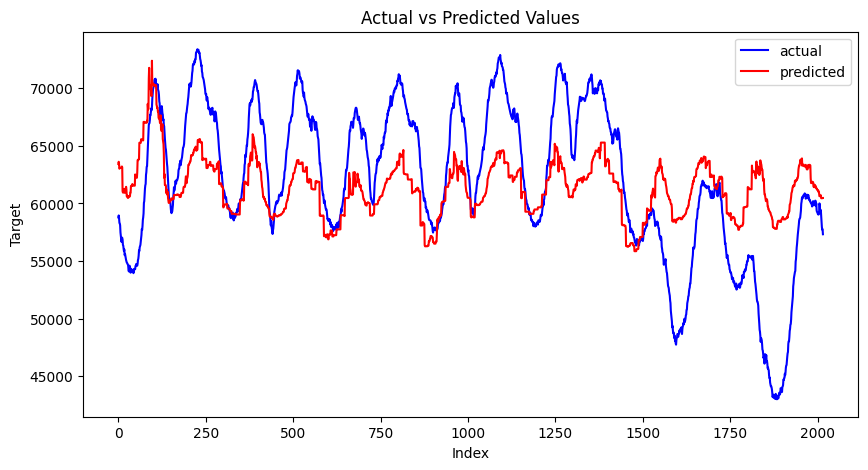

In [47]:
# Now, we can create the plot
plt.figure(figsize=(10,5))

# Plot the actual values
plt.plot(y_test, 'b-', label='actual')

# Plot the predicted values
plt.plot(preds, 'r-', label='predicted')

# Create a legend
plt.legend()

# Add a title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Target')

# Show the plot
plt.show()

# Transformer

In [48]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)  # 사용할 GPU 장치 번호를 입력합니다. 0은 첫 번째 GPU를 의미합니다.
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('현재 디바이스:', device)

현재 디바이스: cpu


In [49]:
torch.cuda.get_device_name()

AssertionError: Torch not compiled with CUDA enabled

In [54]:
torch.set_default_device('cuda')

In [50]:
torch.__version__

'2.0.0'

In [107]:
import torch
from torch.utils.data import Dataset


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device)
        self.seq_length = sequence_length

    def __len__(self):
        return self.X.__len__() - self.seq_length #timeDAta에서 seq 길이를 뺀것이 무슨 의미가 있는거지

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_length], self.y[index+self.seq_length])

SEQUENCE_LENGTH = 3  # 이는 문제에 따라 조정해야 합니다.
N_FEATURES = 95
patience = 5

dataset = TimeSeriesDataset(X_train, y_train, SEQUENCE_LENGTH)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)


val_dataset = TimeSeriesDataset(X_val, y_val, SEQUENCE_LENGTH)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


test_dataset = TimeSeriesDataset(X_test, y_test, SEQUENCE_LENGTH)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [99]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, input_dim, output_dim, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(input_dim, dropout)
        encoder_layers = TransformerEncoderLayer(input_dim, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.decoder = nn.Linear(input_dim, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        #src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src) 
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:   # Check if d_model is even
            pe[:, 1::2] = torch.cos(position * div_term)
        else:   # If d_model is odd
            pe[:, 1::2] = torch.cos(position * div_term[:-1])   # Ignore the last term
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [100]:
X_train.shape, y_train.shape

((436404, 95), (436404, 1))

In [108]:
import torch.optim as optim
import numpy as np
import math

# Initialize model, loss, and optimizer
model = TransformerModel(input_dim=N_FEATURES , output_dim=1, nhead=5, nhid=16, nlayers=2).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [109]:
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=95, out_features=95, bias=True)
        )
        (linear1): Linear(in_features=95, out_features=16, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=16, out_features=95, bias=True)
        (norm1): LayerNorm((95,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((95,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=95, out_features=1, bias=True)
)


In [110]:
import torchmetrics

In [ ]:
def train_model(model, epochs):
    model.train()
    best_val_loss = np.inf
    patience_counter = 0
    
    for epoch in range(epochs):
        for i, (x, y) in enumerate(dataloader): # assume train_loader is your DataLoader
            optimizer.zero_grad()
            x = x.transpose(0, 1) # Transform input to suitable shape
            output = model(x)
            loss = loss_fn(output[-1], y) # Compute loss
            loss.backward() # Compute gradients
            optimizer.step() # Update weights

        # Validation
        model.eval()
        val_loss = 0
        val_mape = 0
        for i, (x, y) in enumerate(val_loader): # assume val_loader is your DataLoader
            x = x.transpose(0, 1)
            output = model(x)
            loss = loss_fn(output[-1], y)
            val_loss += loss.item()
            val_mape += torchmetrics.functional.mean_absolute_percentage_error(output[-1], y).item()

        val_loss /= len(val_loader)
        val_mape /= len(val_loader)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss}, Val MAPE: {val_mape}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        model.train()

train_model(model, epochs=100)


Epoch 1/100, Train Loss: 209303472.0, Val Loss: 170088704.9663742, Val MAPE: 0.18658261112377178
Epoch 2/100, Train Loss: 217360176.0, Val Loss: 175197809.02262875, Val MAPE: 0.189716545546624


In [63]:
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_mape = 0
    with torch.no_grad():  # Don't track gradients
        for i, (x, y) in enumerate(dataloader):
            x = x.transpose(0, 1)
            output = model(x)
            loss = loss_fn(output[-1], y)
            total_loss += loss.item()
            total_mape += torchmetrics.functional.mean_absolute_percentage_error(output[-1], y).item()
    
    avg_loss = total_loss / len(dataloader)
    mape = total_mape / len(dataloader)
    print(f'Average Loss: {avg_loss}, MAPE: {mape}')
    return avg_loss, mape

# Suppose you have a validation or test dataloader, named val_loader or test_loader
evaluate_model(model, test_loader)


Average Loss: 123462953.00929493, MAPE: 0.15462099803021206


(123462953.00929493, 0.15462099803021206)

# LINEAR

In [43]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)  # 사용할 GPU 장치 번호를 입력합니다. 0은 첫 번째 GPU를 의미합니다.
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('현재 디바이스:', device)

현재 디바이스: cuda


In [38]:
import torch
from torch.utils.data import Dataset


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device)
        self.seq_length = sequence_length

    def __len__(self):
        return self.X.__len__() - self.seq_length #timeDAta에서 seq 길이를 뺀것이 무슨 의미가 있는거지

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_length], self.y[index+self.seq_length])

SEQUENCE_LENGTH = 3  # 이는 문제에 따라 조정해야 합니다.
N_FEATURES = 10


dataset = TimeSeriesDataset(X_train, y_train, SEQUENCE_LENGTH)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)


val_dataset = TimeSeriesDataset(X_val, y_val, SEQUENCE_LENGTH)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TimeSeriesDataset(X_test, y_test, SEQUENCE_LENGTH)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [64]:
import torch.nn as nn
import torch.optim as optim

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

# Here, the input size will be the product of SEQUENCE_LENGTH and N_FEATURES
# because we are flattening the sequence into a single vector.
# The output size is set to 1 because we're making a single prediction.

INPUT_SIZE = SEQUENCE_LENGTH * N_FEATURES
OUTPUT_SIZE = 1

model = LinearModel(INPUT_SIZE, OUTPUT_SIZE).to(device)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(100):  # 100 epochs
    for i, (sequences, labels) in enumerate(dataloader):
        sequences = sequences.view(-1, INPUT_SIZE)  # Flatten the sequence
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backpropagation and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

print('Finished Training')

Epoch [10/100], Loss: 49353176.0000
Epoch [20/100], Loss: 45966864.0000
Epoch [30/100], Loss: 46295292.0000
Epoch [40/100], Loss: 46576576.0000
Epoch [50/100], Loss: 46607816.0000
Epoch [60/100], Loss: 46493268.0000
Epoch [70/100], Loss: 46313352.0000
Epoch [80/100], Loss: 46113412.0000
Epoch [90/100], Loss: 45916952.0000
Epoch [100/100], Loss: 45733240.0000
Finished Training


In [69]:
import torchmetrics

model.eval()  # Set the model to evaluation mode

total_mape = 0
count = 0

# No need to track gradients for validation, we're not optimizing.
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.view(-1, INPUT_SIZE)  # Flatten the sequence
        outputs = model(sequences)

        total_mape += torchmetrics.functional.mean_absolute_percentage_error(outputs, labels).item()
        count += 1

print('test MAPE: {:.4f}'.format(total_mape / count))


test MAPE: 0.1606


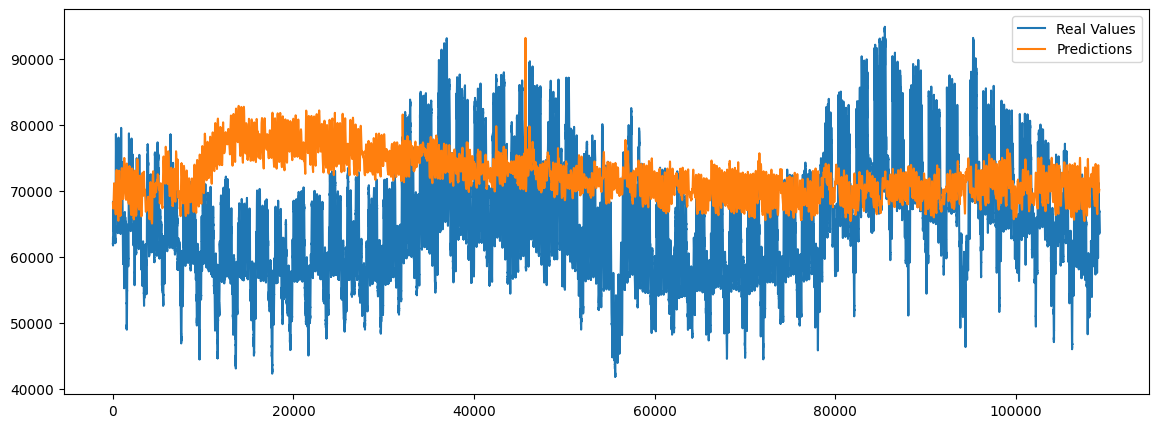

In [70]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # Set the model to evaluation mode

predictions = []
real_values = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.view(-1, INPUT_SIZE)  # Flatten the sequence
        outputs = model(sequences)

        predictions.extend(outputs.flatten().tolist())
        real_values.extend(labels.flatten().tolist())

# Convert to numpy arrays for easier manipulation
predictions = np.array(predictions)
real_values = np.array(real_values)

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(real_values, label='Real Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()
